### Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rc('font',family='malgun gothic')
plt.rc('axes',unicode_minus=False)
import seaborn as sns

# EDA
import klib

# Preprocessing&Feature Engineering
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, RobustScaler, MaxAbsScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectPercentile
from gensim.models import word2vec

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from bayes_opt import BayesianOptimization
import kerastuner as kt

# Modeling
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, ARDRegression, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor
import tensorflow as tf
from vecstack import StackingTransformer
from vecstack import stacking

# Eveluation
from sklearn.metrics import mean_squared_error # squared=False시 RMSE
from sklearn.model_selection import cross_val_score

# Utility
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean
import pickle

### Read Data

In [2]:
df_train =  pd.read_csv(os.path.abspath("../input")+'/X_train.csv', encoding='cp949')
y_train =  pd.read_csv(os.path.abspath("../input")+'/y_train.csv', encoding='cp949')
df_test =  pd.read_csv(os.path.abspath("../input")+'/X_test.csv', encoding='cp949')
test_id = df_test['custid'].unique()
y_train=y_train.set_index('custid')

### Feature Generation&Feature Engineering

In [5]:
tr = pd.concat([df_train, df_test])
tr.head()

,custid,sales_month,sales_day,sales_dayofweek,sales_time,str_nm,goodcd,brd_nm,corner_nm,pc_nm,part_nm,team_nm,buyer_nm,import_flg,tot_amt,dis_amt,net_amt,inst_mon,inst_fee
0,0,6,25,일,1212,무역점,2116050008000,에스티로더,수입종합화장품,화장품,명품잡화,잡화가용팀,화장품,1,90000,9000,81000,3,0
1,0,6,25,일,1242,무역점,4125440008000,시슬리,수입종합화장품,화장품,명품잡화,잡화가용팀,화장품,1,39000,3900,35100,1,0
2,0,8,26,토,1810,본점,2116052008000,크리니크,수입종합화장품,화장품,잡화파트,잡화가용팀,화장품,1,175000,17500,157500,3,0
3,0,8,26,토,1830,본점,4106430119900,듀퐁,수입의류,명품토탈,잡화파트,잡화가용팀,수입명품,1,455000,45500,409500,3,0
4,0,9,3,일,1802,무역점,2139141008000,랑콤,수입종합화장품,화장품,명품잡화,잡화가용팀,화장품,0,100000,10000,90000,3,0


### PCA

In [6]:
# 차원축소 매소드 
from sklearn.decomposition import PCA

def dummy_to_pca(tr, column_name:str) :
    max_seq = 300
    max_d = 15
    col_count = tr.groupby(column_name)[column_name].count()
    if len(col_count) > max_seq:
        tops = col_count.sort_values(ascending=False)[0:max_seq].index
        f =tr.loc[tr[column_name].isin(tops)][['custid', column_name]]
    else:
        tops = col_count.index
        f =tr[['custid', column_name]]
    f = pd.get_dummies(f, columns=[column_name])  # This method performs One-hot-encoding
    f = f.groupby('custid').mean()
    if len(tops) < max_d:
        max_d = len(tops)
    pca = PCA(n_components=max_d)
    pca.fit(f)
    cumsum = np.cumsum(pca.explained_variance_ratio_) #분산의 설명량을 누적합
    print(cumsum)
    num_d = np.argmax(cumsum >= 0.99) + 1 # 분산의 설명량이 99%이상 되는 차원의 수
    if num_d == 1:
        num_d = max_d
    pca = PCA(n_components=num_d)    
    result = pca.fit_transform(f)
    result = pd.DataFrame(result)
    result.columns = [column_name + '_' + str(column) for column in result.columns]
    result.index = f.index
    return result.reset_index()

In [7]:
features=pd.DataFrame({'custid':tr.custid.unique()})
f = dummy_to_pca(tr, 'brd_nm'); features = pd.merge(features,f,on='custid',how='left')
f = dummy_to_pca(tr, 'corner_nm'); features = pd.merge(features,f,on='custid',how='left')
f = dummy_to_pca(tr, 'pc_nm'); features = pd.merge(features,f,on='custid',how='left')
f = dummy_to_pca(tr, 'part_nm'); features = pd.merge(features,f,on='custid',how='left')
f = dummy_to_pca(tr, 'buyer_nm'); features = pd.merge(features,f,on='custid',how='left')
f = dummy_to_pca(tr, 'team_nm'); features = pd.merge(features,f,on='custid',how='left')
f = dummy_to_pca(tr, 'goodcd'); features = pd.merge(features,f,on='custid',how='left')

[0.20925819 0.26247578 0.31026524 0.35465584 0.39279151 0.42773016
 0.45686994 0.48238291 0.50635612 0.52855114 0.54644828 0.56310481
 0.57731785 0.58944097 0.60093382]
[0.27577009 0.32856671 0.36450786 0.39201514 0.41551164 0.43869649
 0.45870453 0.47724244 0.49342461 0.50875394 0.52285227 0.53626021
 0.5490623  0.56165545 0.5733933 ]
[0.30258006 0.35534363 0.39743771 0.43719502 0.46332562 0.48755471
 0.51029985 0.53138766 0.55127217 0.5705587  0.58892423 0.60523831
 0.62019041 0.63461562 0.64853814]
[0.1879969  0.36112839 0.48727324 0.5555609  0.61059754 0.65950855
 0.69744239 0.7270648  0.75559644 0.77902552 0.8018157  0.82369323
 0.84362071 0.86291715 0.88031047]
[0.32693065 0.48981179 0.56968538 0.62867222 0.67853989 0.71931297
 0.75523527 0.78396579 0.81148539 0.8370249  0.85987317 0.88190477
 0.90236185 0.92022774 0.9373244 ]
[0.63403846 0.99999985 1.         1.        ]
[0.23542319 0.29690401 0.34967812 0.39710801 0.44266303 0.48309861
 0.51751953 0.54674546 0.57378356 0.597742

### W2V-상품분류

In [ ]:
def age_vec():
    sentences = []
    df_all = df_train
    for id in tqdm(df_all.custid.unique()):
        x = df_all.query('custid == @id')[level].unique()
        y = y_train.query('custid == @id').age
        for j in range(20):
            y = np.append(y, np.random.choice(x, len(x), replace=False))
        sentences.append(list(y))

In [ ]:
level = 'corner_nm' # 상품 분류 수준

# W2V 학습을 하기에는 데이터(즉 corpus)가 부족하여 
# 고객별로 구매한 상품 목록으로부터 20배 oversampling을 수행
sentences = []
df_all = pd.concat([df_train, df_test])
for id in tqdm(df_all.custid.unique()):
    uw = df_all.query('custid == @id')[level].unique()
    bs = np.array([])
    for j in range(20):
        bs = np.append(bs, np.random.choice(uw, len(uw), replace=False))
    sentences.append(list(bs))
    sentences.append(list(df_all.query('custid == @id')[level].values))

In [ ]:
max_features = 300 # 문자 벡터 차원 수
min_word_count = 1 # 최소 문자 수
num_workers = 4 # 병렬 처리 스레드 수
context = 3 # 문자열 창 크기
downsampling = 1e-3 # 문자 빈도수 Downsample

# 모델 학습
model = word2vec.Word2Vec(sentences, 
                          workers=num_workers, 
#                           size=max_features, 
                          min_count=min_word_count,
                          window=context,
                          sample=downsampling)
# 필요없는 메모리 unload
model.init_sims(replace=True)

In [ ]:
# Make features based on Word2Vec
# 고객별로 구매한 상품의 평균벡터를 feature로 사용한다.
features_wv = []
for id in tqdm(df_train.custid.unique()):
    features_wv.append(df_all.query('custid == @id')[level] \
                              .apply(lambda x: model.wv[x]).mean())
X_train2 = np.array(features_wv)

features_wv = []
for id in tqdm(df_test.custid.unique()):
    features_wv.append(df_all.query('custid == @id')[level] \
                              .apply(lambda x: model.wv[x]).mean())
X_test2 = np.array(features_wv)

X_train2 = pd.DataFrame(X_train2)
X_test2 = pd.DataFrame(X_test2)
X_train2.insert(0,'custid',df_train.custid.unique())
X_test2.insert(0,'custid',df_test.custid.unique())

### W2V-브랜드명

In [12]:
### W2V-브랜드명level = 'brd_nm' # 상품 분류 수준

# W2V 학습을 하기에는 데이터(즉 corpus)가 부족하여 
# 고객별로 구매한 상품 목록으로부터 20배 oversampling을 수행
sentences = []
df_all = pd.concat([df_train, df_test])
for id in tqdm(df_all.custid.unique()):
    uw = df_all.query('custid == @id')[level].unique()
    bs = np.array([])
    for j in range(20):
        bs = np.append(bs, np.random.choice(uw, len(uw), replace=False))
    sentences.append(list(bs))
    sentences.append(list(df_all.query('custid == @id')[level].values))

100%|████████████████████████████████████████████████████████████████████████████| 35967/35967 [10:06<00:00, 59.33it/s]


In [13]:
max_features = 300 # 문자 벡터 차원 수
min_word_count = 1 # 최소 문자 수
num_workers = 4 # 병렬 처리 스레드 수
context = 3 # 문자열 창 크기
downsampling = 1e-3 # 문자 빈도수 Downsample

from gensim.models import word2vec

# 모델 학습
model = word2vec.Word2Vec(sentences, 
                          workers=num_workers, 
#                           size=max_features, 
                          min_count=min_word_count,
                          window=context,
                          sample=downsampling)
# 필요없는 메모리 unload
model.init_sims(replace=True)

In [14]:
# Make features based on Word2Vec
# 고객별로 구매한 상품의 평균벡터를 feature로 사용한다.
features_wv = []
for id in tqdm(df_train.custid.unique()):
    features_wv.append(df_all.query('custid == @id')[level] \
                              .apply(lambda x: model.wv[x]).mean())
X_train3 = np.array(features_wv)

features_wv = []
for id in tqdm(df_test.custid.unique()):
    features_wv.append(df_all.query('custid == @id')[level] \
                              .apply(lambda x: model.wv[x]).mean())
X_test3 = np.array(features_wv)

100%|███████████████████████████████████████████████████████████████████████████| 14380/14380 [02:03<00:00, 116.12it/s]


In [15]:
X_train3 = pd.DataFrame(X_train3)
X_test3 = pd.DataFrame(X_test3)
X_train3.insert(0,'custid',df_train.custid.unique())
X_test3.insert(0,'custid',df_test.custid.unique())

In [8]:
X_train2 = pd.read_excel('X_train2.xlsx',index_col=0)
X_test2 = pd.read_excel('X_test2.xlsx',index_col=0)
X_train3 = pd.read_excel('X_train3.xlsx',index_col=0)
X_test3 = pd.read_excel('X_test3.xlsx',index_col=0)

In [9]:
def month_modify(x):
    if x > 12:
        return x-12
    else:
        return x

def extract_hour(x):
    if len(str(x))>3:
        return str(x)[:2]
    else: 
        return str(x)[:1]
def extract_season(x):
    if 3 <= x <= 5 :
        return('봄')
    elif 6 <= x <= 8 :
        return('여름')
    elif 9 <= x <= 11 :    
        return('가을')
    else :
        return('겨울') 
def time_(x):
    if 9 <= x <= 11 :
        return('아침_구매건수')
    elif 12 <= x <= 17 :
        return('점심_구매건수')
    else :
        return('저녁_구매건수')
def half_year(x):
    if 1<=x<=5:
        return('전반기')
    else:
        return('후반기')
def peak_season(x):
    if x in [7,8,12,1,2]:
        return('성수기')
    else:
        return('비성수기')
def div_month(x):
    if 1<=x<=10:
        return('월초')
    elif 11<=x<=20:
        return('월중')
    else:
        return('월말')
def noon(x):
    if int(str(x)[-2:])<=12:
        return('오전')
    else:
        return('오후')

일반변수

In [10]:
df = tr.copy()
df['sales_hour'] = df.sales_time.apply(extract_hour)
df['sales_hour'] = pd.to_numeric(df['sales_hour'])
df['sales_hour'] = np.where(df['sales_hour'] < 9, 21, df['sales_hour'])
df['방문시간대'] = df.sales_hour.apply(time_)
df['sales_month'] = df.sales_month.apply(month_modify)
df['반기'] = df.sales_month.apply(half_year)
df['성수기여부'] = df.sales_month.apply(peak_season)
df['월_초중말'] = df.sales_day.apply(div_month)
df['오전/오후'] = df.sales_time.apply(noon)

# 총구매액
f = df.groupby('custid')['tot_amt'].agg([('총구매액', 'sum')]).reset_index()
features = pd.merge(features,f, on = 'custid')
# 평균구매액
f = df.groupby('custid')['tot_amt'].agg([('평균구매액', 'mean')]).reset_index()
features = pd.merge(features,f, on = 'custid')

# 총할인금액
f = pd.DataFrame(df.groupby('custid').dis_amt.sum()).rename(columns={'dis_amt':'총할인금액'})
features = pd.merge(features,f, on = 'custid')
# 평균할인금액
f = pd.DataFrame(df.groupby('custid').dis_amt.mean()).rename(columns={'dis_amt':'평균할인금액'})
features = pd.merge(features,f, on = 'custid')

# 총실구매액
f = pd.DataFrame(df.groupby('custid').net_amt.sum()).rename(columns={'net_amt':'총실구매액'})
features = pd.merge(features,f, on = 'custid')
# 평균실구매액
f = pd.DataFrame(df.groupby('custid').net_amt.mean()).rename(columns={'net_amt':'평균실구매액'})
features = pd.merge(features,f, on = 'custid')

# 요일별 방문횟수
f = pd.crosstab(df.custid,df.sales_dayofweek, margins=True).reindex(columns=['월','화','수',
                                                        '목','금','토','일','All']).iloc[:-1,:].rename(columns={'All':'총방문횟수'})
features = pd.merge(features,f, on = 'custid')

# 시간별 방문횟수
f = pd.crosstab(df.custid, df.sales_hour).rename(columns=dict(zip(df.sales_hour.unique(),[str(i)+'시방문' for i in df.sales_hour.unique()])))
features = pd.merge(features,f, on = 'custid')

# 수입상품 구매 건수
f = pd.DataFrame(df.groupby('custid').import_flg.sum()).rename(columns={'import_flg':'수입상품구매건수'})
features = pd.merge(features,f, on = 'custid')

# x = df[df['import_flg'] == 1].groupby('custid').size()
# f = x.reset_index().rename(columns={0: '수입상품_구매건수'}).fillna(0)
# features = pd.merge(features,f, on = 'custid')

# 구매건수
f = df.groupby('custid')['tot_amt'].agg([('구매건수', 'size')]).reset_index()
features = pd.merge(features,f, on = 'custid')

# 평균할부개월수
f = df.groupby('custid')['inst_mon'].agg([('평균할부개월수', 'mean')]).reset_index()
features = pd.merge(features,f, on = 'custid')

# 지점별 방문횟수
f = pd.crosstab(df.custid, df.str_nm).rename(columns=dict(zip(df.str_nm.unique(),[i+'방문' for i in df.str_nm.unique()])))
features = pd.merge(features,f, on = 'custid')

# 방문지점 수
f = df.groupby('custid')['str_nm'].agg([('방문지점수',lambda x: x.nunique())])
features = pd.merge(features,f, on = 'custid')

# 월별 구매횟수
f = pd.crosstab(df.custid,df.sales_month).rename(columns=dict(zip(df.sales_month.unique(), [str(i)+'월방문' for i in df.sales_month.unique()])))
features = pd.merge(features,f, on = 'custid')

# 구매일수
df['sales_month'] = df['sales_month'].astype(str)
df['sales_day'] = df['sales_day'].astype(str)
df['판매일'] = df['sales_month'] + '-' + df['sales_day']
df.판매일 = pd.to_datetime(df.판매일,format='%m-%d')
f = df.groupby(by = 'custid')['판매일'].agg([('구매일수','nunique')]).reset_index()
features = pd.merge(features,f, on = 'custid')

# 구매주기
f = df.groupby('custid')['판매일'].agg([('구매주기', lambda x: int((x.astype('datetime64').max() - x.astype('datetime64').min()).days / x.nunique()))]).reset_index()
features = pd.merge(features,f, on = 'custid')

# 최고 구입 금액
f = df.groupby('custid')['tot_amt'].agg([('최고구매금액', 'max')]).reset_index()
features = pd.merge(features,f, on = 'custid')

# 계절별 구매건수
df['sales_month'] = pd.to_numeric(df['sales_month'])
df['계절'] = df.sales_month.apply(extract_season)
f = pd.pivot_table(df, index = 'custid', columns = '계절', values = 'tot_amt',
                  aggfunc = np.size, fill_value = 0).reset_index()
features = pd.merge(features,f, on = 'custid')

# 반기별 구매건수
f = pd.crosstab(df.custid, df.반기).reset_index()
features = pd.merge(features,f, on = 'custid')

# 성수기 여부 별 구매건수
f = pd.crosstab(df.custid, df.성수기여부).reset_index()
features = pd.merge(features,f, on = 'custid')

# 월 시기별 구매건수
f = pd.crosstab(df.custid, df.월_초중말).reset_index()
features = pd.merge(features,f, on = 'custid')

# 오전/오후별 구매건수
f = pd.crosstab(df.custid, df['오전/오후']).reset_index()
features = pd.merge(features,f, on = 'custid')

# 방문지점 갯수
f = df.groupby(by = 'custid')['str_nm'].agg([('방문지점개수','nunique')]).reset_index()
features = pd.merge(features,f, on = 'custid')

# 구매상품 다양성
n = df.corner_nm.nunique()
f = df.groupby('custid')['goodcd'].agg([('구매상품다양성', lambda x: len(x.unique()) / n)]).reset_index()
features = pd.merge(features,f, on = 'custid')

# 시간대별 방문횟수
f = pd.crosstab(df.custid, df.방문시간대)
features = pd.merge(features,f, on = 'custid')

# 주구매코너
#f = df.groupby('custid')['corner_nm'].agg([('주구매코너', lambda x: x.value_counts().index[0])]).reset_index()
#f = pd.get_dummies(f, columns=['주구매코너'])  # This method performs One-hot-encoding
#features = pd.merge(features,f, on = 'custid')

# 코너별 구매건수
f = pd.pivot_table(df, index='custid', columns='part_nm', values='tot_amt', 
                   aggfunc=np.size, fill_value=0)
f = f.rename(columns=dict(zip(f.columns,[i+'_구매건수' for i in f.columns]))).reset_index()
features = pd.merge(features,f, on = 'custid')

# 바이어 이름 별 구매건수
f = pd.pivot_table(df, index='custid', columns='buyer_nm', values='tot_amt', 
                   aggfunc=np.size, fill_value=0)
f = f.rename(columns=dict(zip(f.columns,[i+'_구매건수' for i in f.columns]))).reset_index()
features = pd.merge(features,f, on = 'custid')

# 무이자 할부 평균 가격
f = df.loc[df.inst_fee==1].groupby('custid').net_amt.agg([('무이자할부평균가격','mean')]).reset_index()
features = pd.merge(features,f,on='custid',how='left').fillna(0)

# 할부결제건수
f = df.loc[df.inst_mon>1].groupby('custid').inst_mon.agg([('할부결제건수','count')])
features = pd.merge(features,f,on='custid',how='left').fillna(0)

# 내점 당 구매금액
f = df.groupby(['custid','판매일'])['tot_amt'].sum().reset_index().groupby('custid')['tot_amt'].agg([('내점당구매금액','mean')]).reset_index()
features = pd.merge(features,f,on='custid',how='left')

# 내점 당 구매개수
f = df.groupby(['custid','판매일'])['tot_amt'].count().reset_index().groupby('custid')['tot_amt'].agg([('내점당구매개수','mean')]).reset_index()
features = pd.merge(features,f,on='custid',how='left')

# 평균쇼핑시간
f = df.groupby(['custid','판매일'])['sales_time'].agg(lambda x: x.max()-x.min()).reset_index().groupby('custid').sales_time.agg([('평균쇼핑시간','mean')])
features = pd.merge(features,f,on='custid',how='left')

```python
# 파트별 구매액 합
f = pd.pivot_table(tr, index='custid', columns='part_nm', values='tot_amt', 
                   aggfunc='sum', fill_value=0).reset_index()
features = pd.merge(features,f, on = 'custid')

# 파트별 할인금액
f = pd.pivot_table(df, index='custid', columns='part_nm', values='dis_amt', 
                   aggfunc='sum', fill_value=0)
f = f.rename(columns=dict(zip(f.columns,[i+'_구매건수' for i in f.columns]))).reset_index()
features = pd.merge(features,f, on = 'custid')

# part_nm별 구매건수
f = pd.pivot_table(df, index='custid', columns='part_nm', values='tot_amt', 
                   aggfunc=np.size, fill_value=0)
f = f.rename(columns=dict(zip(f.columns,[i+'_구매건수' for i in f.columns]))).reset_index()
features = pd.merge(features,f, on = 'custid')
```

In [11]:
del features['custid']

In [12]:
# 이상치 처리
features = features.apply(lambda x: x.clip(x.quantile(0.05), x.quantile(0.95)), axis=0)

# 표준화
features.loc[:,:] = RobustScaler().fit_transform(features)

비율변수

In [13]:
features['custid'] = tr.custid.unique()

tr['sales_hour'] = tr.sales_time.apply(extract_hour)
weekdays = pd.crosstab(tr.custid,tr.sales_dayofweek, margins=True).reindex(columns=['월','화','수',
                                                        '목','금','토','일','All']).iloc[:-1,:].rename(columns={'All':'총방문횟수'})
sales_hour = pd.crosstab(df.custid, df.sales_hour, margins=True)
sales_hour = sales_hour.rename(columns=dict(zip(sales_hour.columns,[str(i)+'시방문' for i in sales_hour.columns])))
str_nm = pd.crosstab(tr.custid, tr.str_nm,margins=True)
str_nm = str_nm.rename(columns=dict(zip(str_nm.columns,[i+'방문' for i in str_nm.columns])))
sales_month = pd.crosstab(df.custid,df.sales_month, margins=True)
sales_month = sales_month.rename(columns=dict(zip(sales_month.columns, [str(i)+'월방문' for i in sales_month])))
tr['sales_month'] = pd.to_numeric(tr['sales_month'])
tr['sales_month'] = tr.sales_month.apply(month_modify)
tr['season'] = pd.DataFrame(tr.sales_month.apply(extract_season))
season_visit = pd.crosstab(tr.custid, tr.season)
tr['mln'] = tr.sales_time.apply(lambda x: int(str(x)[:2])).apply(time_)
mln = pd.crosstab(tr.custid, tr.mln,margins=True)
inv = tr.loc[tr.inst_mon>1].groupby('custid').inst_mon.agg([('할부결제건수','count')])
trans_amount = tr.groupby('custid')['tot_amt'].agg([('구매건수', 'size')])
peak = pd.crosstab(df.custid, df.성수기여부, margins=True)
peak = peak.divide(peak.iloc[:,-1],axis=0).iloc[:-1,:-1]
half = pd.crosstab(df.custid, df.반기, margins=True)
half = half.divide(half.iloc[:,-1],axis=0).iloc[:-1,:-1]
noon = pd.crosstab(df.custid, df['오전/오후'], margins=True)
noon = noon.divide(noon.iloc[:,-1],axis=0).iloc[:-1,:-1]

In [14]:
# 수입상품 구매비율
x = df[df['import_flg'] == 1].groupby('custid').size() / df.groupby('custid').size()
f = x.reset_index().rename(columns={0: '수입상품구매비율'}).fillna(0)
f.iloc[:,1] = (f.iloc[:,1])
features = pd.merge(features,f, on = 'custid')

# 주말 방문 비율
day_to_int = {
    '월': 1,'화': 2,'수': 3,'목': 4,'금': 5,'토': 6,'일': 7}
df2 = df.copy()
df2['sales_dayofweek'] = df2['sales_dayofweek'].map(day_to_int)
df2 = pd.pivot_table(df, index='custid', columns='sales_dayofweek', values='tot_amt', 
                   aggfunc=np.size, fill_value=0).reset_index();
df2['주말방문비율'] = ((df2.iloc[:,5]+df2.iloc[:,6]) / (df2.iloc[:,1]+df2.iloc[:,2]+df2.iloc[:,3]+df2.iloc[:,4]+
                                                df2.iloc[:,5]+df2.iloc[:,6]+df2.iloc[:,7]))
f = df2[['custid','주말방문비율']]
features = pd.merge(features,f, on = 'custid')

# 요일별 방문비율
f = weekdays.iloc[:,:-1].divide(weekdays.iloc[:,-1], axis=0).rename(columns=dict(zip(weekdays.columns,
                                                                                    [str(i)+'_prop' for i in weekdays.columns])))
features = pd.merge(features,f, on = 'custid')

# 시간별 방문비율
f = sales_hour.iloc[:-1,:-1].divide(sales_hour.iloc[:-1,-1],axis=0).rename(columns=dict(zip(sales_hour.columns,
                                                                                    [str(i)+'_prop' for i in sales_hour.columns])))
features = pd.merge(features,f, on = 'custid')
# 지점별 방문비율
f = str_nm.iloc[:-1,:-1].divide(str_nm.iloc[:-1,-1],axis=0).rename(columns=dict(zip(str_nm.columns,[str(i)+'_prop' for i in str_nm.columns]))).reset_index()
features = pd.merge(features,f, on = 'custid')
# 구매월별 방문비율
f = sales_month.iloc[:-1,:-1].divide(sales_month.iloc[:-1,-1],axis=0).rename(columns=
                                                        dict(zip(sales_month.columns,[str(i)+'_prop' for i in sales_month.columns]))).reset_index()
features = pd.merge(features,f, on = 'custid')
# 계절별 방문비율
f = season_visit.divide(weekdays.총방문횟수,axis=0).rename(columns=dict(zip(season_visit.columns,[column+'_prop' for column in season_visit.columns]))).reset_index()
features = pd.merge(features,f, on = 'custid')
# 시간대별 방문비율
f = mln.div(mln.iloc[:,-1], axis=0).iloc[:-1,:-1].reset_index().rename(columns=dict(zip(mln.columns,[i+'_prop' for i in mln.columns])))
features = pd.merge(features,f, on = 'custid')
# 할부결제비율
f =(inv['할부결제건수']/trans_amount['구매건수']).reset_index().rename(columns={0:'할부결제비율'}).fillna(0)
features = pd.merge(features,f, on = 'custid')
# 성수기 방문비율
f = peak.iloc[:,1].reset_index().rename(columns={'성수기':'성수기방문비율'})
features = pd.merge(features,f, on = 'custid')
# 비성수기 방문비율
f = peak.iloc[:,0].reset_index().rename(columns={'비성수기':'비성수기방문비율'})
features = pd.merge(features,f, on = 'custid')
# 전반기 방문비율
f = half.iloc[:,0].reset_index().rename(columns={'전반기':'전반기방문비율'})
features = pd.merge(features,f, on = 'custid')
# 후반기 방문비율
f = half.iloc[:,1].reset_index().rename(columns={'후반기':'후반기방문비율'})
features = pd.merge(features,f, on = 'custid')
# 오전 방문비율
f = noon.iloc[:,0].reset_index().rename(columns={'오전':'오전방문비율'})
features = pd.merge(features,f, on = 'custid')
# 오후 방문비율
f = noon.iloc[:,1].reset_index().rename(columns={'오후':'오후방문비율'})
features = pd.merge(features,f, on = 'custid')
# 할인율 평균
df['할인율'] = df.dis_amt/df.tot_amt
f = df.groupby('custid')['할인율'].mean().reset_index()
features = pd.merge(features,f,on='custid',how='left')

In [15]:
X_train = pd.DataFrame({'custid': df_train.custid.unique()})
X_train = pd.merge(X_train, features, how='left', on='custid')

X_test = pd.DataFrame({'custid': df_test.custid.unique()})
X_test = pd.merge(X_test, features, how='left', on='custid')

merge W2V

In [16]:
X_train = pd.merge(X_train, X_train2, how='left', on='custid')
X_train = X_train.set_index('custid')
X_test = pd.merge(X_test, X_test2, how='left', on='custid')
X_test = X_test.set_index('custid')

In [17]:
X_train = pd.merge(X_train, X_train3, how='left', on='custid')
X_train = X_train.set_index('custid')
X_test = pd.merge(X_test, X_test3, how='left', on='custid')
X_test = X_test.set_index('custid')

One-hot Encoding

In [18]:
level = 'corner_nm'
df_train[level].nunique()
IDtest = df_test.custid.unique()

df_all = pd.concat([df_train, df_test])
x_train = pd.pivot_table(df_all, index='custid', columns=level, values='tot_amt',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('custid not in @IDtest'). \
                         set_index('custid')
x_test = pd.pivot_table(df_all, index='custid', columns=level, values='tot_amt',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('custid in @IDtest'). \
                         set_index('custid')

x_train = pd.merge(x_train, X_train, on = 'custid')
x_test = pd.merge(x_test, X_test, on = 'custid')

### Feature Selection

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [03:49<00:00,  2.41s/it]

(49, -71.00832360519095)


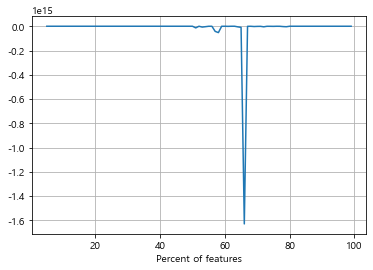

In [22]:
features = x_train
# 사용할 모델 설정 (속도가 빠른 모델 사용 권장)
model = LinearRegression()

# 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 
# feature 개수 바꿔가며 성능 test한다.
cv_scores = []
for p in tqdm(range(5,100,1)):
    X_new = SelectPercentile(percentile=p).fit_transform(x_train, y_train)    
    cv_score = cross_val_score(model, X_new, y_train, scoring='neg_mean_squared_error', cv=5).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [23]:
# 과적합을 피하기 위해 최적의 p값 주변의 값을 선택하는게 더 나은 결과를 얻을 수 있다. 
fs = SelectPercentile(percentile=best_score[0]).fit(x_train, y_train)
x_train = fs.transform(x_train)
x_test = fs.transform(x_test)

print(x_train.shape)
print(features.columns[fs.get_support()].tolist())

(21587, 389)
['건식품', '곡물', '골프(LC)', '골프(NB)', '골프(국내)', '골프(수입)', '골프단품', '골프웨어', '교복행사', '국내부띠끄', '냉장식품', '디자이너니트', '디자이너숍', '라이센스', '레포츠', '로얄부틱2F', '로얄수입행사', '문화', '부띠끄', '생선', '셔츠', '수예행사', '수입도자기', '수입부띠끄', '스포츠슈즈', '스포츠웨어', '신생아', '아동', '아동단품', '아동복', '아동잡화', '아동특선', '야채', '엘레강스', '엘레강스부틱', '영캐주얼', '완구', '완구(문화)', '욕실용품', '용기보증', '유아', '유아복', '임대골프', '잡화(문화)', '정육', '조미료', '주방용품', '진캐쥬얼', '청과', '침구', '타운웨어', '트래디셔널', 'brd_nm_0', 'brd_nm_9', 'brd_nm_10', 'brd_nm_11', 'corner_nm_0', 'corner_nm_1', 'corner_nm_2', 'corner_nm_3', 'corner_nm_4', 'corner_nm_5', 'corner_nm_7', 'corner_nm_10', 'corner_nm_12', 'corner_nm_13', 'corner_nm_14', 'pc_nm_0', 'pc_nm_1', 'pc_nm_2', 'pc_nm_3', 'pc_nm_4', 'pc_nm_7', 'pc_nm_8', 'pc_nm_9', 'pc_nm_10', 'part_nm_0', 'part_nm_2', 'part_nm_3', 'part_nm_5', 'part_nm_6', 'part_nm_8', 'part_nm_9', 'part_nm_12', 'part_nm_14', 'buyer_nm_0', 'buyer_nm_1', 'buyer_nm_2', 'buyer_nm_3', 'buyer_nm_4', 'buyer_nm_7', 'buyer_nm_13', 'team_nm_0', 'team_nm_1', 'goodcd_0

In [24]:
pd.DataFrame(x_train,columns=features.columns[fs.get_support()].tolist()).to_csv('x_train_1round.csv')
pd.DataFrame(x_test,columns=features.columns[fs.get_support()].tolist()).to_csv('x_train_1round.csv')

```python
pd.DataFrame(x_train,columns=features.columns[fs.get_support()].tolist()).to_csv('x_train_1round.csv')
pd.DataFrame(x_test,columns=features.columns[fs.get_support()].tolist()).to_csv('x_train_1round.csv')
```

### Model Tuning

In [25]:
x_train2, x_dev, y_train2, y_dev = train_test_split(x_train, y_train, test_size=0.3, random_state=0)

In [28]:
pbounds = {
    'alpha':(0,50)
}
def rid_opt(alpha):
    params = {
        'alpha':alpha
    }
    rid = Ridge(random_state=0, **params)
    rid.fit(x_train2,y_train2)
    score = mean_squared_error(rid.predict(x_dev),y_dev,squared=False)
    return -score
BO_rid = BayesianOptimization(rid_opt, pbounds, random_state=0)
BO_rid.maximize(init_points=50, n_iter=50) # init_points: exploration, n_iter: iteration

|   iter    |  target   |   alpha   |
-------------------------------------
|  1        | -8.432    |  27.44    |
|  2        | -8.438    |  35.76    |
|  3        | -8.434    |  30.14    |
|  4        | -8.432    |  27.24    |
|  5        | -8.427    |  21.18    |
|  6        | -8.436    |  32.29    |
|  7        | -8.428    |  21.88    |
|  8        | -8.444    |  44.59    |
|  9        | -8.446    |  48.18    |
|  10       | -8.425    |  19.17    |
|  11       | -8.441    |  39.59    |
|  12       | -8.431    |  26.44    |
|  13       | -8.433    |  28.4     |
|  14       | -8.445    |  46.28    |
|  15       | -8.412    |  3.552    |
|  16       | -8.412    |  4.356    |
|  17       | -8.417    |  1.011    |
|  18       | -8.442    |  41.63    |
|  19       | -8.441    |  38.91    |
|  20       | -8.444    |  43.5     |
|  21       | -8.447    |  48.93    |
|  22       | -8.441    |  39.96    |
|  23       | -8.429    |  23.07    |
|  24       | -8.441    |  39.03    |
|  25       

In [29]:
pbounds = {
    'alpha':(0,50)
}
def las_opt(alpha):
    params = {
        'alpha':alpha
    }
    las = Lasso(random_state=0, **params)
    las.fit(x_train2,y_train2)
    score = mean_squared_error(las.predict(x_dev),y_dev,squared=False)
    return -score
BO_las = BayesianOptimization(las_opt, pbounds, random_state=0)
BO_las.maximize(init_points=50, n_iter=50) # init_points: exploration, n_iter: iteration

|   iter    |  target   |   alpha   |
-------------------------------------
|  1        | -10.43    |  27.44    |
|  2        | -10.43    |  35.76    |
|  3        | -10.43    |  30.14    |
|  4        | -10.43    |  27.24    |
|  5        | -10.43    |  21.18    |
|  6        | -10.43    |  32.29    |
|  7        | -10.43    |  21.88    |
|  8        | -10.43    |  44.59    |
|  9        | -10.43    |  48.18    |
|  10       | -10.43    |  19.17    |
|  11       | -10.43    |  39.59    |
|  12       | -10.43    |  26.44    |
|  13       | -10.43    |  28.4     |
|  14       | -10.43    |  46.28    |
|  15       | -10.3     |  3.552    |
|  16       | -10.39    |  4.356    |
|  17       | -9.557    |  1.011    |
|  18       | -10.43    |  41.63    |
|  19       | -10.43    |  38.91    |
|  20       | -10.43    |  43.5     |
|  21       | -10.43    |  48.93    |
|  22       | -10.43    |  39.96    |
|  23       | -10.43    |  23.07    |
|  24       | -10.43    |  39.03    |
|  25       

In [30]:
pbounds = {
    'alpha':(0,50)
}
def ela_opt(alpha):
    params = {
        'alpha':alpha
    }
    ela = ElasticNet(random_state=0, **params)
    ela.fit(x_train2,y_train2)
    score = mean_squared_error(ela.predict(x_dev),y_dev,squared=False)
    return -score
BO_ela = BayesianOptimization(ela_opt, pbounds, random_state=0)
BO_ela.maximize(init_points=50, n_iter=50) # init_points: exploration, n_iter: iteration

|   iter    |  target   |   alpha   |
-------------------------------------
|  1        | -10.43    |  27.44    |
|  2        | -10.43    |  35.76    |
|  3        | -10.43    |  30.14    |
|  4        | -10.43    |  27.24    |
|  5        | -10.43    |  21.18    |
|  6        | -10.43    |  32.29    |
|  7        | -10.43    |  21.88    |
|  8        | -10.43    |  44.59    |
|  9        | -10.43    |  48.18    |
|  10       | -10.43    |  19.17    |
|  11       | -10.43    |  39.59    |
|  12       | -10.43    |  26.44    |
|  13       | -10.43    |  28.4     |
|  14       | -10.43    |  46.28    |
|  15       | -10.06    |  3.552    |
|  16       | -10.18    |  4.356    |
|  17       | -9.299    |  1.011    |
|  18       | -10.43    |  41.63    |
|  19       | -10.43    |  38.91    |
|  20       | -10.43    |  43.5     |
|  21       | -10.43    |  48.93    |
|  22       | -10.43    |  39.96    |
|  23       | -10.43    |  23.07    |
|  24       | -10.43    |  39.03    |
|  25       

In [31]:
pbounds = {
    'n_iter':(100,1000),
    'alpha_1':(0,50),
    'alpha_2':(0,50),
    'lambda_1':(0,10),
    'lambda_2':(0,10)
}
def ard_opt(n_iter,alpha_1,alpha_2,lambda_1,lambda_2):
    params = {
        'n_iter':int(round(n_iter)),
        'alpha_1':alpha_1,
        'alpha_2':alpha_2,
        'lambda_1':lambda_1,
        'lambda_2':lambda_2
    }
    ard = ARDRegression(**params)
    ard.fit(x_train2,y_train2)
    score = mean_squared_error(ard.predict(x_dev),y_dev,squared=False)
    return -score
BO_ard = BayesianOptimization(ard_opt, pbounds, random_state=0)
BO_ard.maximize(init_points=50, n_iter=50) # init_points: exploration, n_iter: iteration

|   iter    |  target   |  alpha_1  |  alpha_2  | lambda_1  | lambda_2  |  n_iter   |
-------------------------------------------------------------------------------------
|  1        | -8.454    |  27.44    |  35.76    |  6.028    |  5.449    |  481.3    |
|  2        | -8.451    |  32.29    |  21.88    |  8.918    |  9.637    |  445.1    |
|  3        | -8.437    |  39.59    |  26.44    |  5.68     |  9.256    |  163.9    |
|  4        | -8.455    |  4.356    |  1.011    |  8.326    |  7.782    |  883.0    |
|  5        | -8.435    |  48.93    |  39.96    |  4.615    |  7.805    |  206.4    |
|  6        | -8.47     |  32.0     |  7.168    |  9.447    |  5.218    |  473.2    |
|  7        | -8.441    |  13.23    |  38.71    |  4.562    |  5.684    |  116.9    |
|  8        | -8.439    |  30.88    |  30.6     |  6.169    |  9.437    |  713.6    |
|  9        | -8.522    |  17.98    |  21.85    |  6.976    |  0.6023   |  700.1    |
|  10       | -8.42     |  33.53    |  10.52    |  1.2

|  58       | -8.419    |  30.85    |  34.34    |  0.0      |  10.0     |  193.2    |
|  59       | -8.442    |  0.2782   |  35.8     |  4.753    |  5.738    |  667.4    |
|  60       | -8.422    |  30.3     |  45.02    |  1.963    |  5.088    |  918.7    |
|  61       | -8.476    |  20.4     |  31.17    |  7.575    |  3.315    |  931.2    |
|  62       | -8.443    |  48.55    |  40.34    |  5.375    |  6.504    |  207.1    |
|  63       | -8.422    |  10.54    |  15.48    |  0.6724   |  0.9194   |  936.2    |
|  64       | -8.419    |  5.747    |  20.39    |  0.0      |  10.0     |  930.7    |
|  65       | -8.419    |  22.95    |  33.03    |  0.0      |  10.0     |  607.7    |
|  66       | -8.499    |  16.86    |  31.36    |  9.935    |  2.106    |  603.9    |
|  67       | -8.419    |  25.26    |  14.32    |  0.0      |  10.0     |  606.4    |
|  68       | -8.419    |  35.85    |  27.16    |  0.0      |  10.0     |  603.9    |
|  69       | -8.473    |  28.58    |  42.92    |  9.3

In [32]:
pbounds = {
    'n_iter':(100,1000),
    'alpha_1':(0,50),
    'alpha_2':(0,50),
    'lambda_1':(0,10),
    'lambda_2':(0,10)
}
def bay_opt(n_iter,alpha_1,alpha_2,lambda_1,lambda_2):
    params = {
        'n_iter':int(round(n_iter)),
        'alpha_1':alpha_1,
        'alpha_2':alpha_2,
        'lambda_1':lambda_1,
        'lambda_2':lambda_2
    }
    bay = BayesianRidge(**params)
    bay.fit(x_train2,y_train2)
    score = mean_squared_error(bay.predict(x_dev),y_dev,squared=False)
    return -score
BO_bay = BayesianOptimization(bay_opt, pbounds, random_state=0)
BO_bay.maximize(init_points=50, n_iter=50)

|   iter    |  target   |  alpha_1  |  alpha_2  | lambda_1  | lambda_2  |  n_iter   |
-------------------------------------------------------------------------------------
|  1        | -8.443    |  27.44    |  35.76    |  6.028    |  5.449    |  481.3    |
|  2        | -8.443    |  32.29    |  21.88    |  8.918    |  9.637    |  445.1    |
|  3        | -8.441    |  39.59    |  26.44    |  5.68     |  9.256    |  163.9    |
|  4        | -8.443    |  4.356    |  1.011    |  8.326    |  7.782    |  883.0    |
|  5        | -8.441    |  48.93    |  39.96    |  4.615    |  7.805    |  206.4    |
|  6        | -8.445    |  32.0     |  7.168    |  9.447    |  5.218    |  473.2    |
|  7        | -8.442    |  13.23    |  38.71    |  4.562    |  5.684    |  116.9    |
|  8        | -8.441    |  30.88    |  30.6     |  6.169    |  9.437    |  713.6    |
|  9        | -8.446    |  17.98    |  21.85    |  6.976    |  0.6023   |  700.1    |
|  10       | -8.44     |  33.53    |  10.52    |  1.2

|  58       | -8.438    |  2.879    |  33.96    |  0.6789   |  9.939    |  106.0    |
|  59       | -8.44     |  45.19    |  16.11    |  2.967    |  6.889    |  477.1    |
|  60       | -8.44     |  0.3161   |  32.34    |  0.6145   |  4.35     |  100.2    |
|  61       | -8.437    |  14.18    |  14.66    |  0.0      |  10.0     |  781.7    |
|  62       | -8.444    |  12.67    |  21.76    |  6.853    |  4.845    |  789.3    |
|  63       | -8.44     |  8.465    |  13.04    |  2.929    |  7.717    |  774.3    |
|  64       | -8.439    |  20.26    |  1.704    |  0.8509   |  7.608    |  779.9    |
|  65       | -8.437    |  46.15    |  43.07    |  0.0      |  10.0     |  752.9    |
|  66       | -8.438    |  41.53    |  48.39    |  0.7864   |  8.601    |  758.8    |
|  67       | -8.441    |  47.53    |  45.48    |  0.5115   |  0.3195   |  751.9    |
|  68       | -8.443    |  38.98    |  41.31    |  8.805    |  9.898    |  758.5    |
|  69       | -8.44     |  17.37    |  10.31    |  0.0

In [33]:
pbounds = {
    'n_estimators':(100,1000),
    'learning_rate':(0,1),
    'max_depth':(2, 32),
    'num_leaves':(2, 64),
    'min_child_samples':(10, 200),
    'min_child_weight':(1, 50),
    'subsample':(0.5, 1),
    'colsample_bytree':(0.5, 1),
    'max_bin':(10, 500),
    'reg_lambda':(0.001, 10),
    'reg_alpha':(0.01, 50)
}
def lgbm_opt(n_estimators, learning_rate, max_depth, num_leaves, min_child_samples, min_child_weight,
             subsample, colsample_bytree, max_bin, reg_lambda, reg_alpha):
    params = {
        "n_estimators":int(round(n_estimators)), 
        "learning_rate":learning_rate,
        'max_depth':int(round(max_depth)),
        'num_leaves':int(round(num_leaves)),
        'min_child_samples': int(round(min_child_samples)),
        'min_child_weight': int(round(min_child_weight)),
        'subsample':max(min(subsample, 1), 0),
        'colsample_bytree':max(min(colsample_bytree, 1), 0),
        'reg_lambda': reg_lambda,
        'reg_alpha': reg_alpha
    }
    lgbm = LGBMRegressor(random_state=0, **params)
    lgbm.fit(x_train2,y_train2)
    score = mean_squared_error(lgbm.predict(x_dev),y_dev,squared=False)
    return -score
BO_lgbm = BayesianOptimization(lgbm_opt, pbounds, random_state=0)
BO_lgbm.maximize(init_points=50, n_iter=50)

|   iter    |  target   | colsam... | learni... |  max_bin  | max_depth | min_ch... | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -9.839    |  0.7744   |  0.7152   |  305.4    |  18.35    |  90.49    |  32.65    |  493.8    |  57.29    |  48.18    |  3.835    |  0.8959   |
|  2        | -9.341    |  0.7644   |  0.568    |  463.5    |  4.131    |  26.55    |  1.991    |  849.4    |  50.25    |  43.5     |  9.786    |  0.8996   |
|  3        | -10.21    |  0.7307   |  0.7805   |  67.95    |  21.2     |  37.24    |  47.29    |  569.7    |  27.71    |  13.24    |  7.743    |  0.7281   |
|  4        | -8.3      |  0.7842   |  0.01879  |  312.6    |  20.36    |  127.2    |  47.24    |  713.6    |  24.29    |  21.86    |  6.977    |  0.5301   |
|  5        | -9.795    |  0.8334   |  0.6706   |  1

|  31       | -10.2     |  0.5906   |  0.7885   |  37.86    |  22.91    |  158.0    |  39.09    |  333.5    |  25.18    |  29.38    |  2.729    |  0.6854   |
|  32       | -9.052    |  0.5985   |  0.4599   |  31.86    |  25.99    |  24.62    |  26.42    |  376.1    |  37.81    |  47.97    |  6.456    |  0.5177   |
|  33       | -9.487    |  0.7152   |  0.51     |  272.7    |  22.44    |  62.74    |  7.314    |  453.4    |  61.3     |  9.365    |  9.04     |  0.7719   |
|  34       | -10.58    |  0.7285   |  0.882    |  234.7    |  23.73    |  85.81    |  45.3     |  721.0    |  45.38    |  16.39    |  7.568    |  0.818    |
|  35       | -8.605    |  0.62     |  0.1605   |  400.2    |  30.77    |  97.05    |  29.96    |  872.0    |  30.35    |  47.59    |  5.758    |  0.9104   |
|  36       | -10.22    |  0.9544   |  0.8155   |  88.11    |  20.87    |  85.7     |  4.073    |  481.6    |  18.04    |  42.45    |  0.334    |  0.9795   |
|  37       | -8.948    |  0.6777   |  0.3567   |  1

|  63       | -9.899    |  0.9796   |  0.7223   |  51.32    |  3.758    |  101.6    |  24.2     |  847.7    |  61.99    |  40.38    |  9.155    |  0.6278   |
|  64       | -10.0     |  0.7356   |  0.7135   |  488.5    |  9.391    |  58.16    |  3.945    |  808.2    |  13.75    |  29.08    |  0.3623   |  0.826    |
|  65       | -9.014    |  0.6494   |  0.3711   |  95.2     |  27.03    |  59.61    |  27.15    |  750.1    |  56.99    |  48.03    |  2.136    |  0.9709   |
|  66       | -10.47    |  0.6605   |  0.8269   |  21.69    |  6.07     |  103.9    |  48.36    |  448.1    |  25.99    |  15.68    |  2.526    |  0.9264   |
|  67       | -8.84     |  0.7637   |  0.001914 |  312.3    |  19.34    |  121.8    |  43.99    |  714.1    |  22.72    |  17.79    |  7.101    |  0.7602   |
|  68       | -8.631    |  0.6773   |  0.2712   |  38.97    |  10.57    |  131.4    |  7.819    |  288.2    |  13.94    |  29.63    |  9.091    |  0.5968   |
|  69       | -9.856    |  0.6716   |  0.6738   |  2

|  95       | -10.37    |  0.5915   |  0.8848   |  422.4    |  4.901    |  192.0    |  29.31    |  997.7    |  37.74    |  34.89    |  4.982    |  0.7188   |
|  96       | -8.905    |  0.5663   |  0.3277   |  285.1    |  26.67    |  118.4    |  29.2     |  683.6    |  39.87    |  42.44    |  6.335    |  0.6376   |
|  97       | -10.22    |  0.6791   |  0.7894   |  297.4    |  14.82    |  37.22    |  12.59    |  895.9    |  38.48    |  16.15    |  5.271    |  0.9826   |
|  98       | -9.264    |  0.6166   |  0.4523   |  24.02    |  5.59     |  93.81    |  8.643    |  325.7    |  27.52    |  18.51    |  0.3086   |  0.5183   |
|  99       | -9.846    |  0.6984   |  0.6325   |  419.0    |  9.997    |  187.6    |  27.5     |  982.0    |  48.23    |  25.89    |  2.976    |  0.7618   |
|  100      | -8.447    |  0.5111   |  0.09371  |  312.9    |  14.69    |  45.71    |  17.27    |  889.0    |  39.94    |  18.38    |  8.042    |  0.7371   |


In [34]:
max_params_rid = BO_rid.max['params']
max_params_las = BO_las.max['params']
max_params_ela = BO_ela.max['params']
max_params_ard = BO_ard.max['params']
max_params_bay = BO_bay.max['params']
max_params_lgbm = BO_lgbm.max['params']

In [35]:
max_params_ard['n_iter'] = int(round(max_params_ard['n_iter']))

max_params_bay['n_iter'] = int(round(max_params_bay['n_iter']))

max_params_lgbm['num_leaves'] = int(round(max_params_lgbm['num_leaves']))
max_params_lgbm['n_estimators'] = int(round(max_params_lgbm['n_estimators']))
max_params_lgbm['max_depth'] = int(round(max_params_lgbm['max_depth']))
max_params_lgbm['min_child_samples'] = int(round(max_params_lgbm['min_child_samples']))
max_params_lgbm['min_child_weight'] = int(round(max_params_lgbm['min_child_weight']))
max_params_lgbm['max_bin'] = int(round(max_params_lgbm['max_bin']))
max_params_lgbm['subsample'] = max(min(max_params_lgbm['subsample'], 1), 0)
max_params_lgbm['colsample_bytree'] = max(min(max_params_lgbm['colsample_bytree'], 1), 0)

In [36]:
print(max_params_rid,'\n',max_params_las,'\n',max_params_ela,'\n',max_params_ard,'\n',max_params_bay,'\n',max_params_lgbm)

{'alpha': 3.8529336672855354} 
 {'alpha': 0.0031679860402866744} 
 {'alpha': 0.0014608597055709716} 
 {'alpha_1': 15.899158969698801, 'alpha_2': 20.713149725733498, 'lambda_1': 0.6414749634878436, 'lambda_2': 6.924721193700199, 'n_iter': 610} 
 {'alpha_1': 46.15331678957845, 'alpha_2': 43.07135618884607, 'lambda_1': 0.0, 'lambda_2': 10.0, 'n_iter': 753} 
 {'colsample_bytree': 0.7842169744343243, 'learning_rate': 0.018789800436355142, 'max_bin': 313, 'max_depth': 20, 'min_child_samples': 127, 'min_child_weight': 47, 'n_estimators': 714, 'num_leaves': 24, 'reg_alpha': 21.857227370429083, 'reg_lambda': 6.976614328076722, 'subsample': 0.5301127358146349}


In [37]:
regs_tuned = [Ridge(random_state=0, **max_params_rid),Lasso(random_state=0, **max_params_las),ElasticNet(random_state=0, **max_params_ela),
             ARDRegression(**max_params_ard),BayesianRidge(**max_params_bay),LGBMRegressor(random_state=0,**max_params_lgbm),CatBoostRegressor(random_state=0)]
regs_tuned = [(str(reg).split('(')[0], reg) for reg in regs_tuned]
regs_tuned[-1] = list(regs_tuned[-1])
regs_tuned[-1][0] = 'CatBoostRegressor'
regs_tuned[-1] = tuple(regs_tuned[-1])

regs_trained = [(name, reg.fit(x_train2, y_train2),mean_squared_error(reg.predict(x_dev),y_dev,squared=False))
                    for name, reg in tqdm(regs_tuned.copy())]

 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:33<00:08,  8.14s/it]

Learning rate set to 0.063286
0:	learn: 10.2827990	total: 180ms	remaining: 2m 59s
1:	learn: 10.1417840	total: 232ms	remaining: 1m 55s
2:	learn: 10.0041515	total: 284ms	remaining: 1m 34s
3:	learn: 9.8944673	total: 335ms	remaining: 1m 23s
4:	learn: 9.7871929	total: 384ms	remaining: 1m 16s
5:	learn: 9.6856229	total: 439ms	remaining: 1m 12s
6:	learn: 9.6010566	total: 489ms	remaining: 1m 9s
7:	learn: 9.5237586	total: 550ms	remaining: 1m 8s
8:	learn: 9.4434486	total: 610ms	remaining: 1m 7s
9:	learn: 9.3647627	total: 668ms	remaining: 1m 6s
10:	learn: 9.2998404	total: 726ms	remaining: 1m 5s
11:	learn: 9.2368507	total: 782ms	remaining: 1m 4s
12:	learn: 9.1784310	total: 843ms	remaining: 1m 3s
13:	learn: 9.1318011	total: 904ms	remaining: 1m 3s
14:	learn: 9.0831597	total: 963ms	remaining: 1m 3s
15:	learn: 9.0408344	total: 1.03s	remaining: 1m 3s
16:	learn: 8.9959588	total: 1.09s	remaining: 1m 2s
17:	learn: 8.9591275	total: 1.15s	remaining: 1m 2s
18:	learn: 8.9250023	total: 1.21s	remaining: 1m 2s
19

161:	learn: 7.8275734	total: 9.69s	remaining: 50.1s
162:	learn: 7.8237607	total: 9.78s	remaining: 50.2s
163:	learn: 7.8189058	total: 9.84s	remaining: 50.2s
164:	learn: 7.8138137	total: 9.9s	remaining: 50.1s
165:	learn: 7.8099242	total: 9.96s	remaining: 50s
166:	learn: 7.8053255	total: 10s	remaining: 50s
167:	learn: 7.8005805	total: 10.1s	remaining: 49.9s
168:	learn: 7.7956320	total: 10.1s	remaining: 49.8s
169:	learn: 7.7916697	total: 10.2s	remaining: 49.8s
170:	learn: 7.7874064	total: 10.3s	remaining: 49.7s
171:	learn: 7.7834003	total: 10.3s	remaining: 49.6s
172:	learn: 7.7802153	total: 10.4s	remaining: 49.5s
173:	learn: 7.7754825	total: 10.4s	remaining: 49.5s
174:	learn: 7.7703649	total: 10.5s	remaining: 49.4s
175:	learn: 7.7660424	total: 10.5s	remaining: 49.3s
176:	learn: 7.7620227	total: 10.6s	remaining: 49.2s
177:	learn: 7.7580812	total: 10.6s	remaining: 49.1s
178:	learn: 7.7529026	total: 10.7s	remaining: 49.1s
179:	learn: 7.7480945	total: 10.8s	remaining: 49s
180:	learn: 7.7438299

323:	learn: 7.1421813	total: 19.5s	remaining: 40.7s
324:	learn: 7.1385656	total: 19.6s	remaining: 40.7s
325:	learn: 7.1338614	total: 19.6s	remaining: 40.6s
326:	learn: 7.1315028	total: 19.7s	remaining: 40.5s
327:	learn: 7.1266967	total: 19.8s	remaining: 40.6s
328:	learn: 7.1232525	total: 19.9s	remaining: 40.6s
329:	learn: 7.1195573	total: 20s	remaining: 40.5s
330:	learn: 7.1148668	total: 20s	remaining: 40.4s
331:	learn: 7.1106693	total: 20.1s	remaining: 40.4s
332:	learn: 7.1060244	total: 20.2s	remaining: 40.4s
333:	learn: 7.1027836	total: 20.3s	remaining: 40.4s
334:	learn: 7.0984905	total: 20.3s	remaining: 40.4s
335:	learn: 7.0956499	total: 20.4s	remaining: 40.3s
336:	learn: 7.0917770	total: 20.5s	remaining: 40.3s
337:	learn: 7.0883823	total: 20.6s	remaining: 40.3s
338:	learn: 7.0847835	total: 20.6s	remaining: 40.3s
339:	learn: 7.0794311	total: 20.7s	remaining: 40.2s
340:	learn: 7.0757362	total: 20.8s	remaining: 40.1s
341:	learn: 7.0734586	total: 20.8s	remaining: 40.1s
342:	learn: 7.07

483:	learn: 6.5944580	total: 30.8s	remaining: 32.9s
484:	learn: 6.5911229	total: 30.9s	remaining: 32.8s
485:	learn: 6.5876977	total: 31s	remaining: 32.7s
486:	learn: 6.5842387	total: 31s	remaining: 32.7s
487:	learn: 6.5809106	total: 31.1s	remaining: 32.6s
488:	learn: 6.5774117	total: 31.2s	remaining: 32.6s
489:	learn: 6.5752588	total: 31.2s	remaining: 32.5s
490:	learn: 6.5715982	total: 31.3s	remaining: 32.5s
491:	learn: 6.5684510	total: 31.4s	remaining: 32.4s
492:	learn: 6.5656980	total: 31.5s	remaining: 32.4s
493:	learn: 6.5628584	total: 31.5s	remaining: 32.3s
494:	learn: 6.5591312	total: 31.6s	remaining: 32.2s
495:	learn: 6.5569310	total: 31.7s	remaining: 32.2s
496:	learn: 6.5538450	total: 31.7s	remaining: 32.1s
497:	learn: 6.5497437	total: 31.8s	remaining: 32s
498:	learn: 6.5462218	total: 31.8s	remaining: 32s
499:	learn: 6.5421964	total: 31.9s	remaining: 31.9s
500:	learn: 6.5392825	total: 32s	remaining: 31.9s
501:	learn: 6.5357727	total: 32.1s	remaining: 31.8s
502:	learn: 6.5324922	

643:	learn: 6.1158183	total: 41.9s	remaining: 23.2s
644:	learn: 6.1132026	total: 42s	remaining: 23.1s
645:	learn: 6.1104444	total: 42.1s	remaining: 23.1s
646:	learn: 6.1085100	total: 42.2s	remaining: 23s
647:	learn: 6.1068975	total: 42.3s	remaining: 23s
648:	learn: 6.1048380	total: 42.4s	remaining: 22.9s
649:	learn: 6.1032118	total: 42.5s	remaining: 22.9s
650:	learn: 6.1020534	total: 42.6s	remaining: 22.8s
651:	learn: 6.0995700	total: 42.6s	remaining: 22.7s
652:	learn: 6.0970119	total: 42.7s	remaining: 22.7s
653:	learn: 6.0935732	total: 42.7s	remaining: 22.6s
654:	learn: 6.0905749	total: 42.8s	remaining: 22.5s
655:	learn: 6.0885296	total: 42.9s	remaining: 22.5s
656:	learn: 6.0863658	total: 42.9s	remaining: 22.4s
657:	learn: 6.0844295	total: 43s	remaining: 22.3s
658:	learn: 6.0812124	total: 43s	remaining: 22.3s
659:	learn: 6.0780902	total: 43.1s	remaining: 22.2s
660:	learn: 6.0757741	total: 43.2s	remaining: 22.1s
661:	learn: 6.0736285	total: 43.2s	remaining: 22.1s
662:	learn: 6.0710910	

804:	learn: 5.6994274	total: 53.6s	remaining: 13s
805:	learn: 5.6966299	total: 53.6s	remaining: 12.9s
806:	learn: 5.6936584	total: 53.7s	remaining: 12.8s
807:	learn: 5.6906637	total: 53.8s	remaining: 12.8s
808:	learn: 5.6881954	total: 53.8s	remaining: 12.7s
809:	learn: 5.6858362	total: 53.9s	remaining: 12.6s
810:	learn: 5.6829286	total: 53.9s	remaining: 12.6s
811:	learn: 5.6808874	total: 54s	remaining: 12.5s
812:	learn: 5.6786083	total: 54.1s	remaining: 12.4s
813:	learn: 5.6762187	total: 54.1s	remaining: 12.4s
814:	learn: 5.6734024	total: 54.2s	remaining: 12.3s
815:	learn: 5.6708739	total: 54.3s	remaining: 12.2s
816:	learn: 5.6686552	total: 54.4s	remaining: 12.2s
817:	learn: 5.6660747	total: 54.5s	remaining: 12.1s
818:	learn: 5.6639321	total: 54.6s	remaining: 12.1s
819:	learn: 5.6611648	total: 54.7s	remaining: 12s
820:	learn: 5.6593720	total: 54.7s	remaining: 11.9s
821:	learn: 5.6566746	total: 54.8s	remaining: 11.9s
822:	learn: 5.6542412	total: 54.9s	remaining: 11.8s
823:	learn: 5.6520

966:	learn: 5.3105444	total: 1m 4s	remaining: 2.2s
967:	learn: 5.3090234	total: 1m 4s	remaining: 2.13s
968:	learn: 5.3073594	total: 1m 4s	remaining: 2.06s
969:	learn: 5.3053809	total: 1m 4s	remaining: 2s
970:	learn: 5.3026271	total: 1m 4s	remaining: 1.93s
971:	learn: 5.2998529	total: 1m 4s	remaining: 1.86s
972:	learn: 5.2975105	total: 1m 4s	remaining: 1.8s
973:	learn: 5.2950920	total: 1m 4s	remaining: 1.73s
974:	learn: 5.2924100	total: 1m 4s	remaining: 1.67s
975:	learn: 5.2903283	total: 1m 5s	remaining: 1.6s
976:	learn: 5.2888070	total: 1m 5s	remaining: 1.53s
977:	learn: 5.2858464	total: 1m 5s	remaining: 1.47s
978:	learn: 5.2834124	total: 1m 5s	remaining: 1.4s
979:	learn: 5.2818929	total: 1m 5s	remaining: 1.33s
980:	learn: 5.2805954	total: 1m 5s	remaining: 1.26s
981:	learn: 5.2794523	total: 1m 5s	remaining: 1.2s
982:	learn: 5.2770337	total: 1m 5s	remaining: 1.13s
983:	learn: 5.2746149	total: 1m 5s	remaining: 1.06s
984:	learn: 5.2722989	total: 1m 5s	remaining: 999ms
985:	learn: 5.270383

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:43<00:00, 14.76s/it]


In [38]:
regs_tuned = [Ridge(random_state=0, **max_params_rid),Lasso(random_state=0, **max_params_las),ElasticNet(random_state=0, **max_params_ela),
             ARDRegression(**max_params_ard),BayesianRidge(**max_params_bay),LGBMRegressor(random_state=0,**max_params_lgbm),CatBoostRegressor(random_state=0)]
regs_tuned = [(str(reg).split('(')[0], reg) for reg in regs_tuned]
regs_tuned[-1] = list(regs_tuned[-1])
regs_tuned[-1][0] = 'CatBoostRegressor'
regs_tuned[-1] = tuple(regs_tuned[-1])

regs_trained_for_submissions = [(name, reg.fit(x_train,y_train)) for name, reg in tqdm(regs_tuned.copy())]

 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:37<00:08,  8.88s/it]

Learning rate set to 0.067435
0:	learn: 10.2659395	total: 51.6ms	remaining: 51.5s
1:	learn: 10.1122986	total: 111ms	remaining: 55.5s
2:	learn: 9.9719813	total: 170ms	remaining: 56.5s
3:	learn: 9.8552025	total: 231ms	remaining: 57.6s
4:	learn: 9.7438959	total: 290ms	remaining: 57.7s
5:	learn: 9.6384034	total: 418ms	remaining: 1m 9s
6:	learn: 9.5484690	total: 516ms	remaining: 1m 13s
7:	learn: 9.4674455	total: 645ms	remaining: 1m 19s
8:	learn: 9.3856967	total: 742ms	remaining: 1m 21s
9:	learn: 9.3170764	total: 801ms	remaining: 1m 19s
10:	learn: 9.2539230	total: 866ms	remaining: 1m 17s
11:	learn: 9.1937077	total: 931ms	remaining: 1m 16s
12:	learn: 9.1384571	total: 997ms	remaining: 1m 15s
13:	learn: 9.0864107	total: 1.06s	remaining: 1m 14s
14:	learn: 9.0388744	total: 1.13s	remaining: 1m 14s
15:	learn: 9.0005546	total: 1.19s	remaining: 1m 13s
16:	learn: 8.9605599	total: 1.25s	remaining: 1m 12s
17:	learn: 8.9267793	total: 1.32s	remaining: 1m 12s
18:	learn: 8.8926778	total: 1.39s	remaining: 1m

161:	learn: 7.9326481	total: 10.9s	remaining: 56.2s
162:	learn: 7.9278315	total: 10.9s	remaining: 56.1s
163:	learn: 7.9240951	total: 11s	remaining: 56.1s
164:	learn: 7.9196167	total: 11.1s	remaining: 56.2s
165:	learn: 7.9149301	total: 11.2s	remaining: 56.2s
166:	learn: 7.9119723	total: 11.3s	remaining: 56.3s
167:	learn: 7.9084865	total: 11.3s	remaining: 56.2s
168:	learn: 7.9054049	total: 11.4s	remaining: 56.1s
169:	learn: 7.9008611	total: 11.5s	remaining: 56s
170:	learn: 7.8962022	total: 11.5s	remaining: 55.9s
171:	learn: 7.8922663	total: 11.6s	remaining: 55.9s
172:	learn: 7.8889333	total: 11.7s	remaining: 55.8s
173:	learn: 7.8863482	total: 11.7s	remaining: 55.6s
174:	learn: 7.8825636	total: 11.8s	remaining: 55.5s
175:	learn: 7.8783112	total: 11.8s	remaining: 55.4s
176:	learn: 7.8746028	total: 11.9s	remaining: 55.3s
177:	learn: 7.8703327	total: 12s	remaining: 55.2s
178:	learn: 7.8658529	total: 12s	remaining: 55.2s
179:	learn: 7.8623183	total: 12.1s	remaining: 55.1s
180:	learn: 7.858836

322:	learn: 7.3683060	total: 21.3s	remaining: 44.7s
323:	learn: 7.3642237	total: 21.4s	remaining: 44.6s
324:	learn: 7.3606784	total: 21.4s	remaining: 44.5s
325:	learn: 7.3568747	total: 21.5s	remaining: 44.5s
326:	learn: 7.3535142	total: 21.6s	remaining: 44.4s
327:	learn: 7.3508762	total: 21.6s	remaining: 44.3s
328:	learn: 7.3474871	total: 21.7s	remaining: 44.2s
329:	learn: 7.3450045	total: 21.7s	remaining: 44.2s
330:	learn: 7.3418717	total: 21.8s	remaining: 44.1s
331:	learn: 7.3397009	total: 21.9s	remaining: 44.1s
332:	learn: 7.3372665	total: 22s	remaining: 44s
333:	learn: 7.3349763	total: 22s	remaining: 43.9s
334:	learn: 7.3331492	total: 22.1s	remaining: 43.8s
335:	learn: 7.3290671	total: 22.1s	remaining: 43.7s
336:	learn: 7.3260004	total: 22.2s	remaining: 43.7s
337:	learn: 7.3223997	total: 22.3s	remaining: 43.6s
338:	learn: 7.3197458	total: 22.3s	remaining: 43.5s
339:	learn: 7.3160899	total: 22.4s	remaining: 43.4s
340:	learn: 7.3134744	total: 22.4s	remaining: 43.3s
341:	learn: 7.3115

482:	learn: 6.9210669	total: 31.7s	remaining: 33.9s
483:	learn: 6.9176067	total: 31.7s	remaining: 33.8s
484:	learn: 6.9149861	total: 31.8s	remaining: 33.8s
485:	learn: 6.9122085	total: 31.8s	remaining: 33.7s
486:	learn: 6.9098026	total: 31.9s	remaining: 33.6s
487:	learn: 6.9070469	total: 32s	remaining: 33.5s
488:	learn: 6.9038269	total: 32s	remaining: 33.5s
489:	learn: 6.9002345	total: 32.1s	remaining: 33.4s
490:	learn: 6.8981322	total: 32.1s	remaining: 33.3s
491:	learn: 6.8959308	total: 32.2s	remaining: 33.2s
492:	learn: 6.8928666	total: 32.3s	remaining: 33.2s
493:	learn: 6.8907059	total: 32.3s	remaining: 33.1s
494:	learn: 6.8880449	total: 32.4s	remaining: 33s
495:	learn: 6.8857872	total: 32.4s	remaining: 33s
496:	learn: 6.8838806	total: 32.5s	remaining: 32.9s
497:	learn: 6.8810521	total: 32.6s	remaining: 32.8s
498:	learn: 6.8788508	total: 32.6s	remaining: 32.8s
499:	learn: 6.8764936	total: 32.7s	remaining: 32.7s
500:	learn: 6.8739554	total: 32.7s	remaining: 32.6s
501:	learn: 6.871491

643:	learn: 6.5167571	total: 41.8s	remaining: 23.1s
644:	learn: 6.5141428	total: 41.9s	remaining: 23.1s
645:	learn: 6.5118479	total: 41.9s	remaining: 23s
646:	learn: 6.5101444	total: 42s	remaining: 22.9s
647:	learn: 6.5077411	total: 42.1s	remaining: 22.9s
648:	learn: 6.5053441	total: 42.1s	remaining: 22.8s
649:	learn: 6.5031749	total: 42.2s	remaining: 22.7s
650:	learn: 6.5009800	total: 42.2s	remaining: 22.6s
651:	learn: 6.4978262	total: 42.3s	remaining: 22.6s
652:	learn: 6.4957327	total: 42.4s	remaining: 22.5s
653:	learn: 6.4939228	total: 42.4s	remaining: 22.4s
654:	learn: 6.4909280	total: 42.5s	remaining: 22.4s
655:	learn: 6.4887007	total: 42.6s	remaining: 22.3s
656:	learn: 6.4863245	total: 42.6s	remaining: 22.3s
657:	learn: 6.4844501	total: 42.7s	remaining: 22.2s
658:	learn: 6.4822027	total: 42.8s	remaining: 22.2s
659:	learn: 6.4796321	total: 42.9s	remaining: 22.1s
660:	learn: 6.4770518	total: 42.9s	remaining: 22s
661:	learn: 6.4749939	total: 43s	remaining: 22s
662:	learn: 6.4721008	

805:	learn: 6.1576307	total: 52.1s	remaining: 12.5s
806:	learn: 6.1553321	total: 52.1s	remaining: 12.5s
807:	learn: 6.1535587	total: 52.2s	remaining: 12.4s
808:	learn: 6.1512151	total: 52.3s	remaining: 12.3s
809:	learn: 6.1491351	total: 52.3s	remaining: 12.3s
810:	learn: 6.1469954	total: 52.4s	remaining: 12.2s
811:	learn: 6.1450446	total: 52.4s	remaining: 12.1s
812:	learn: 6.1431635	total: 52.5s	remaining: 12.1s
813:	learn: 6.1410225	total: 52.6s	remaining: 12s
814:	learn: 6.1391356	total: 52.6s	remaining: 11.9s
815:	learn: 6.1368578	total: 52.7s	remaining: 11.9s
816:	learn: 6.1354409	total: 52.8s	remaining: 11.8s
817:	learn: 6.1338792	total: 52.9s	remaining: 11.8s
818:	learn: 6.1320254	total: 52.9s	remaining: 11.7s
819:	learn: 6.1302303	total: 53s	remaining: 11.6s
820:	learn: 6.1285498	total: 53.1s	remaining: 11.6s
821:	learn: 6.1266068	total: 53.1s	remaining: 11.5s
822:	learn: 6.1245721	total: 53.2s	remaining: 11.4s
823:	learn: 6.1226487	total: 53.3s	remaining: 11.4s
824:	learn: 6.12

967:	learn: 5.8266982	total: 1m 2s	remaining: 2.07s
968:	learn: 5.8248449	total: 1m 2s	remaining: 2.01s
969:	learn: 5.8229783	total: 1m 2s	remaining: 1.94s
970:	learn: 5.8207129	total: 1m 2s	remaining: 1.88s
971:	learn: 5.8187510	total: 1m 2s	remaining: 1.81s
972:	learn: 5.8168931	total: 1m 2s	remaining: 1.75s
973:	learn: 5.8148864	total: 1m 3s	remaining: 1.68s
974:	learn: 5.8130507	total: 1m 3s	remaining: 1.62s
975:	learn: 5.8115880	total: 1m 3s	remaining: 1.55s
976:	learn: 5.8095806	total: 1m 3s	remaining: 1.49s
977:	learn: 5.8079496	total: 1m 3s	remaining: 1.42s
978:	learn: 5.8058415	total: 1m 3s	remaining: 1.36s
979:	learn: 5.8039918	total: 1m 3s	remaining: 1.29s
980:	learn: 5.8029716	total: 1m 3s	remaining: 1.23s
981:	learn: 5.8016489	total: 1m 3s	remaining: 1.16s
982:	learn: 5.7999834	total: 1m 3s	remaining: 1.1s
983:	learn: 5.7982487	total: 1m 3s	remaining: 1.03s
984:	learn: 5.7963931	total: 1m 3s	remaining: 970ms
985:	learn: 5.7946775	total: 1m 3s	remaining: 906ms
986:	learn: 5

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:42<00:00, 27.35s/it]

998:	learn: 5.7692358	total: 1m 4s	remaining: 64.6ms
999:	learn: 5.7663545	total: 1m 4s	remaining: 0us


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:42<00:00, 14.64s/it]


In [39]:
regs_tuned = [Ridge(random_state=0, **max_params_rid),Lasso(random_state=0, **max_params_las),ElasticNet(random_state=0, **max_params_ela),
             ARDRegression(**max_params_ard),BayesianRidge(**max_params_bay),LGBMRegressor(random_state=0,**max_params_lgbm),CatBoostRegressor(random_state=0)]
regs_tuned = [(str(reg).split('(')[0], reg) for reg in regs_tuned]
regs_tuned[-1] = list(regs_tuned[-1])
regs_tuned[-1][0] = 'CatBoostRegressor'
regs_tuned[-1] = tuple(regs_tuned[-1])

### Deep Neural Network

In [46]:
def reset_seeds(reset_graph_with_backend=None):
    if reset_graph_with_backend is not None:
        K = reset_graph_with_backend
        K.clear_session()
        tf.compat.v1.reset_default_graph()
        print("KERAS AND TENSORFLOW GRAPHS RESET")  # optional

    np.random.seed(1)
    # seed를 잘 설정하면 성능이 더 잘 오른다.
    random.seed(2)
    tf.compat.v1.set_random_seed(3)
#    os.environ['CUDA_VISIBLE_DEVICES'] = ''  # for GPU
    print("RANDOM SEEDS RESET")  # optional
   
reset_seeds()

RANDOM SEEDS RESET


In [47]:
i = int(round(x_train2.shape[0] * 0.8,0))
x_val, y_val = x_train2[i:], y_train2[i:]
x_train3, y_train3 = x_train2[:i], y_train2[:i]

In [48]:
def model_fn(hp):
    inputs = tf.keras.Input(shape=(x_train3.shape[1],))
    x = inputs
    for i in range(hp.Int('num_layers', 2, 4, step=1)):
        x = tf.keras.layers.Dense(hp.Int('unit_'+str(i), 16, 128, step=16),
                               activation=hp.Choice('activation',['relu','tanh']))(x)
        x = tf.keras.layers.Dropout(hp.Float('dropout_'+str(i), 0, 0.5, step=0.25, default=0.5))(x)
    outputs = tf.keras.layers.Dense(1, activation='linear')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(loss='mse', 
                  optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])), 
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

In [49]:
# keras tuner는 튜닝 종류가 4종류가 있음: hyperband, grid search, random search, bayesian optimization
tuner = kt.Hyperband(model_fn,
                     objective=kt.Objective('val_root_mean_squared_error', direction="min"), 
                     max_epochs=30,
                     hyperband_iterations=2,
                     overwrite=True,
                     directory='dnn_tuning')
# objective: 튜닝 기준, hyperband_iterations:이거 자체에서 2번 반복
# overwrite: False시, 기존을 근거로 해 재학습 안시킴

tuner.search(x_train3, y_train3, validation_data=(x_val, y_val),
             callbacks=[tf.keras.callbacks.EarlyStopping()])
# 빨리 끝내려고 파라미터 저렇게 설정한 것임

Trial 180 Complete [00h 00m 21s]
val_root_mean_squared_error: 10.443819999694824

Best val_root_mean_squared_error So Far: 8.317049026489258
Total elapsed time: 00h 12m 00s
INFO:tensorflow:Oracle triggered exit


In [50]:
tuner.results_summary(1) # 1= 제일 성능이 좋은 놈

Results summary
Results in dnn_tuning\untitled_project
Showing 1 best trials
Objective(name='val_root_mean_squared_error', direction='min')
Trial summary
Hyperparameters:
num_layers: 2
unit_0: 112
activation: tanh
dropout_0: 0.0
unit_1: 80
dropout_1: 0.0
learning_rate: 0.001
unit_2: 48
dropout_2: 0.25
unit_3: 96
dropout_3: 0.0
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 9efb9ddae431f8e2e209173d45c51c51
Score: 8.317049026489258


In [51]:
# Loss & RMSE
dnn = tuner.get_best_models(1)[0] # best model 중 가장 좋은 모델
dnn.evaluate(x_dev, y_dev)

203/203 [==============================] - 0s 958us/step - loss: 68.5120 - root_mean_squared_error: 8.2754


[70.48662567138672, 8.395631790161133]

### Model Ensemble

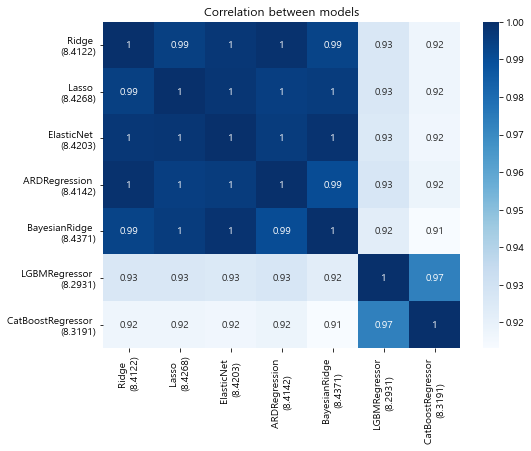

In [54]:
pred_results = []
for name, reg, reg_score in regs_trained:
    pred = list(reg.predict(x_dev))
    name = f'{name} \n({reg_score:.4f})'
    pred_results.append(pd.Series(pred, name=name))
ensemble_results = pd.concat(pred_results, axis=1)
ensemble_results = ensemble_results.applymap(lambda x: float(x))

# 모형의 예측값 간의 상관관계를 보기 위해 hitmap을 도식한다.
plt.figure(figsize = (8,6))
g = sns.heatmap(ensemble_results.corr(), annot=True, cmap='Blues')
g.set_title("Correlation between models")
plt.show()

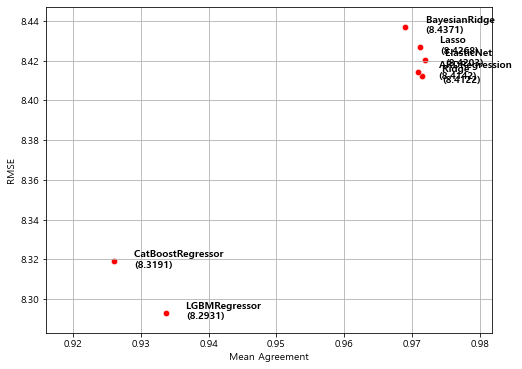

In [55]:
corr = (ensemble_results.corr().sum()-1)/(ensemble_results.corr().shape[0]-1)
names = corr.index
rmse = np.array(corr.index.str[-7:-1]).astype(float)
df = pd.DataFrame({'model': names, 'rmse': rmse, 'cor': corr})        

plt.figure(figsize=(8,6))
g = sns.scatterplot(x="cor", y="rmse", data=df, s=40, color='red')
for line in range(0, df.shape[0]):
     g.text(df.cor[line]+0.003, df.rmse[line]-0.003, 
            df.model[line], horizontalalignment='left', 
            size='medium', color='black', weight='semibold')
        
plt.xlim((df.cor.min()-0.01,df.cor.max()+0.01))
plt.ylim((df.rmse.min()-0.01,df.rmse.max()+0.01))
plt.xlabel('Mean Agreement')
plt.ylabel('RMSE')
plt.grid()
plt.show()

In [66]:
selected = [#'LinearRegression',
            'Ridge',
            #'Lasso',
            #'ElasticNet',
            #'ARDRegression',
            #'BayesianRidge',
            #'RandomForestRegressor',
            #'XGBRegressor',
            'LGBMRegressor',
            'CatBoostRegressor'
            ]
models_for_ensemble = [(name,reg) for name,reg,score in regs_trained if name in selected]
avg = (models_for_ensemble[0][1].predict(x_dev).flatten()+models_for_ensemble[1][1].predict(x_dev)+models_for_ensemble[2][1].predict(x_dev))/len(models_for_ensemble)
score = mean_squared_error(avg, y_dev, squared=False)
score

8.240766161928642

In [112]:
# 최적의 가중치 찾기 
selected = [#'LinearRegression',
            'Ridge',
            #'Lasso',
            #'ElasticNet',
            #'ARDRegression',
            #'BayesianRidge',
            #'RandomForestRegressor',
            #'XGBRegressor',
            'LGBMRegressor',
            'CatBoostRegressor',
            #'DeepNeuralNetwork'
            ]
models_for_ensemble = [(name,reg) for name,reg,score in regs_trained if name in selected]
weights_avg = []
rmse_best = 1000
for i in tqdm(range(1, 30, 1)):
    for j in range(1, 30, 1):
        for k in range(1, 30, 1):
            if (i+j+k) != 30:
                continue
            pred = (models_for_ensemble[0][1].predict(x_dev).flatten() * i + models_for_ensemble[1][1].predict(x_dev) * j
                    + models_for_ensemble[2][1].predict(x_dev) * k)/30
            rmse = np.sqrt(mean_squared_error(y_dev, pred))
            if rmse < rmse_best:
                weights_avg = [i,j,k]
                rmse_best = rmse 
                print(rmse, i,j,k)            

print(rmse_best, weights_avg)

  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

8.303941474118295 1 1 28
8.299217100374552 1 2 27
8.29479167475211 1 3 26
8.29066567597226 1 4 25
8.286839551286869 1 5 24
8.283313716238219 1 6 23
8.280088554435164 1 7 22
8.277164417345851 1 8 21
8.27454162410731 1 9 20
8.272220461352124 1 10 19
8.270201183052388 1 11 18
8.268484010381203 1 12 17
8.267069131591814 1 13 16
8.265956701914602 1 14 15
8.265146843472033 1 15 14
8.264639645211679 1 16 13
8.26443516285739 1 17 12


  3%|██▊                                                                                | 1/29 [00:21<09:50, 21.08s/it]

8.263234883122895 2 11 17
8.26172935395606 2 12 16
8.260526440681579 2 13 15
8.259626275516336 2 14 14
8.259028957451374 2 15 13
8.258734552197506 2 16 12


  7%|█████▋                                                                             | 2/29 [00:40<09:02, 20.08s/it]

8.25718598662514 3 11 16
8.255892596483463 3 12 15
8.254902100354819 3 13 14
8.254214607279996 3 14 13
8.253830192973844 3 15 12
8.253748899783597 3 16 11


 10%|████████▌                                                                          | 3/29 [00:59<08:25, 19.44s/it]

8.253440344826899 4 10 16
8.252056510975903 4 11 15
8.250975685934563 4 12 14
8.250197988790752 4 13 13
8.249723505271598 4 14 12
8.24955228769626 4 15 11


 14%|███████████▍                                                                       | 4/29 [01:17<07:50, 18.84s/it]

8.249019297116932 5 10 15
8.247848171585279 5 11 14
8.246980267568116 5 12 13
8.246415680804187 5 13 12
8.246154473594867 5 14 11


 17%|██████████████▎                                                                    | 5/29 [01:34<07:19, 18.31s/it]

8.24552046637205 6 10 14
8.24456237900273 6 11 13
8.243907681190642 6 12 12
8.243556445220781 6 13 11
8.243508709882473 6 14 10


 21%|█████████████████▏                                                                 | 6/29 [01:51<06:52, 17.92s/it]

8.242945026935143 7 10 13
8.24220023656143 7 11 12
8.241758958917199 7 12 11
8.241621242755008 7 13 10


 24%|████████████████████                                                               | 7/29 [02:08<06:25, 17.50s/it]

8.241293844497413 8 10 12
8.240762538530102 8 11 11
8.24053482344146 8 12 10


 28%|██████████████████████▉                                                            | 8/29 [02:23<05:53, 16.82s/it]

8.240249768779497 9 11 10
8.24023568682186 9 12 9


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [04:54<00:00, 10.15s/it]

8.24023568682186 [9, 12, 9]


### Stacking

In [68]:
selected = [#'LinearRegression',
            'Ridge',
            #'Lasso',
            #'ElasticNet',
            #'ARDRegression',
            #'BayesianRidge',
            #'RandomForestRegressor',
            #'XGBRegressor',
            'LGBMRegressor',
            'CatBoostRegressor'
            ]
stack_estimators = [reg for name,reg,score in regs_trained if name in selected]

In [69]:
S_train, S_test = stacking(stack_estimators,
                           x_train, y_train, x_test,
                           regression=True, n_folds=5, stratified=True, shuffle=True,
                           random_state=0, verbose=2)

task:         [regression]
metric:       [mean_absolute_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [Ridge]
    fold  0:  [6.40366623]
    fold  1:  [6.32651761]
    fold  2:  [6.38835467]
    fold  3:  [6.35723886]
    fold  4:  [6.30192706]
    ----
    MEAN:     [6.35554089] + [0.03771596]
    FULL:     [6.35554177]

model  1:     [LGBMRegressor]
    fold  0:  [6.15322298]
    fold  1:  [6.08938786]
    fold  2:  [6.11291215]
    fold  3:  [6.17539599]
    fold  4:  [6.04836278]
    ----
    MEAN:     [6.11585635] + [0.04517934]
    FULL:     [6.11585685]

model  2:     [CatBoostRegressor]
Learning rate set to 0.064809
0:	learn: 10.2686787	total: 37ms	remaining: 37s
1:	learn: 10.1258506	total: 81.7ms	remaining: 40.7s
2:	learn: 9.9894234	total: 128ms	remaining: 42.5s
3:	learn: 9.8760133	total: 179ms	remaining: 44.5s
4:	learn: 9.7568511	total: 225ms	remaining: 44.8s
5:	learn: 9.6536846	total: 271ms	remaining: 44.9s
6:	learn: 9.5705909	total: 314ms	remaining: 4

148:	learn: 7.9083328	total: 7.66s	remaining: 43.8s
149:	learn: 7.9038223	total: 7.72s	remaining: 43.8s
150:	learn: 7.8996591	total: 7.79s	remaining: 43.8s
151:	learn: 7.8956976	total: 7.84s	remaining: 43.7s
152:	learn: 7.8911710	total: 7.89s	remaining: 43.7s
153:	learn: 7.8873531	total: 7.94s	remaining: 43.6s
154:	learn: 7.8839561	total: 8s	remaining: 43.6s
155:	learn: 7.8794822	total: 8.05s	remaining: 43.6s
156:	learn: 7.8760393	total: 8.1s	remaining: 43.5s
157:	learn: 7.8723937	total: 8.16s	remaining: 43.5s
158:	learn: 7.8681465	total: 8.22s	remaining: 43.5s
159:	learn: 7.8634544	total: 8.27s	remaining: 43.4s
160:	learn: 7.8586196	total: 8.32s	remaining: 43.3s
161:	learn: 7.8558519	total: 8.39s	remaining: 43.4s
162:	learn: 7.8515193	total: 8.44s	remaining: 43.3s
163:	learn: 7.8471874	total: 8.49s	remaining: 43.3s
164:	learn: 7.8437746	total: 8.54s	remaining: 43.2s
165:	learn: 7.8395267	total: 8.58s	remaining: 43.1s
166:	learn: 7.8359496	total: 8.63s	remaining: 43s
167:	learn: 7.8315

311:	learn: 7.2686242	total: 16.3s	remaining: 35.8s
312:	learn: 7.2647094	total: 16.3s	remaining: 35.8s
313:	learn: 7.2610256	total: 16.4s	remaining: 35.7s
314:	learn: 7.2579574	total: 16.4s	remaining: 35.7s
315:	learn: 7.2550940	total: 16.5s	remaining: 35.6s
316:	learn: 7.2527101	total: 16.5s	remaining: 35.6s
317:	learn: 7.2492519	total: 16.5s	remaining: 35.5s
318:	learn: 7.2453858	total: 16.6s	remaining: 35.4s
319:	learn: 7.2412078	total: 16.6s	remaining: 35.4s
320:	learn: 7.2373279	total: 16.7s	remaining: 35.3s
321:	learn: 7.2342924	total: 16.7s	remaining: 35.2s
322:	learn: 7.2296210	total: 16.8s	remaining: 35.2s
323:	learn: 7.2254108	total: 16.8s	remaining: 35.1s
324:	learn: 7.2217808	total: 16.9s	remaining: 35.1s
325:	learn: 7.2195026	total: 16.9s	remaining: 35s
326:	learn: 7.2163138	total: 17s	remaining: 34.9s
327:	learn: 7.2130132	total: 17s	remaining: 34.9s
328:	learn: 7.2095344	total: 17.1s	remaining: 34.9s
329:	learn: 7.2061884	total: 17.1s	remaining: 34.8s
330:	learn: 7.2017

471:	learn: 6.7526777	total: 24.1s	remaining: 27s
472:	learn: 6.7494133	total: 24.2s	remaining: 26.9s
473:	learn: 6.7460263	total: 24.2s	remaining: 26.9s
474:	learn: 6.7431065	total: 24.3s	remaining: 26.8s
475:	learn: 6.7405504	total: 24.3s	remaining: 26.8s
476:	learn: 6.7378424	total: 24.4s	remaining: 26.7s
477:	learn: 6.7340207	total: 24.4s	remaining: 26.7s
478:	learn: 6.7319607	total: 24.4s	remaining: 26.6s
479:	learn: 6.7284923	total: 24.5s	remaining: 26.5s
480:	learn: 6.7257030	total: 24.5s	remaining: 26.5s
481:	learn: 6.7230864	total: 24.6s	remaining: 26.4s
482:	learn: 6.7215223	total: 24.6s	remaining: 26.4s
483:	learn: 6.7190989	total: 24.7s	remaining: 26.3s
484:	learn: 6.7163719	total: 24.7s	remaining: 26.3s
485:	learn: 6.7142937	total: 24.8s	remaining: 26.2s
486:	learn: 6.7103384	total: 24.8s	remaining: 26.2s
487:	learn: 6.7075160	total: 24.9s	remaining: 26.1s
488:	learn: 6.7043439	total: 24.9s	remaining: 26.1s
489:	learn: 6.7024232	total: 25s	remaining: 26s
490:	learn: 6.6998

631:	learn: 6.3095418	total: 31.9s	remaining: 18.6s
632:	learn: 6.3078463	total: 32s	remaining: 18.6s
633:	learn: 6.3045564	total: 32.1s	remaining: 18.5s
634:	learn: 6.3022552	total: 32.1s	remaining: 18.5s
635:	learn: 6.2992402	total: 32.2s	remaining: 18.4s
636:	learn: 6.2972599	total: 32.2s	remaining: 18.4s
637:	learn: 6.2953576	total: 32.3s	remaining: 18.3s
638:	learn: 6.2919497	total: 32.3s	remaining: 18.3s
639:	learn: 6.2887655	total: 32.4s	remaining: 18.2s
640:	learn: 6.2856454	total: 32.4s	remaining: 18.1s
641:	learn: 6.2823002	total: 32.5s	remaining: 18.1s
642:	learn: 6.2792186	total: 32.5s	remaining: 18s
643:	learn: 6.2766385	total: 32.5s	remaining: 18s
644:	learn: 6.2741215	total: 32.6s	remaining: 17.9s
645:	learn: 6.2706147	total: 32.6s	remaining: 17.9s
646:	learn: 6.2668308	total: 32.7s	remaining: 17.8s
647:	learn: 6.2638379	total: 32.7s	remaining: 17.8s
648:	learn: 6.2611331	total: 32.8s	remaining: 17.7s
649:	learn: 6.2592681	total: 32.8s	remaining: 17.7s
650:	learn: 6.2558

793:	learn: 5.9080499	total: 40.1s	remaining: 10.4s
794:	learn: 5.9059884	total: 40.1s	remaining: 10.3s
795:	learn: 5.9034428	total: 40.2s	remaining: 10.3s
796:	learn: 5.9011681	total: 40.2s	remaining: 10.2s
797:	learn: 5.8989454	total: 40.3s	remaining: 10.2s
798:	learn: 5.8969993	total: 40.3s	remaining: 10.1s
799:	learn: 5.8941593	total: 40.4s	remaining: 10.1s
800:	learn: 5.8910040	total: 40.4s	remaining: 10s
801:	learn: 5.8882357	total: 40.5s	remaining: 9.99s
802:	learn: 5.8856521	total: 40.5s	remaining: 9.94s
803:	learn: 5.8836186	total: 40.6s	remaining: 9.88s
804:	learn: 5.8816318	total: 40.6s	remaining: 9.83s
805:	learn: 5.8798241	total: 40.6s	remaining: 9.78s
806:	learn: 5.8777709	total: 40.7s	remaining: 9.73s
807:	learn: 5.8746458	total: 40.7s	remaining: 9.68s
808:	learn: 5.8725182	total: 40.8s	remaining: 9.63s
809:	learn: 5.8702005	total: 40.9s	remaining: 9.58s
810:	learn: 5.8677019	total: 40.9s	remaining: 9.53s
811:	learn: 5.8647017	total: 41s	remaining: 9.48s
812:	learn: 5.86

954:	learn: 5.5325517	total: 48.3s	remaining: 2.28s
955:	learn: 5.5298084	total: 48.4s	remaining: 2.23s
956:	learn: 5.5277759	total: 48.4s	remaining: 2.18s
957:	learn: 5.5253978	total: 48.5s	remaining: 2.13s
958:	learn: 5.5226324	total: 48.6s	remaining: 2.08s
959:	learn: 5.5205347	total: 48.7s	remaining: 2.03s
960:	learn: 5.5185515	total: 48.8s	remaining: 1.98s
961:	learn: 5.5162005	total: 48.8s	remaining: 1.93s
962:	learn: 5.5138738	total: 48.9s	remaining: 1.88s
963:	learn: 5.5119729	total: 48.9s	remaining: 1.83s
964:	learn: 5.5096720	total: 49s	remaining: 1.78s
965:	learn: 5.5078848	total: 49s	remaining: 1.73s
966:	learn: 5.5060351	total: 49.1s	remaining: 1.68s
967:	learn: 5.5038385	total: 49.1s	remaining: 1.62s
968:	learn: 5.5011881	total: 49.2s	remaining: 1.57s
969:	learn: 5.4996050	total: 49.3s	remaining: 1.52s
970:	learn: 5.4979655	total: 49.3s	remaining: 1.47s
971:	learn: 5.4960596	total: 49.4s	remaining: 1.42s
972:	learn: 5.4942448	total: 49.5s	remaining: 1.37s
973:	learn: 5.49

115:	learn: 8.0668910	total: 6.28s	remaining: 47.9s
116:	learn: 8.0634921	total: 6.33s	remaining: 47.8s
117:	learn: 8.0594201	total: 6.38s	remaining: 47.7s
118:	learn: 8.0564409	total: 6.44s	remaining: 47.7s
119:	learn: 8.0522614	total: 6.5s	remaining: 47.7s
120:	learn: 8.0495376	total: 6.56s	remaining: 47.6s
121:	learn: 8.0452171	total: 6.61s	remaining: 47.6s
122:	learn: 8.0415339	total: 6.66s	remaining: 47.5s
123:	learn: 8.0370489	total: 6.72s	remaining: 47.5s
124:	learn: 8.0320883	total: 6.78s	remaining: 47.5s
125:	learn: 8.0284081	total: 6.83s	remaining: 47.4s
126:	learn: 8.0250473	total: 6.88s	remaining: 47.3s
127:	learn: 8.0216218	total: 6.93s	remaining: 47.2s
128:	learn: 8.0177637	total: 6.98s	remaining: 47.1s
129:	learn: 8.0141965	total: 7.03s	remaining: 47.1s
130:	learn: 8.0115181	total: 7.09s	remaining: 47s
131:	learn: 8.0083475	total: 7.14s	remaining: 46.9s
132:	learn: 8.0041971	total: 7.18s	remaining: 46.8s
133:	learn: 8.0006755	total: 7.23s	remaining: 46.7s
134:	learn: 7.9

277:	learn: 7.4274894	total: 14.5s	remaining: 37.7s
278:	learn: 7.4237544	total: 14.6s	remaining: 37.7s
279:	learn: 7.4210144	total: 14.6s	remaining: 37.6s
280:	learn: 7.4173709	total: 14.7s	remaining: 37.5s
281:	learn: 7.4131950	total: 14.7s	remaining: 37.5s
282:	learn: 7.4097268	total: 14.8s	remaining: 37.4s
283:	learn: 7.4056712	total: 14.8s	remaining: 37.4s
284:	learn: 7.4023689	total: 14.9s	remaining: 37.3s
285:	learn: 7.3983212	total: 14.9s	remaining: 37.2s
286:	learn: 7.3957157	total: 15s	remaining: 37.2s
287:	learn: 7.3913355	total: 15s	remaining: 37.1s
288:	learn: 7.3888108	total: 15.1s	remaining: 37s
289:	learn: 7.3858328	total: 15.1s	remaining: 37s
290:	learn: 7.3801026	total: 15.1s	remaining: 36.9s
291:	learn: 7.3768208	total: 15.2s	remaining: 36.8s
292:	learn: 7.3739885	total: 15.2s	remaining: 36.8s
293:	learn: 7.3704069	total: 15.3s	remaining: 36.7s
294:	learn: 7.3663347	total: 15.3s	remaining: 36.7s
295:	learn: 7.3617469	total: 15.4s	remaining: 36.6s
296:	learn: 7.358136

436:	learn: 6.8897090	total: 22s	remaining: 28.4s
437:	learn: 6.8870132	total: 22.1s	remaining: 28.3s
438:	learn: 6.8831776	total: 22.1s	remaining: 28.3s
439:	learn: 6.8797813	total: 22.2s	remaining: 28.2s
440:	learn: 6.8762603	total: 22.2s	remaining: 28.2s
441:	learn: 6.8738137	total: 22.3s	remaining: 28.1s
442:	learn: 6.8711984	total: 22.3s	remaining: 28.1s
443:	learn: 6.8689558	total: 22.4s	remaining: 28s
444:	learn: 6.8662887	total: 22.4s	remaining: 28s
445:	learn: 6.8626522	total: 22.5s	remaining: 27.9s
446:	learn: 6.8590202	total: 22.5s	remaining: 27.9s
447:	learn: 6.8561207	total: 22.6s	remaining: 27.8s
448:	learn: 6.8528905	total: 22.6s	remaining: 27.8s
449:	learn: 6.8504245	total: 22.7s	remaining: 27.7s
450:	learn: 6.8478082	total: 22.7s	remaining: 27.6s
451:	learn: 6.8452520	total: 22.7s	remaining: 27.6s
452:	learn: 6.8415947	total: 22.8s	remaining: 27.5s
453:	learn: 6.8380262	total: 22.8s	remaining: 27.5s
454:	learn: 6.8347863	total: 22.9s	remaining: 27.4s
455:	learn: 6.8322

598:	learn: 6.4323576	total: 29.7s	remaining: 19.9s
599:	learn: 6.4289268	total: 29.8s	remaining: 19.8s
600:	learn: 6.4259739	total: 29.8s	remaining: 19.8s
601:	learn: 6.4232689	total: 29.9s	remaining: 19.7s
602:	learn: 6.4208498	total: 29.9s	remaining: 19.7s
603:	learn: 6.4179005	total: 30s	remaining: 19.7s
604:	learn: 6.4150221	total: 30s	remaining: 19.6s
605:	learn: 6.4121702	total: 30.1s	remaining: 19.5s
606:	learn: 6.4094381	total: 30.1s	remaining: 19.5s
607:	learn: 6.4072199	total: 30.2s	remaining: 19.4s
608:	learn: 6.4054607	total: 30.2s	remaining: 19.4s
609:	learn: 6.4025448	total: 30.2s	remaining: 19.3s
610:	learn: 6.3997372	total: 30.3s	remaining: 19.3s
611:	learn: 6.3969154	total: 30.3s	remaining: 19.2s
612:	learn: 6.3945692	total: 30.4s	remaining: 19.2s
613:	learn: 6.3916690	total: 30.4s	remaining: 19.1s
614:	learn: 6.3880596	total: 30.5s	remaining: 19.1s
615:	learn: 6.3855079	total: 30.5s	remaining: 19s
616:	learn: 6.3821157	total: 30.6s	remaining: 19s
617:	learn: 6.378929

758:	learn: 6.0158512	total: 37.5s	remaining: 11.9s
759:	learn: 6.0138312	total: 37.5s	remaining: 11.9s
760:	learn: 6.0110837	total: 37.6s	remaining: 11.8s
761:	learn: 6.0088847	total: 37.7s	remaining: 11.8s
762:	learn: 6.0052121	total: 37.7s	remaining: 11.7s
763:	learn: 6.0027585	total: 37.8s	remaining: 11.7s
764:	learn: 5.9995745	total: 37.8s	remaining: 11.6s
765:	learn: 5.9967632	total: 37.9s	remaining: 11.6s
766:	learn: 5.9941884	total: 37.9s	remaining: 11.5s
767:	learn: 5.9920663	total: 38s	remaining: 11.5s
768:	learn: 5.9897279	total: 38s	remaining: 11.4s
769:	learn: 5.9874623	total: 38.1s	remaining: 11.4s
770:	learn: 5.9852312	total: 38.1s	remaining: 11.3s
771:	learn: 5.9823757	total: 38.2s	remaining: 11.3s
772:	learn: 5.9794712	total: 38.2s	remaining: 11.2s
773:	learn: 5.9766967	total: 38.3s	remaining: 11.2s
774:	learn: 5.9745863	total: 38.3s	remaining: 11.1s
775:	learn: 5.9716445	total: 38.4s	remaining: 11.1s
776:	learn: 5.9691437	total: 38.4s	remaining: 11s
777:	learn: 5.9665

918:	learn: 5.6420138	total: 45.7s	remaining: 4.03s
919:	learn: 5.6404357	total: 45.8s	remaining: 3.98s
920:	learn: 5.6379966	total: 45.8s	remaining: 3.93s
921:	learn: 5.6361159	total: 45.9s	remaining: 3.88s
922:	learn: 5.6339081	total: 45.9s	remaining: 3.83s
923:	learn: 5.6319806	total: 46s	remaining: 3.78s
924:	learn: 5.6300278	total: 46s	remaining: 3.73s
925:	learn: 5.6283912	total: 46s	remaining: 3.68s
926:	learn: 5.6264445	total: 46.1s	remaining: 3.63s
927:	learn: 5.6231074	total: 46.1s	remaining: 3.58s
928:	learn: 5.6205235	total: 46.2s	remaining: 3.53s
929:	learn: 5.6178322	total: 46.2s	remaining: 3.48s
930:	learn: 5.6163568	total: 46.3s	remaining: 3.43s
931:	learn: 5.6139072	total: 46.3s	remaining: 3.38s
932:	learn: 5.6116801	total: 46.4s	remaining: 3.33s
933:	learn: 5.6086602	total: 46.5s	remaining: 3.28s
934:	learn: 5.6067706	total: 46.5s	remaining: 3.23s
935:	learn: 5.6050399	total: 46.5s	remaining: 3.18s
936:	learn: 5.6024125	total: 46.6s	remaining: 3.13s
937:	learn: 5.6007

77:	learn: 8.2322840	total: 3.76s	remaining: 44.4s
78:	learn: 8.2270934	total: 3.81s	remaining: 44.4s
79:	learn: 8.2219472	total: 3.85s	remaining: 44.3s
80:	learn: 8.2170264	total: 3.9s	remaining: 44.3s
81:	learn: 8.2133122	total: 3.96s	remaining: 44.3s
82:	learn: 8.2084062	total: 4.01s	remaining: 44.3s
83:	learn: 8.2035960	total: 4.06s	remaining: 44.3s
84:	learn: 8.1988552	total: 4.11s	remaining: 44.2s
85:	learn: 8.1934888	total: 4.16s	remaining: 44.2s
86:	learn: 8.1879722	total: 4.21s	remaining: 44.2s
87:	learn: 8.1840539	total: 4.26s	remaining: 44.1s
88:	learn: 8.1789688	total: 4.31s	remaining: 44.1s
89:	learn: 8.1753285	total: 4.35s	remaining: 44s
90:	learn: 8.1703465	total: 4.4s	remaining: 44s
91:	learn: 8.1662187	total: 4.45s	remaining: 43.9s
92:	learn: 8.1617263	total: 4.5s	remaining: 43.9s
93:	learn: 8.1574602	total: 4.54s	remaining: 43.8s
94:	learn: 8.1528320	total: 4.6s	remaining: 43.8s
95:	learn: 8.1485558	total: 4.65s	remaining: 43.8s
96:	learn: 8.1441987	total: 4.7s	remain

239:	learn: 7.5703326	total: 11.8s	remaining: 37.2s
240:	learn: 7.5655957	total: 11.8s	remaining: 37.2s
241:	learn: 7.5609723	total: 11.8s	remaining: 37.1s
242:	learn: 7.5576965	total: 11.9s	remaining: 37.1s
243:	learn: 7.5546752	total: 11.9s	remaining: 37s
244:	learn: 7.5519519	total: 12s	remaining: 36.9s
245:	learn: 7.5472492	total: 12s	remaining: 36.9s
246:	learn: 7.5439417	total: 12.1s	remaining: 36.8s
247:	learn: 7.5408451	total: 12.1s	remaining: 36.8s
248:	learn: 7.5370190	total: 12.2s	remaining: 36.8s
249:	learn: 7.5315492	total: 12.2s	remaining: 36.7s
250:	learn: 7.5276004	total: 12.3s	remaining: 36.7s
251:	learn: 7.5240821	total: 12.3s	remaining: 36.6s
252:	learn: 7.5203891	total: 12.4s	remaining: 36.5s
253:	learn: 7.5168361	total: 12.4s	remaining: 36.5s
254:	learn: 7.5138932	total: 12.5s	remaining: 36.5s
255:	learn: 7.5091426	total: 12.5s	remaining: 36.4s
256:	learn: 7.5073096	total: 12.6s	remaining: 36.3s
257:	learn: 7.5033797	total: 12.6s	remaining: 36.3s
258:	learn: 7.4999

400:	learn: 7.0079996	total: 19.7s	remaining: 29.4s
401:	learn: 7.0039450	total: 19.7s	remaining: 29.3s
402:	learn: 7.0013174	total: 19.8s	remaining: 29.3s
403:	learn: 6.9984244	total: 19.8s	remaining: 29.3s
404:	learn: 6.9946467	total: 19.9s	remaining: 29.2s
405:	learn: 6.9909785	total: 19.9s	remaining: 29.2s
406:	learn: 6.9880153	total: 20s	remaining: 29.1s
407:	learn: 6.9838107	total: 20s	remaining: 29.1s
408:	learn: 6.9798683	total: 20.1s	remaining: 29s
409:	learn: 6.9752220	total: 20.1s	remaining: 29s
410:	learn: 6.9717270	total: 20.2s	remaining: 29s
411:	learn: 6.9680977	total: 20.3s	remaining: 28.9s
412:	learn: 6.9657020	total: 20.3s	remaining: 28.9s
413:	learn: 6.9619628	total: 20.4s	remaining: 28.8s
414:	learn: 6.9579772	total: 20.4s	remaining: 28.8s
415:	learn: 6.9553502	total: 20.5s	remaining: 28.7s
416:	learn: 6.9522949	total: 20.5s	remaining: 28.7s
417:	learn: 6.9488783	total: 20.5s	remaining: 28.6s
418:	learn: 6.9460487	total: 20.6s	remaining: 28.6s
419:	learn: 6.9422124	

561:	learn: 6.5245044	total: 27.7s	remaining: 21.6s
562:	learn: 6.5202375	total: 27.8s	remaining: 21.5s
563:	learn: 6.5167663	total: 27.8s	remaining: 21.5s
564:	learn: 6.5143848	total: 27.9s	remaining: 21.5s
565:	learn: 6.5121785	total: 27.9s	remaining: 21.4s
566:	learn: 6.5092709	total: 28s	remaining: 21.4s
567:	learn: 6.5066954	total: 28s	remaining: 21.3s
568:	learn: 6.5039019	total: 28.1s	remaining: 21.3s
569:	learn: 6.5009228	total: 28.1s	remaining: 21.2s
570:	learn: 6.4970430	total: 28.2s	remaining: 21.2s
571:	learn: 6.4938417	total: 28.2s	remaining: 21.1s
572:	learn: 6.4912771	total: 28.3s	remaining: 21.1s
573:	learn: 6.4881733	total: 28.3s	remaining: 21s
574:	learn: 6.4857196	total: 28.4s	remaining: 21s
575:	learn: 6.4831154	total: 28.4s	remaining: 20.9s
576:	learn: 6.4797061	total: 28.5s	remaining: 20.9s
577:	learn: 6.4767291	total: 28.5s	remaining: 20.8s
578:	learn: 6.4734004	total: 28.6s	remaining: 20.8s
579:	learn: 6.4704907	total: 28.6s	remaining: 20.7s
580:	learn: 6.466110

723:	learn: 6.1002104	total: 35.8s	remaining: 13.7s
724:	learn: 6.0985703	total: 35.9s	remaining: 13.6s
725:	learn: 6.0965362	total: 35.9s	remaining: 13.6s
726:	learn: 6.0941173	total: 36s	remaining: 13.5s
727:	learn: 6.0920620	total: 36s	remaining: 13.5s
728:	learn: 6.0899214	total: 36.1s	remaining: 13.4s
729:	learn: 6.0868697	total: 36.1s	remaining: 13.4s
730:	learn: 6.0846950	total: 36.2s	remaining: 13.3s
731:	learn: 6.0827563	total: 36.2s	remaining: 13.3s
732:	learn: 6.0803025	total: 36.3s	remaining: 13.2s
733:	learn: 6.0785925	total: 36.3s	remaining: 13.2s
734:	learn: 6.0770620	total: 36.3s	remaining: 13.1s
735:	learn: 6.0743732	total: 36.4s	remaining: 13.1s
736:	learn: 6.0716538	total: 36.4s	remaining: 13s
737:	learn: 6.0692038	total: 36.5s	remaining: 13s
738:	learn: 6.0672011	total: 36.5s	remaining: 12.9s
739:	learn: 6.0647993	total: 36.6s	remaining: 12.9s
740:	learn: 6.0622706	total: 36.6s	remaining: 12.8s
741:	learn: 6.0600149	total: 36.7s	remaining: 12.8s
742:	learn: 6.057927

883:	learn: 5.7282731	total: 43.9s	remaining: 5.75s
884:	learn: 5.7263748	total: 43.9s	remaining: 5.71s
885:	learn: 5.7240248	total: 44s	remaining: 5.66s
886:	learn: 5.7218297	total: 44s	remaining: 5.61s
887:	learn: 5.7192040	total: 44.1s	remaining: 5.56s
888:	learn: 5.7175443	total: 44.1s	remaining: 5.51s
889:	learn: 5.7150842	total: 44.2s	remaining: 5.46s
890:	learn: 5.7136539	total: 44.2s	remaining: 5.41s
891:	learn: 5.7118203	total: 44.3s	remaining: 5.36s
892:	learn: 5.7089415	total: 44.3s	remaining: 5.31s
893:	learn: 5.7060731	total: 44.4s	remaining: 5.26s
894:	learn: 5.7041581	total: 44.4s	remaining: 5.21s
895:	learn: 5.7019154	total: 44.5s	remaining: 5.16s
896:	learn: 5.7004047	total: 44.5s	remaining: 5.11s
897:	learn: 5.6980340	total: 44.6s	remaining: 5.06s
898:	learn: 5.6960890	total: 44.6s	remaining: 5.01s
899:	learn: 5.6929991	total: 44.7s	remaining: 4.96s
900:	learn: 5.6907046	total: 44.7s	remaining: 4.91s
901:	learn: 5.6878521	total: 44.8s	remaining: 4.86s
902:	learn: 5.68

42:	learn: 8.4313715	total: 2.07s	remaining: 46.1s
43:	learn: 8.4208909	total: 2.13s	remaining: 46.2s
44:	learn: 8.4118225	total: 2.18s	remaining: 46.2s
45:	learn: 8.3995651	total: 2.23s	remaining: 46.2s
46:	learn: 8.3903111	total: 2.28s	remaining: 46.2s
47:	learn: 8.3806501	total: 2.33s	remaining: 46.2s
48:	learn: 8.3722441	total: 2.38s	remaining: 46.2s
49:	learn: 8.3651598	total: 2.44s	remaining: 46.3s
50:	learn: 8.3573934	total: 2.52s	remaining: 46.9s
51:	learn: 8.3506509	total: 2.57s	remaining: 46.9s
52:	learn: 8.3425262	total: 2.62s	remaining: 46.8s
53:	learn: 8.3357435	total: 2.67s	remaining: 46.7s
54:	learn: 8.3278789	total: 2.72s	remaining: 46.7s
55:	learn: 8.3204611	total: 2.77s	remaining: 46.7s
56:	learn: 8.3118614	total: 2.83s	remaining: 46.8s
57:	learn: 8.3057431	total: 2.88s	remaining: 46.8s
58:	learn: 8.2984251	total: 2.93s	remaining: 46.8s
59:	learn: 8.2916747	total: 2.98s	remaining: 46.7s
60:	learn: 8.2850635	total: 3.03s	remaining: 46.6s
61:	learn: 8.2797356	total: 3.0

205:	learn: 7.6569114	total: 10.4s	remaining: 40.1s
206:	learn: 7.6528202	total: 10.5s	remaining: 40.1s
207:	learn: 7.6490384	total: 10.5s	remaining: 40s
208:	learn: 7.6442675	total: 10.6s	remaining: 39.9s
209:	learn: 7.6411551	total: 10.6s	remaining: 39.9s
210:	learn: 7.6370243	total: 10.7s	remaining: 39.8s
211:	learn: 7.6325027	total: 10.7s	remaining: 39.8s
212:	learn: 7.6274362	total: 10.8s	remaining: 39.7s
213:	learn: 7.6239109	total: 10.8s	remaining: 39.7s
214:	learn: 7.6199577	total: 10.8s	remaining: 39.6s
215:	learn: 7.6171211	total: 10.9s	remaining: 39.6s
216:	learn: 7.6135350	total: 10.9s	remaining: 39.5s
217:	learn: 7.6086471	total: 11s	remaining: 39.4s
218:	learn: 7.6036586	total: 11s	remaining: 39.4s
219:	learn: 7.5998859	total: 11.1s	remaining: 39.3s
220:	learn: 7.5951982	total: 11.1s	remaining: 39.3s
221:	learn: 7.5906950	total: 11.2s	remaining: 39.2s
222:	learn: 7.5848301	total: 11.2s	remaining: 39.2s
223:	learn: 7.5799664	total: 11.3s	remaining: 39.1s
224:	learn: 7.5755

368:	learn: 7.0562538	total: 18.5s	remaining: 31.6s
369:	learn: 7.0530675	total: 18.5s	remaining: 31.5s
370:	learn: 7.0497356	total: 18.5s	remaining: 31.4s
371:	learn: 7.0463547	total: 18.6s	remaining: 31.4s
372:	learn: 7.0432648	total: 18.6s	remaining: 31.3s
373:	learn: 7.0397011	total: 18.7s	remaining: 31.3s
374:	learn: 7.0365179	total: 18.8s	remaining: 31.3s
375:	learn: 7.0334879	total: 18.8s	remaining: 31.2s
376:	learn: 7.0305372	total: 18.9s	remaining: 31.2s
377:	learn: 7.0267084	total: 18.9s	remaining: 31.1s
378:	learn: 7.0242018	total: 19s	remaining: 31.1s
379:	learn: 7.0209575	total: 19s	remaining: 31.1s
380:	learn: 7.0183282	total: 19.1s	remaining: 31s
381:	learn: 7.0153079	total: 19.2s	remaining: 31s
382:	learn: 7.0128183	total: 19.2s	remaining: 31s
383:	learn: 7.0099559	total: 19.3s	remaining: 30.9s
384:	learn: 7.0070238	total: 19.3s	remaining: 30.9s
385:	learn: 7.0036382	total: 19.4s	remaining: 30.8s
386:	learn: 7.0004916	total: 19.4s	remaining: 30.8s
387:	learn: 6.9976815	

529:	learn: 6.5690544	total: 27.1s	remaining: 24s
530:	learn: 6.5651876	total: 27.1s	remaining: 23.9s
531:	learn: 6.5628346	total: 27.2s	remaining: 23.9s
532:	learn: 6.5598718	total: 27.2s	remaining: 23.8s
533:	learn: 6.5560496	total: 27.2s	remaining: 23.8s
534:	learn: 6.5532663	total: 27.3s	remaining: 23.7s
535:	learn: 6.5497357	total: 27.3s	remaining: 23.7s
536:	learn: 6.5472291	total: 27.4s	remaining: 23.6s
537:	learn: 6.5447724	total: 27.4s	remaining: 23.6s
538:	learn: 6.5415554	total: 27.5s	remaining: 23.5s
539:	learn: 6.5385107	total: 27.5s	remaining: 23.5s
540:	learn: 6.5360229	total: 27.6s	remaining: 23.4s
541:	learn: 6.5333616	total: 27.7s	remaining: 23.4s
542:	learn: 6.5303008	total: 27.7s	remaining: 23.3s
543:	learn: 6.5272896	total: 27.8s	remaining: 23.3s
544:	learn: 6.5241234	total: 27.8s	remaining: 23.2s
545:	learn: 6.5202974	total: 27.9s	remaining: 23.2s
546:	learn: 6.5170528	total: 27.9s	remaining: 23.1s
547:	learn: 6.5134641	total: 28s	remaining: 23.1s
548:	learn: 6.51

689:	learn: 6.1299585	total: 35.4s	remaining: 15.9s
690:	learn: 6.1270014	total: 35.4s	remaining: 15.8s
691:	learn: 6.1248922	total: 35.5s	remaining: 15.8s
692:	learn: 6.1225511	total: 35.5s	remaining: 15.7s
693:	learn: 6.1200861	total: 35.6s	remaining: 15.7s
694:	learn: 6.1174014	total: 35.6s	remaining: 15.6s
695:	learn: 6.1155545	total: 35.7s	remaining: 15.6s
696:	learn: 6.1122964	total: 35.7s	remaining: 15.5s
697:	learn: 6.1103742	total: 35.8s	remaining: 15.5s
698:	learn: 6.1077381	total: 35.8s	remaining: 15.4s
699:	learn: 6.1045611	total: 35.9s	remaining: 15.4s
700:	learn: 6.1013482	total: 36s	remaining: 15.3s
701:	learn: 6.0987529	total: 36s	remaining: 15.3s
702:	learn: 6.0952002	total: 36.1s	remaining: 15.2s
703:	learn: 6.0924742	total: 36.1s	remaining: 15.2s
704:	learn: 6.0902923	total: 36.2s	remaining: 15.1s
705:	learn: 6.0876336	total: 36.2s	remaining: 15.1s
706:	learn: 6.0848990	total: 36.3s	remaining: 15s
707:	learn: 6.0830571	total: 36.3s	remaining: 15s
708:	learn: 6.080969

852:	learn: 5.7211185	total: 43.9s	remaining: 7.57s
853:	learn: 5.7189716	total: 44s	remaining: 7.52s
854:	learn: 5.7164445	total: 44s	remaining: 7.46s
855:	learn: 5.7148081	total: 44.1s	remaining: 7.41s
856:	learn: 5.7124030	total: 44.1s	remaining: 7.36s
857:	learn: 5.7101004	total: 44.2s	remaining: 7.31s
858:	learn: 5.7077453	total: 44.2s	remaining: 7.26s
859:	learn: 5.7053200	total: 44.3s	remaining: 7.21s
860:	learn: 5.7025727	total: 44.3s	remaining: 7.16s
861:	learn: 5.7002570	total: 44.4s	remaining: 7.1s
862:	learn: 5.6980042	total: 44.4s	remaining: 7.05s
863:	learn: 5.6965111	total: 44.5s	remaining: 7s
864:	learn: 5.6938484	total: 44.5s	remaining: 6.95s
865:	learn: 5.6914464	total: 44.6s	remaining: 6.9s
866:	learn: 5.6898390	total: 44.6s	remaining: 6.85s
867:	learn: 5.6878593	total: 44.7s	remaining: 6.8s
868:	learn: 5.6853880	total: 44.8s	remaining: 6.75s
869:	learn: 5.6835419	total: 44.8s	remaining: 6.7s
870:	learn: 5.6809655	total: 44.9s	remaining: 6.64s
871:	learn: 5.6780712	t

14:	learn: 9.0607159	total: 687ms	remaining: 45.1s
15:	learn: 9.0211595	total: 743ms	remaining: 45.7s
16:	learn: 8.9796877	total: 792ms	remaining: 45.8s
17:	learn: 8.9439504	total: 840ms	remaining: 45.8s
18:	learn: 8.9113292	total: 885ms	remaining: 45.7s
19:	learn: 8.8820023	total: 932ms	remaining: 45.7s
20:	learn: 8.8553556	total: 976ms	remaining: 45.5s
21:	learn: 8.8258494	total: 1.02s	remaining: 45.5s
22:	learn: 8.8015550	total: 1.07s	remaining: 45.6s
23:	learn: 8.7759066	total: 1.12s	remaining: 45.6s
24:	learn: 8.7501893	total: 1.17s	remaining: 45.6s
25:	learn: 8.7261149	total: 1.22s	remaining: 45.6s
26:	learn: 8.7062001	total: 1.27s	remaining: 45.6s
27:	learn: 8.6844272	total: 1.32s	remaining: 45.7s
28:	learn: 8.6640672	total: 1.36s	remaining: 45.6s
29:	learn: 8.6463910	total: 1.42s	remaining: 46s
30:	learn: 8.6306510	total: 1.47s	remaining: 45.9s
31:	learn: 8.6147321	total: 1.52s	remaining: 45.9s
32:	learn: 8.5997430	total: 1.57s	remaining: 45.9s
33:	learn: 8.5846137	total: 1.63s

175:	learn: 7.8301326	total: 9.51s	remaining: 44.5s
176:	learn: 7.8250737	total: 9.55s	remaining: 44.4s
177:	learn: 7.8208926	total: 9.6s	remaining: 44.3s
178:	learn: 7.8169042	total: 9.65s	remaining: 44.3s
179:	learn: 7.8117987	total: 9.7s	remaining: 44.2s
180:	learn: 7.8074788	total: 9.75s	remaining: 44.1s
181:	learn: 7.8024675	total: 9.8s	remaining: 44s
182:	learn: 7.7994163	total: 9.84s	remaining: 44s
183:	learn: 7.7942595	total: 9.89s	remaining: 43.9s
184:	learn: 7.7889466	total: 9.94s	remaining: 43.8s
185:	learn: 7.7861810	total: 10s	remaining: 43.7s
186:	learn: 7.7813938	total: 10s	remaining: 43.7s
187:	learn: 7.7766342	total: 10.1s	remaining: 43.6s
188:	learn: 7.7718191	total: 10.2s	remaining: 43.6s
189:	learn: 7.7683305	total: 10.2s	remaining: 43.5s
190:	learn: 7.7646898	total: 10.3s	remaining: 43.5s
191:	learn: 7.7595995	total: 10.3s	remaining: 43.4s
192:	learn: 7.7569843	total: 10.4s	remaining: 43.3s
193:	learn: 7.7524545	total: 10.4s	remaining: 43.2s
194:	learn: 7.7485657	t

338:	learn: 7.2010230	total: 17.7s	remaining: 34.6s
339:	learn: 7.1979372	total: 17.8s	remaining: 34.5s
340:	learn: 7.1945362	total: 17.8s	remaining: 34.4s
341:	learn: 7.1915550	total: 17.9s	remaining: 34.4s
342:	learn: 7.1875183	total: 17.9s	remaining: 34.3s
343:	learn: 7.1840981	total: 18s	remaining: 34.3s
344:	learn: 7.1819327	total: 18s	remaining: 34.2s
345:	learn: 7.1772496	total: 18.1s	remaining: 34.2s
346:	learn: 7.1742029	total: 18.1s	remaining: 34.1s
347:	learn: 7.1696407	total: 18.2s	remaining: 34.1s
348:	learn: 7.1669358	total: 18.2s	remaining: 34s
349:	learn: 7.1640050	total: 18.3s	remaining: 33.9s
350:	learn: 7.1605423	total: 18.3s	remaining: 33.9s
351:	learn: 7.1567855	total: 18.4s	remaining: 33.9s
352:	learn: 7.1543612	total: 18.4s	remaining: 33.8s
353:	learn: 7.1518246	total: 18.5s	remaining: 33.7s
354:	learn: 7.1486156	total: 18.5s	remaining: 33.7s
355:	learn: 7.1456174	total: 18.6s	remaining: 33.6s
356:	learn: 7.1414770	total: 18.6s	remaining: 33.6s
357:	learn: 7.1397

501:	learn: 6.6883649	total: 26.2s	remaining: 26s
502:	learn: 6.6854797	total: 26.2s	remaining: 25.9s
503:	learn: 6.6825725	total: 26.3s	remaining: 25.9s
504:	learn: 6.6789817	total: 26.3s	remaining: 25.8s
505:	learn: 6.6765408	total: 26.4s	remaining: 25.7s
506:	learn: 6.6735600	total: 26.4s	remaining: 25.7s
507:	learn: 6.6707741	total: 26.5s	remaining: 25.6s
508:	learn: 6.6673019	total: 26.5s	remaining: 25.6s
509:	learn: 6.6649141	total: 26.6s	remaining: 25.5s
510:	learn: 6.6615588	total: 26.6s	remaining: 25.5s
511:	learn: 6.6590632	total: 26.7s	remaining: 25.4s
512:	learn: 6.6558346	total: 26.7s	remaining: 25.4s
513:	learn: 6.6534746	total: 26.8s	remaining: 25.3s
514:	learn: 6.6502000	total: 26.8s	remaining: 25.3s
515:	learn: 6.6476524	total: 26.9s	remaining: 25.2s
516:	learn: 6.6449035	total: 26.9s	remaining: 25.2s
517:	learn: 6.6429454	total: 27s	remaining: 25.1s
518:	learn: 6.6403499	total: 27s	remaining: 25.1s
519:	learn: 6.6373476	total: 27.1s	remaining: 25s
520:	learn: 6.634393

662:	learn: 6.2553027	total: 34.5s	remaining: 17.5s
663:	learn: 6.2530682	total: 34.5s	remaining: 17.5s
664:	learn: 6.2507227	total: 34.6s	remaining: 17.4s
665:	learn: 6.2491849	total: 34.7s	remaining: 17.4s
666:	learn: 6.2471266	total: 34.7s	remaining: 17.3s
667:	learn: 6.2446215	total: 34.8s	remaining: 17.3s
668:	learn: 6.2424695	total: 34.8s	remaining: 17.2s
669:	learn: 6.2399313	total: 34.9s	remaining: 17.2s
670:	learn: 6.2381285	total: 34.9s	remaining: 17.1s
671:	learn: 6.2349453	total: 35s	remaining: 17.1s
672:	learn: 6.2325529	total: 35s	remaining: 17s
673:	learn: 6.2300864	total: 35.1s	remaining: 17s
674:	learn: 6.2272047	total: 35.1s	remaining: 16.9s
675:	learn: 6.2240588	total: 35.2s	remaining: 16.8s
676:	learn: 6.2215150	total: 35.2s	remaining: 16.8s
677:	learn: 6.2194624	total: 35.3s	remaining: 16.7s
678:	learn: 6.2163571	total: 35.3s	remaining: 16.7s
679:	learn: 6.2136215	total: 35.4s	remaining: 16.6s
680:	learn: 6.2102048	total: 35.4s	remaining: 16.6s
681:	learn: 6.207717

822:	learn: 5.8685283	total: 42.8s	remaining: 9.21s
823:	learn: 5.8666668	total: 42.9s	remaining: 9.16s
824:	learn: 5.8641938	total: 42.9s	remaining: 9.11s
825:	learn: 5.8614845	total: 43s	remaining: 9.05s
826:	learn: 5.8594230	total: 43s	remaining: 9s
827:	learn: 5.8571261	total: 43.1s	remaining: 8.95s
828:	learn: 5.8556220	total: 43.1s	remaining: 8.9s
829:	learn: 5.8539870	total: 43.2s	remaining: 8.85s
830:	learn: 5.8520316	total: 43.2s	remaining: 8.79s
831:	learn: 5.8493515	total: 43.3s	remaining: 8.74s
832:	learn: 5.8473895	total: 43.3s	remaining: 8.69s
833:	learn: 5.8456900	total: 43.4s	remaining: 8.63s
834:	learn: 5.8436725	total: 43.4s	remaining: 8.58s
835:	learn: 5.8409002	total: 43.5s	remaining: 8.53s
836:	learn: 5.8383829	total: 43.5s	remaining: 8.48s
837:	learn: 5.8363234	total: 43.6s	remaining: 8.43s
838:	learn: 5.8344822	total: 43.6s	remaining: 8.38s
839:	learn: 5.8316154	total: 43.7s	remaining: 8.32s
840:	learn: 5.8292572	total: 43.7s	remaining: 8.27s
841:	learn: 5.826998

984:	learn: 5.5152658	total: 51.3s	remaining: 781ms
985:	learn: 5.5134181	total: 51.3s	remaining: 729ms
986:	learn: 5.5113363	total: 51.4s	remaining: 677ms
987:	learn: 5.5088123	total: 51.4s	remaining: 625ms
988:	learn: 5.5063441	total: 51.5s	remaining: 572ms
989:	learn: 5.5044772	total: 51.5s	remaining: 520ms
990:	learn: 5.5024011	total: 51.6s	remaining: 468ms
991:	learn: 5.4997683	total: 51.6s	remaining: 416ms
992:	learn: 5.4969931	total: 51.7s	remaining: 364ms
993:	learn: 5.4946553	total: 51.8s	remaining: 312ms
994:	learn: 5.4918921	total: 51.8s	remaining: 260ms
995:	learn: 5.4897061	total: 51.9s	remaining: 208ms
996:	learn: 5.4873323	total: 51.9s	remaining: 156ms
997:	learn: 5.4845672	total: 52s	remaining: 104ms
998:	learn: 5.4824728	total: 52s	remaining: 52.1ms
999:	learn: 5.4805686	total: 52.1s	remaining: 0us
    fold  4:  [6.08647048]
    ----
    MEAN:     [6.13359473] + [0.04322361]
    FULL:     [6.13359488]



In [70]:
S_train2, S_dev = stacking(stack_estimators,
                           x_train2, y_train2, x_dev,
                           regression=True, n_folds=5, stratified=True, shuffle=True,
                           random_state=0, verbose=2)

task:         [regression]
metric:       [mean_absolute_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [Ridge]
    fold  0:  [6.57774926]
    fold  1:  [6.24798533]
    fold  2:  [6.37281989]
    fold  3:  [6.41982122]
    fold  4:  [6.28374213]
    ----
    MEAN:     [6.38042357] + [0.11613320]
    FULL:     [6.38042357]

model  1:     [LGBMRegressor]
    fold  0:  [6.34969232]
    fold  1:  [6.02428607]
    fold  2:  [6.18761676]
    fold  3:  [6.12852742]
    fold  4:  [6.08385040]
    ----
    MEAN:     [6.15479459] + [0.11119167]
    FULL:     [6.15479459]

model  2:     [CatBoostRegressor]
Learning rate set to 0.060822
0:	learn: 10.2623997	total: 34.7ms	remaining: 34.7s
1:	learn: 10.1227179	total: 87.1ms	remaining: 43.5s
2:	learn: 9.9857997	total: 128ms	remaining: 42.4s
3:	learn: 9.8700991	total: 169ms	remaining: 42.1s
4:	learn: 9.7545619	total: 215ms	remaining: 42.7s
5:	learn: 9.6521176	total: 256ms	remaining: 42.5s
6:	learn: 9.5662304	total: 305ms	remainin

150:	learn: 7.7404754	total: 7.3s	remaining: 41.1s
151:	learn: 7.7362242	total: 7.35s	remaining: 41s
152:	learn: 7.7320398	total: 7.39s	remaining: 40.9s
153:	learn: 7.7270338	total: 7.44s	remaining: 40.9s
154:	learn: 7.7232937	total: 7.49s	remaining: 40.8s
155:	learn: 7.7190328	total: 7.54s	remaining: 40.8s
156:	learn: 7.7147218	total: 7.59s	remaining: 40.8s
157:	learn: 7.7100157	total: 7.63s	remaining: 40.7s
158:	learn: 7.7045978	total: 7.68s	remaining: 40.6s
159:	learn: 7.6998380	total: 7.74s	remaining: 40.6s
160:	learn: 7.6947017	total: 7.79s	remaining: 40.6s
161:	learn: 7.6900750	total: 7.84s	remaining: 40.6s
162:	learn: 7.6853262	total: 7.89s	remaining: 40.5s
163:	learn: 7.6794218	total: 7.94s	remaining: 40.5s
164:	learn: 7.6733114	total: 8s	remaining: 40.5s
165:	learn: 7.6679927	total: 8.06s	remaining: 40.5s
166:	learn: 7.6623023	total: 8.1s	remaining: 40.4s
167:	learn: 7.6578879	total: 8.16s	remaining: 40.4s
168:	learn: 7.6526113	total: 8.2s	remaining: 40.3s
169:	learn: 7.647573

311:	learn: 6.9763804	total: 15.2s	remaining: 33.4s
312:	learn: 6.9717822	total: 15.2s	remaining: 33.4s
313:	learn: 6.9671288	total: 15.3s	remaining: 33.3s
314:	learn: 6.9624923	total: 15.3s	remaining: 33.3s
315:	learn: 6.9587048	total: 15.4s	remaining: 33.2s
316:	learn: 6.9555247	total: 15.4s	remaining: 33.2s
317:	learn: 6.9522948	total: 15.5s	remaining: 33.1s
318:	learn: 6.9481697	total: 15.5s	remaining: 33.1s
319:	learn: 6.9447146	total: 15.5s	remaining: 33s
320:	learn: 6.9417466	total: 15.6s	remaining: 33s
321:	learn: 6.9360942	total: 15.6s	remaining: 32.9s
322:	learn: 6.9334118	total: 15.7s	remaining: 32.9s
323:	learn: 6.9304749	total: 15.7s	remaining: 32.8s
324:	learn: 6.9268777	total: 15.8s	remaining: 32.8s
325:	learn: 6.9231683	total: 15.8s	remaining: 32.7s
326:	learn: 6.9202549	total: 15.9s	remaining: 32.7s
327:	learn: 6.9155986	total: 15.9s	remaining: 32.6s
328:	learn: 6.9112707	total: 16s	remaining: 32.6s
329:	learn: 6.9083754	total: 16s	remaining: 32.5s
330:	learn: 6.904826

470:	learn: 6.3731278	total: 23.3s	remaining: 26.2s
471:	learn: 6.3702382	total: 23.3s	remaining: 26.1s
472:	learn: 6.3673154	total: 23.4s	remaining: 26.1s
473:	learn: 6.3634789	total: 23.4s	remaining: 26s
474:	learn: 6.3597193	total: 23.5s	remaining: 26s
475:	learn: 6.3558200	total: 23.5s	remaining: 25.9s
476:	learn: 6.3526058	total: 23.6s	remaining: 25.9s
477:	learn: 6.3478157	total: 23.6s	remaining: 25.8s
478:	learn: 6.3451808	total: 23.7s	remaining: 25.8s
479:	learn: 6.3411103	total: 23.7s	remaining: 25.7s
480:	learn: 6.3378434	total: 23.8s	remaining: 25.6s
481:	learn: 6.3344808	total: 23.8s	remaining: 25.6s
482:	learn: 6.3296515	total: 23.9s	remaining: 25.5s
483:	learn: 6.3258290	total: 23.9s	remaining: 25.5s
484:	learn: 6.3216331	total: 24s	remaining: 25.4s
485:	learn: 6.3190697	total: 24s	remaining: 25.4s
486:	learn: 6.3151586	total: 24.1s	remaining: 25.3s
487:	learn: 6.3107720	total: 24.1s	remaining: 25.3s
488:	learn: 6.3088690	total: 24.1s	remaining: 25.2s
489:	learn: 6.304240

632:	learn: 5.8374537	total: 31.3s	remaining: 18.1s
633:	learn: 5.8338543	total: 31.3s	remaining: 18.1s
634:	learn: 5.8307923	total: 31.4s	remaining: 18s
635:	learn: 5.8271185	total: 31.4s	remaining: 18s
636:	learn: 5.8234405	total: 31.5s	remaining: 18s
637:	learn: 5.8187505	total: 31.6s	remaining: 17.9s
638:	learn: 5.8163174	total: 31.6s	remaining: 17.9s
639:	learn: 5.8130902	total: 31.7s	remaining: 17.8s
640:	learn: 5.8102986	total: 31.7s	remaining: 17.8s
641:	learn: 5.8077095	total: 31.8s	remaining: 17.7s
642:	learn: 5.8051483	total: 31.8s	remaining: 17.7s
643:	learn: 5.8008624	total: 31.9s	remaining: 17.6s
644:	learn: 5.7981992	total: 31.9s	remaining: 17.6s
645:	learn: 5.7945142	total: 31.9s	remaining: 17.5s
646:	learn: 5.7900583	total: 32s	remaining: 17.5s
647:	learn: 5.7869754	total: 32s	remaining: 17.4s
648:	learn: 5.7836466	total: 32.1s	remaining: 17.4s
649:	learn: 5.7809781	total: 32.1s	remaining: 17.3s
650:	learn: 5.7776049	total: 32.2s	remaining: 17.3s
651:	learn: 5.7750938	

794:	learn: 5.3651174	total: 39.3s	remaining: 10.1s
795:	learn: 5.3637136	total: 39.4s	remaining: 10.1s
796:	learn: 5.3612427	total: 39.4s	remaining: 10s
797:	learn: 5.3589971	total: 39.5s	remaining: 9.99s
798:	learn: 5.3561359	total: 39.5s	remaining: 9.95s
799:	learn: 5.3542013	total: 39.6s	remaining: 9.89s
800:	learn: 5.3522296	total: 39.6s	remaining: 9.85s
801:	learn: 5.3499725	total: 39.7s	remaining: 9.8s
802:	learn: 5.3477873	total: 39.7s	remaining: 9.75s
803:	learn: 5.3445994	total: 39.8s	remaining: 9.7s
804:	learn: 5.3406766	total: 39.8s	remaining: 9.65s
805:	learn: 5.3381546	total: 39.9s	remaining: 9.6s
806:	learn: 5.3358866	total: 39.9s	remaining: 9.55s
807:	learn: 5.3320982	total: 40s	remaining: 9.5s
808:	learn: 5.3287851	total: 40s	remaining: 9.45s
809:	learn: 5.3256657	total: 40.1s	remaining: 9.4s
810:	learn: 5.3231463	total: 40.1s	remaining: 9.35s
811:	learn: 5.3201763	total: 40.2s	remaining: 9.3s
812:	learn: 5.3173922	total: 40.2s	remaining: 9.25s
813:	learn: 5.3137429	to

955:	learn: 4.9451879	total: 47.4s	remaining: 2.18s
956:	learn: 4.9431521	total: 47.4s	remaining: 2.13s
957:	learn: 4.9406154	total: 47.5s	remaining: 2.08s
958:	learn: 4.9384499	total: 47.6s	remaining: 2.03s
959:	learn: 4.9358327	total: 47.6s	remaining: 1.98s
960:	learn: 4.9338666	total: 47.7s	remaining: 1.93s
961:	learn: 4.9322706	total: 47.7s	remaining: 1.88s
962:	learn: 4.9297764	total: 47.8s	remaining: 1.83s
963:	learn: 4.9274230	total: 47.8s	remaining: 1.78s
964:	learn: 4.9247562	total: 47.9s	remaining: 1.74s
965:	learn: 4.9229837	total: 47.9s	remaining: 1.69s
966:	learn: 4.9194783	total: 47.9s	remaining: 1.64s
967:	learn: 4.9169875	total: 48s	remaining: 1.59s
968:	learn: 4.9150164	total: 48s	remaining: 1.54s
969:	learn: 4.9118386	total: 48.1s	remaining: 1.49s
970:	learn: 4.9088045	total: 48.2s	remaining: 1.44s
971:	learn: 4.9065264	total: 48.2s	remaining: 1.39s
972:	learn: 4.9042650	total: 48.3s	remaining: 1.34s
973:	learn: 4.9014918	total: 48.3s	remaining: 1.29s
974:	learn: 4.89

118:	learn: 7.9774928	total: 6.64s	remaining: 49.2s
119:	learn: 7.9717265	total: 6.71s	remaining: 49.2s
120:	learn: 7.9669530	total: 6.76s	remaining: 49.1s
121:	learn: 7.9625105	total: 6.81s	remaining: 49s
122:	learn: 7.9584751	total: 6.86s	remaining: 48.9s
123:	learn: 7.9540049	total: 6.91s	remaining: 48.8s
124:	learn: 7.9495094	total: 6.96s	remaining: 48.8s
125:	learn: 7.9458116	total: 7.01s	remaining: 48.6s
126:	learn: 7.9409417	total: 7.06s	remaining: 48.5s
127:	learn: 7.9373618	total: 7.11s	remaining: 48.4s
128:	learn: 7.9337564	total: 7.16s	remaining: 48.3s
129:	learn: 7.9275802	total: 7.22s	remaining: 48.3s
130:	learn: 7.9239328	total: 7.28s	remaining: 48.3s
131:	learn: 7.9196028	total: 7.32s	remaining: 48.2s
132:	learn: 7.9140785	total: 7.38s	remaining: 48.1s
133:	learn: 7.9108124	total: 7.43s	remaining: 48s
134:	learn: 7.9057922	total: 7.48s	remaining: 47.9s
135:	learn: 7.9017369	total: 7.52s	remaining: 47.8s
136:	learn: 7.8966325	total: 7.57s	remaining: 47.7s
137:	learn: 7.89

279:	learn: 7.2242282	total: 15s	remaining: 38.4s
280:	learn: 7.2197606	total: 15s	remaining: 38.4s
281:	learn: 7.2174221	total: 15s	remaining: 38.3s
282:	learn: 7.2133377	total: 15.1s	remaining: 38.2s
283:	learn: 7.2097943	total: 15.2s	remaining: 38.2s
284:	learn: 7.2040261	total: 15.2s	remaining: 38.2s
285:	learn: 7.1996945	total: 15.3s	remaining: 38.1s
286:	learn: 7.1956097	total: 15.3s	remaining: 38s
287:	learn: 7.1919665	total: 15.4s	remaining: 38s
288:	learn: 7.1874569	total: 15.4s	remaining: 37.9s
289:	learn: 7.1823584	total: 15.5s	remaining: 37.9s
290:	learn: 7.1776759	total: 15.5s	remaining: 37.8s
291:	learn: 7.1726379	total: 15.6s	remaining: 37.7s
292:	learn: 7.1666440	total: 15.6s	remaining: 37.7s
293:	learn: 7.1614903	total: 15.7s	remaining: 37.6s
294:	learn: 7.1576116	total: 15.7s	remaining: 37.5s
295:	learn: 7.1524103	total: 15.8s	remaining: 37.5s
296:	learn: 7.1477187	total: 15.8s	remaining: 37.4s
297:	learn: 7.1432290	total: 15.8s	remaining: 37.3s
298:	learn: 7.1388021	

440:	learn: 6.5812930	total: 23.3s	remaining: 29.5s
441:	learn: 6.5771835	total: 23.3s	remaining: 29.4s
442:	learn: 6.5736224	total: 23.4s	remaining: 29.4s
443:	learn: 6.5692050	total: 23.4s	remaining: 29.3s
444:	learn: 6.5659255	total: 23.4s	remaining: 29.2s
445:	learn: 6.5626738	total: 23.5s	remaining: 29.2s
446:	learn: 6.5583303	total: 23.5s	remaining: 29.1s
447:	learn: 6.5541528	total: 23.6s	remaining: 29.1s
448:	learn: 6.5502415	total: 23.6s	remaining: 29s
449:	learn: 6.5462215	total: 23.7s	remaining: 28.9s
450:	learn: 6.5431678	total: 23.7s	remaining: 28.9s
451:	learn: 6.5411573	total: 23.8s	remaining: 28.8s
452:	learn: 6.5384376	total: 23.8s	remaining: 28.8s
453:	learn: 6.5350554	total: 23.9s	remaining: 28.7s
454:	learn: 6.5320538	total: 23.9s	remaining: 28.6s
455:	learn: 6.5277391	total: 24s	remaining: 28.6s
456:	learn: 6.5230571	total: 24s	remaining: 28.5s
457:	learn: 6.5201815	total: 24.1s	remaining: 28.5s
458:	learn: 6.5165402	total: 24.1s	remaining: 28.4s
459:	learn: 6.5138

601:	learn: 6.0440407	total: 31.4s	remaining: 20.8s
602:	learn: 6.0411072	total: 31.5s	remaining: 20.7s
603:	learn: 6.0388094	total: 31.5s	remaining: 20.7s
604:	learn: 6.0351441	total: 31.6s	remaining: 20.6s
605:	learn: 6.0322446	total: 31.7s	remaining: 20.6s
606:	learn: 6.0301688	total: 31.7s	remaining: 20.5s
607:	learn: 6.0268196	total: 31.7s	remaining: 20.5s
608:	learn: 6.0233364	total: 31.8s	remaining: 20.4s
609:	learn: 6.0195892	total: 31.9s	remaining: 20.4s
610:	learn: 6.0165042	total: 31.9s	remaining: 20.3s
611:	learn: 6.0135372	total: 32s	remaining: 20.3s
612:	learn: 6.0094150	total: 32s	remaining: 20.2s
613:	learn: 6.0065982	total: 32.1s	remaining: 20.2s
614:	learn: 6.0028632	total: 32.1s	remaining: 20.1s
615:	learn: 6.0003840	total: 32.2s	remaining: 20.1s
616:	learn: 5.9970255	total: 32.2s	remaining: 20s
617:	learn: 5.9945944	total: 32.3s	remaining: 20s
618:	learn: 5.9919956	total: 32.4s	remaining: 19.9s
619:	learn: 5.9873527	total: 32.4s	remaining: 19.9s
620:	learn: 5.983980

761:	learn: 5.5757290	total: 39.2s	remaining: 12.2s
762:	learn: 5.5723461	total: 39.3s	remaining: 12.2s
763:	learn: 5.5696360	total: 39.3s	remaining: 12.1s
764:	learn: 5.5664879	total: 39.4s	remaining: 12.1s
765:	learn: 5.5640910	total: 39.4s	remaining: 12s
766:	learn: 5.5616827	total: 39.5s	remaining: 12s
767:	learn: 5.5585126	total: 39.5s	remaining: 11.9s
768:	learn: 5.5553915	total: 39.6s	remaining: 11.9s
769:	learn: 5.5527111	total: 39.6s	remaining: 11.8s
770:	learn: 5.5503157	total: 39.7s	remaining: 11.8s
771:	learn: 5.5471648	total: 39.7s	remaining: 11.7s
772:	learn: 5.5444696	total: 39.8s	remaining: 11.7s
773:	learn: 5.5413999	total: 39.8s	remaining: 11.6s
774:	learn: 5.5387909	total: 39.9s	remaining: 11.6s
775:	learn: 5.5365608	total: 39.9s	remaining: 11.5s
776:	learn: 5.5344309	total: 40s	remaining: 11.5s
777:	learn: 5.5312104	total: 40s	remaining: 11.4s
778:	learn: 5.5271437	total: 40.1s	remaining: 11.4s
779:	learn: 5.5243056	total: 40.1s	remaining: 11.3s
780:	learn: 5.521298

920:	learn: 5.1549841	total: 47.1s	remaining: 4.04s
921:	learn: 5.1529647	total: 47.1s	remaining: 3.99s
922:	learn: 5.1509286	total: 47.2s	remaining: 3.94s
923:	learn: 5.1487245	total: 47.2s	remaining: 3.88s
924:	learn: 5.1468162	total: 47.3s	remaining: 3.83s
925:	learn: 5.1440036	total: 47.3s	remaining: 3.78s
926:	learn: 5.1412300	total: 47.4s	remaining: 3.73s
927:	learn: 5.1382014	total: 47.4s	remaining: 3.68s
928:	learn: 5.1355311	total: 47.4s	remaining: 3.63s
929:	learn: 5.1333623	total: 47.5s	remaining: 3.57s
930:	learn: 5.1309139	total: 47.5s	remaining: 3.52s
931:	learn: 5.1274630	total: 47.6s	remaining: 3.47s
932:	learn: 5.1260325	total: 47.6s	remaining: 3.42s
933:	learn: 5.1235102	total: 47.7s	remaining: 3.37s
934:	learn: 5.1220150	total: 47.7s	remaining: 3.32s
935:	learn: 5.1189222	total: 47.8s	remaining: 3.27s
936:	learn: 5.1157740	total: 47.8s	remaining: 3.21s
937:	learn: 5.1124865	total: 47.9s	remaining: 3.16s
938:	learn: 5.1107593	total: 47.9s	remaining: 3.11s
939:	learn: 

79:	learn: 8.1533524	total: 3.65s	remaining: 42s
80:	learn: 8.1468465	total: 3.7s	remaining: 42s
81:	learn: 8.1407805	total: 3.74s	remaining: 41.9s
82:	learn: 8.1344832	total: 3.79s	remaining: 41.8s
83:	learn: 8.1287971	total: 3.83s	remaining: 41.8s
84:	learn: 8.1236312	total: 3.88s	remaining: 41.8s
85:	learn: 8.1177636	total: 3.93s	remaining: 41.8s
86:	learn: 8.1119459	total: 3.98s	remaining: 41.7s
87:	learn: 8.1065327	total: 4.02s	remaining: 41.7s
88:	learn: 8.1008795	total: 4.07s	remaining: 41.6s
89:	learn: 8.0958500	total: 4.12s	remaining: 41.6s
90:	learn: 8.0886984	total: 4.16s	remaining: 41.6s
91:	learn: 8.0845928	total: 4.21s	remaining: 41.6s
92:	learn: 8.0795754	total: 4.26s	remaining: 41.5s
93:	learn: 8.0746873	total: 4.31s	remaining: 41.5s
94:	learn: 8.0706684	total: 4.35s	remaining: 41.5s
95:	learn: 8.0649297	total: 4.4s	remaining: 41.4s
96:	learn: 8.0592839	total: 4.45s	remaining: 41.4s
97:	learn: 8.0520957	total: 4.49s	remaining: 41.4s
98:	learn: 8.0470880	total: 4.54s	rem

239:	learn: 7.3651801	total: 11.2s	remaining: 35.6s
240:	learn: 7.3597538	total: 11.3s	remaining: 35.6s
241:	learn: 7.3537308	total: 11.3s	remaining: 35.5s
242:	learn: 7.3485448	total: 11.4s	remaining: 35.5s
243:	learn: 7.3435985	total: 11.4s	remaining: 35.4s
244:	learn: 7.3386029	total: 11.5s	remaining: 35.4s
245:	learn: 7.3342639	total: 11.5s	remaining: 35.3s
246:	learn: 7.3289776	total: 11.6s	remaining: 35.3s
247:	learn: 7.3241114	total: 11.6s	remaining: 35.2s
248:	learn: 7.3207538	total: 11.7s	remaining: 35.1s
249:	learn: 7.3159751	total: 11.7s	remaining: 35.1s
250:	learn: 7.3114090	total: 11.7s	remaining: 35s
251:	learn: 7.3068938	total: 11.8s	remaining: 35s
252:	learn: 7.3020601	total: 11.8s	remaining: 34.9s
253:	learn: 7.2972584	total: 11.9s	remaining: 34.9s
254:	learn: 7.2919670	total: 11.9s	remaining: 34.9s
255:	learn: 7.2872305	total: 12s	remaining: 34.8s
256:	learn: 7.2820264	total: 12s	remaining: 34.8s
257:	learn: 7.2763332	total: 12.1s	remaining: 34.8s
258:	learn: 7.271073

399:	learn: 6.6663348	total: 18.9s	remaining: 28.3s
400:	learn: 6.6619082	total: 18.9s	remaining: 28.3s
401:	learn: 6.6573975	total: 19s	remaining: 28.2s
402:	learn: 6.6522129	total: 19s	remaining: 28.2s
403:	learn: 6.6473464	total: 19s	remaining: 28.1s
404:	learn: 6.6448239	total: 19.1s	remaining: 28.1s
405:	learn: 6.6406473	total: 19.1s	remaining: 28s
406:	learn: 6.6352379	total: 19.2s	remaining: 28s
407:	learn: 6.6316695	total: 19.2s	remaining: 27.9s
408:	learn: 6.6277040	total: 19.3s	remaining: 27.9s
409:	learn: 6.6242480	total: 19.3s	remaining: 27.8s
410:	learn: 6.6204141	total: 19.4s	remaining: 27.8s
411:	learn: 6.6168676	total: 19.4s	remaining: 27.7s
412:	learn: 6.6122964	total: 19.5s	remaining: 27.7s
413:	learn: 6.6085644	total: 19.5s	remaining: 27.6s
414:	learn: 6.6050399	total: 19.6s	remaining: 27.6s
415:	learn: 6.6014301	total: 19.6s	remaining: 27.5s
416:	learn: 6.5971139	total: 19.7s	remaining: 27.5s
417:	learn: 6.5932812	total: 19.7s	remaining: 27.4s
418:	learn: 6.5893740	

562:	learn: 6.0775177	total: 26.6s	remaining: 20.7s
563:	learn: 6.0728618	total: 26.7s	remaining: 20.6s
564:	learn: 6.0687594	total: 26.7s	remaining: 20.6s
565:	learn: 6.0659866	total: 26.8s	remaining: 20.5s
566:	learn: 6.0631014	total: 26.8s	remaining: 20.5s
567:	learn: 6.0604472	total: 26.9s	remaining: 20.4s
568:	learn: 6.0578967	total: 26.9s	remaining: 20.4s
569:	learn: 6.0541202	total: 27s	remaining: 20.3s
570:	learn: 6.0512414	total: 27s	remaining: 20.3s
571:	learn: 6.0471621	total: 27.1s	remaining: 20.2s
572:	learn: 6.0441580	total: 27.1s	remaining: 20.2s
573:	learn: 6.0414888	total: 27.2s	remaining: 20.2s
574:	learn: 6.0371931	total: 27.2s	remaining: 20.1s
575:	learn: 6.0349229	total: 27.3s	remaining: 20.1s
576:	learn: 6.0325612	total: 27.3s	remaining: 20s
577:	learn: 6.0304033	total: 27.4s	remaining: 20s
578:	learn: 6.0267384	total: 27.4s	remaining: 19.9s
579:	learn: 6.0249702	total: 27.5s	remaining: 19.9s
580:	learn: 6.0214946	total: 27.5s	remaining: 19.8s
581:	learn: 6.018663

722:	learn: 5.5891480	total: 34.4s	remaining: 13.2s
723:	learn: 5.5866390	total: 34.4s	remaining: 13.1s
724:	learn: 5.5848387	total: 34.5s	remaining: 13.1s
725:	learn: 5.5822879	total: 34.5s	remaining: 13s
726:	learn: 5.5796059	total: 34.6s	remaining: 13s
727:	learn: 5.5767760	total: 34.6s	remaining: 12.9s
728:	learn: 5.5740574	total: 34.7s	remaining: 12.9s
729:	learn: 5.5724283	total: 34.7s	remaining: 12.8s
730:	learn: 5.5702521	total: 34.8s	remaining: 12.8s
731:	learn: 5.5681934	total: 34.8s	remaining: 12.7s
732:	learn: 5.5654982	total: 34.8s	remaining: 12.7s
733:	learn: 5.5629375	total: 34.9s	remaining: 12.6s
734:	learn: 5.5606344	total: 34.9s	remaining: 12.6s
735:	learn: 5.5570343	total: 35s	remaining: 12.6s
736:	learn: 5.5546586	total: 35s	remaining: 12.5s
737:	learn: 5.5510796	total: 35.1s	remaining: 12.5s
738:	learn: 5.5483947	total: 35.1s	remaining: 12.4s
739:	learn: 5.5458823	total: 35.2s	remaining: 12.4s
740:	learn: 5.5417776	total: 35.2s	remaining: 12.3s
741:	learn: 5.539779

885:	learn: 5.1431583	total: 42.4s	remaining: 5.45s
886:	learn: 5.1410446	total: 42.4s	remaining: 5.4s
887:	learn: 5.1381498	total: 42.4s	remaining: 5.35s
888:	learn: 5.1357234	total: 42.5s	remaining: 5.3s
889:	learn: 5.1320275	total: 42.5s	remaining: 5.26s
890:	learn: 5.1299802	total: 42.6s	remaining: 5.21s
891:	learn: 5.1264612	total: 42.6s	remaining: 5.16s
892:	learn: 5.1243642	total: 42.7s	remaining: 5.11s
893:	learn: 5.1225349	total: 42.7s	remaining: 5.07s
894:	learn: 5.1198019	total: 42.8s	remaining: 5.02s
895:	learn: 5.1163239	total: 42.8s	remaining: 4.97s
896:	learn: 5.1129824	total: 42.9s	remaining: 4.92s
897:	learn: 5.1106310	total: 42.9s	remaining: 4.88s
898:	learn: 5.1082879	total: 43s	remaining: 4.83s
899:	learn: 5.1054806	total: 43s	remaining: 4.78s
900:	learn: 5.1029277	total: 43.1s	remaining: 4.73s
901:	learn: 5.1003163	total: 43.1s	remaining: 4.68s
902:	learn: 5.0983276	total: 43.2s	remaining: 4.64s
903:	learn: 5.0953371	total: 43.2s	remaining: 4.59s
904:	learn: 5.0927

44:	learn: 8.4405375	total: 2.14s	remaining: 45.5s
45:	learn: 8.4264830	total: 2.19s	remaining: 45.5s
46:	learn: 8.4151929	total: 2.24s	remaining: 45.5s
47:	learn: 8.4043542	total: 2.29s	remaining: 45.4s
48:	learn: 8.3944633	total: 2.34s	remaining: 45.4s
49:	learn: 8.3850315	total: 2.4s	remaining: 45.5s
50:	learn: 8.3728731	total: 2.44s	remaining: 45.4s
51:	learn: 8.3647411	total: 2.49s	remaining: 45.4s
52:	learn: 8.3552493	total: 2.54s	remaining: 45.4s
53:	learn: 8.3490089	total: 2.59s	remaining: 45.4s
54:	learn: 8.3412446	total: 2.64s	remaining: 45.4s
55:	learn: 8.3322997	total: 2.7s	remaining: 45.5s
56:	learn: 8.3217628	total: 2.75s	remaining: 45.5s
57:	learn: 8.3147990	total: 2.81s	remaining: 45.6s
58:	learn: 8.3069665	total: 2.86s	remaining: 45.6s
59:	learn: 8.2978827	total: 2.93s	remaining: 45.9s
60:	learn: 8.2898193	total: 2.98s	remaining: 45.9s
61:	learn: 8.2802073	total: 3.03s	remaining: 45.8s
62:	learn: 8.2739320	total: 3.08s	remaining: 45.8s
63:	learn: 8.2654693	total: 3.13s

206:	learn: 7.5372088	total: 10.3s	remaining: 39.3s
207:	learn: 7.5324434	total: 10.3s	remaining: 39.2s
208:	learn: 7.5280454	total: 10.3s	remaining: 39.1s
209:	learn: 7.5217021	total: 10.4s	remaining: 39.1s
210:	learn: 7.5164759	total: 10.4s	remaining: 39s
211:	learn: 7.5125998	total: 10.5s	remaining: 39s
212:	learn: 7.5081763	total: 10.5s	remaining: 38.9s
213:	learn: 7.5038627	total: 10.6s	remaining: 38.8s
214:	learn: 7.4979388	total: 10.6s	remaining: 38.8s
215:	learn: 7.4918780	total: 10.7s	remaining: 38.7s
216:	learn: 7.4882613	total: 10.7s	remaining: 38.7s
217:	learn: 7.4828292	total: 10.8s	remaining: 38.6s
218:	learn: 7.4772709	total: 10.8s	remaining: 38.6s
219:	learn: 7.4720058	total: 10.9s	remaining: 38.6s
220:	learn: 7.4653213	total: 10.9s	remaining: 38.5s
221:	learn: 7.4617398	total: 11s	remaining: 38.5s
222:	learn: 7.4568542	total: 11s	remaining: 38.4s
223:	learn: 7.4539452	total: 11.1s	remaining: 38.4s
224:	learn: 7.4491892	total: 11.1s	remaining: 38.3s
225:	learn: 7.443182

366:	learn: 6.8423001	total: 18.2s	remaining: 31.4s
367:	learn: 6.8384859	total: 18.3s	remaining: 31.4s
368:	learn: 6.8347207	total: 18.3s	remaining: 31.3s
369:	learn: 6.8300103	total: 18.4s	remaining: 31.3s
370:	learn: 6.8254718	total: 18.4s	remaining: 31.2s
371:	learn: 6.8220495	total: 18.5s	remaining: 31.2s
372:	learn: 6.8182900	total: 18.5s	remaining: 31.1s
373:	learn: 6.8147638	total: 18.6s	remaining: 31.1s
374:	learn: 6.8099388	total: 18.6s	remaining: 31s
375:	learn: 6.8056148	total: 18.7s	remaining: 31s
376:	learn: 6.8012323	total: 18.7s	remaining: 30.9s
377:	learn: 6.7957927	total: 18.8s	remaining: 30.9s
378:	learn: 6.7910986	total: 18.8s	remaining: 30.8s
379:	learn: 6.7877833	total: 18.9s	remaining: 30.8s
380:	learn: 6.7831670	total: 18.9s	remaining: 30.7s
381:	learn: 6.7789885	total: 19s	remaining: 30.7s
382:	learn: 6.7743283	total: 19s	remaining: 30.6s
383:	learn: 6.7713068	total: 19.1s	remaining: 30.6s
384:	learn: 6.7682213	total: 19.1s	remaining: 30.5s
385:	learn: 6.763776

528:	learn: 6.2543192	total: 26.2s	remaining: 23.3s
529:	learn: 6.2503910	total: 26.2s	remaining: 23.3s
530:	learn: 6.2467632	total: 26.3s	remaining: 23.2s
531:	learn: 6.2430351	total: 26.3s	remaining: 23.1s
532:	learn: 6.2398577	total: 26.4s	remaining: 23.1s
533:	learn: 6.2374190	total: 26.4s	remaining: 23s
534:	learn: 6.2355910	total: 26.5s	remaining: 23s
535:	learn: 6.2323884	total: 26.5s	remaining: 22.9s
536:	learn: 6.2294256	total: 26.5s	remaining: 22.9s
537:	learn: 6.2257146	total: 26.6s	remaining: 22.8s
538:	learn: 6.2220173	total: 26.6s	remaining: 22.8s
539:	learn: 6.2191488	total: 26.7s	remaining: 22.7s
540:	learn: 6.2144114	total: 26.8s	remaining: 22.7s
541:	learn: 6.2117517	total: 26.8s	remaining: 22.6s
542:	learn: 6.2080773	total: 26.8s	remaining: 22.6s
543:	learn: 6.2056084	total: 26.9s	remaining: 22.5s
544:	learn: 6.2025114	total: 26.9s	remaining: 22.5s
545:	learn: 6.2000613	total: 27s	remaining: 22.4s
546:	learn: 6.1957984	total: 27s	remaining: 22.4s
547:	learn: 6.192835

688:	learn: 5.7399194	total: 33.9s	remaining: 15.3s
689:	learn: 5.7382802	total: 34s	remaining: 15.3s
690:	learn: 5.7344540	total: 34s	remaining: 15.2s
691:	learn: 5.7308524	total: 34.1s	remaining: 15.2s
692:	learn: 5.7271446	total: 34.1s	remaining: 15.1s
693:	learn: 5.7250685	total: 34.2s	remaining: 15.1s
694:	learn: 5.7225552	total: 34.3s	remaining: 15s
695:	learn: 5.7194848	total: 34.3s	remaining: 15s
696:	learn: 5.7170427	total: 34.3s	remaining: 14.9s
697:	learn: 5.7136655	total: 34.4s	remaining: 14.9s
698:	learn: 5.7102991	total: 34.4s	remaining: 14.8s
699:	learn: 5.7083758	total: 34.5s	remaining: 14.8s
700:	learn: 5.7057695	total: 34.5s	remaining: 14.7s
701:	learn: 5.7023787	total: 34.6s	remaining: 14.7s
702:	learn: 5.6982949	total: 34.6s	remaining: 14.6s
703:	learn: 5.6965072	total: 34.7s	remaining: 14.6s
704:	learn: 5.6939352	total: 34.7s	remaining: 14.5s
705:	learn: 5.6896617	total: 34.8s	remaining: 14.5s
706:	learn: 5.6865388	total: 34.8s	remaining: 14.4s
707:	learn: 5.683770

851:	learn: 5.2950838	total: 41.8s	remaining: 7.25s
852:	learn: 5.2925349	total: 41.8s	remaining: 7.2s
853:	learn: 5.2898433	total: 41.9s	remaining: 7.15s
854:	learn: 5.2875064	total: 41.9s	remaining: 7.1s
855:	learn: 5.2849332	total: 41.9s	remaining: 7.06s
856:	learn: 5.2824010	total: 42s	remaining: 7.01s
857:	learn: 5.2785542	total: 42s	remaining: 6.96s
858:	learn: 5.2760672	total: 42.1s	remaining: 6.91s
859:	learn: 5.2744862	total: 42.1s	remaining: 6.86s
860:	learn: 5.2724633	total: 42.2s	remaining: 6.81s
861:	learn: 5.2699197	total: 42.2s	remaining: 6.76s
862:	learn: 5.2664805	total: 42.3s	remaining: 6.71s
863:	learn: 5.2637685	total: 42.3s	remaining: 6.66s
864:	learn: 5.2600095	total: 42.4s	remaining: 6.61s
865:	learn: 5.2579227	total: 42.4s	remaining: 6.56s
866:	learn: 5.2566706	total: 42.5s	remaining: 6.51s
867:	learn: 5.2540810	total: 42.5s	remaining: 6.46s
868:	learn: 5.2521471	total: 42.5s	remaining: 6.41s
869:	learn: 5.2498808	total: 42.6s	remaining: 6.36s
870:	learn: 5.2468

9:	learn: 9.4066961	total: 416ms	remaining: 41.2s
10:	learn: 9.3406293	total: 459ms	remaining: 41.3s
11:	learn: 9.2763374	total: 501ms	remaining: 41.3s
12:	learn: 9.2174272	total: 549ms	remaining: 41.6s
13:	learn: 9.1706837	total: 589ms	remaining: 41.5s
14:	learn: 9.1216051	total: 633ms	remaining: 41.6s
15:	learn: 9.0810771	total: 675ms	remaining: 41.5s
16:	learn: 9.0372856	total: 717ms	remaining: 41.5s
17:	learn: 8.9974372	total: 762ms	remaining: 41.6s
18:	learn: 8.9611833	total: 804ms	remaining: 41.5s
19:	learn: 8.9232861	total: 845ms	remaining: 41.4s
20:	learn: 8.8977083	total: 890ms	remaining: 41.5s
21:	learn: 8.8650984	total: 930ms	remaining: 41.3s
22:	learn: 8.8342573	total: 973ms	remaining: 41.3s
23:	learn: 8.8051123	total: 1.01s	remaining: 41.3s
24:	learn: 8.7796340	total: 1.06s	remaining: 41.5s
25:	learn: 8.7506219	total: 1.11s	remaining: 41.8s
26:	learn: 8.7293239	total: 1.16s	remaining: 41.7s
27:	learn: 8.7053884	total: 1.2s	remaining: 41.6s
28:	learn: 8.6824037	total: 1.25s

171:	learn: 7.7372546	total: 8.34s	remaining: 40.1s
172:	learn: 7.7325488	total: 8.38s	remaining: 40.1s
173:	learn: 7.7277735	total: 8.43s	remaining: 40s
174:	learn: 7.7234679	total: 8.48s	remaining: 40s
175:	learn: 7.7190821	total: 8.52s	remaining: 39.9s
176:	learn: 7.7135158	total: 8.57s	remaining: 39.9s
177:	learn: 7.7082592	total: 8.62s	remaining: 39.8s
178:	learn: 7.7025876	total: 8.67s	remaining: 39.8s
179:	learn: 7.6973932	total: 8.72s	remaining: 39.7s
180:	learn: 7.6921434	total: 8.76s	remaining: 39.6s
181:	learn: 7.6888394	total: 8.81s	remaining: 39.6s
182:	learn: 7.6824133	total: 8.85s	remaining: 39.5s
183:	learn: 7.6769789	total: 8.9s	remaining: 39.5s
184:	learn: 7.6711597	total: 8.95s	remaining: 39.4s
185:	learn: 7.6647414	total: 9s	remaining: 39.4s
186:	learn: 7.6592910	total: 9.04s	remaining: 39.3s
187:	learn: 7.6532765	total: 9.09s	remaining: 39.3s
188:	learn: 7.6470410	total: 9.14s	remaining: 39.2s
189:	learn: 7.6428571	total: 9.18s	remaining: 39.2s
190:	learn: 7.639116

334:	learn: 6.9881722	total: 16.1s	remaining: 32s
335:	learn: 6.9847597	total: 16.2s	remaining: 31.9s
336:	learn: 6.9797846	total: 16.2s	remaining: 31.9s
337:	learn: 6.9768448	total: 16.2s	remaining: 31.8s
338:	learn: 6.9733937	total: 16.3s	remaining: 31.8s
339:	learn: 6.9681204	total: 16.3s	remaining: 31.7s
340:	learn: 6.9642266	total: 16.4s	remaining: 31.7s
341:	learn: 6.9593943	total: 16.4s	remaining: 31.6s
342:	learn: 6.9547687	total: 16.5s	remaining: 31.6s
343:	learn: 6.9499136	total: 16.5s	remaining: 31.5s
344:	learn: 6.9454899	total: 16.6s	remaining: 31.5s
345:	learn: 6.9429127	total: 16.6s	remaining: 31.4s
346:	learn: 6.9383428	total: 16.7s	remaining: 31.4s
347:	learn: 6.9335198	total: 16.7s	remaining: 31.3s
348:	learn: 6.9279602	total: 16.8s	remaining: 31.3s
349:	learn: 6.9242654	total: 16.8s	remaining: 31.2s
350:	learn: 6.9185074	total: 16.9s	remaining: 31.2s
351:	learn: 6.9155616	total: 16.9s	remaining: 31.1s
352:	learn: 6.9126050	total: 17s	remaining: 31.1s
353:	learn: 6.90

495:	learn: 6.3913096	total: 23.8s	remaining: 24.2s
496:	learn: 6.3868887	total: 23.9s	remaining: 24.2s
497:	learn: 6.3834408	total: 23.9s	remaining: 24.1s
498:	learn: 6.3798406	total: 24s	remaining: 24.1s
499:	learn: 6.3764731	total: 24s	remaining: 24s
500:	learn: 6.3742268	total: 24.1s	remaining: 24s
501:	learn: 6.3701844	total: 24.1s	remaining: 23.9s
502:	learn: 6.3672429	total: 24.1s	remaining: 23.9s
503:	learn: 6.3647329	total: 24.2s	remaining: 23.8s
504:	learn: 6.3613622	total: 24.2s	remaining: 23.8s
505:	learn: 6.3572594	total: 24.3s	remaining: 23.7s
506:	learn: 6.3552820	total: 24.3s	remaining: 23.7s
507:	learn: 6.3508362	total: 24.4s	remaining: 23.6s
508:	learn: 6.3468923	total: 24.4s	remaining: 23.6s
509:	learn: 6.3424226	total: 24.5s	remaining: 23.5s
510:	learn: 6.3382013	total: 24.5s	remaining: 23.5s
511:	learn: 6.3356019	total: 24.6s	remaining: 23.4s
512:	learn: 6.3323275	total: 24.6s	remaining: 23.4s
513:	learn: 6.3285782	total: 24.7s	remaining: 23.3s
514:	learn: 6.325564

654:	learn: 5.8681944	total: 31.5s	remaining: 16.6s
655:	learn: 5.8653730	total: 31.5s	remaining: 16.5s
656:	learn: 5.8631351	total: 31.6s	remaining: 16.5s
657:	learn: 5.8605763	total: 31.6s	remaining: 16.4s
658:	learn: 5.8588324	total: 31.7s	remaining: 16.4s
659:	learn: 5.8555195	total: 31.7s	remaining: 16.3s
660:	learn: 5.8521212	total: 31.8s	remaining: 16.3s
661:	learn: 5.8484394	total: 31.8s	remaining: 16.2s
662:	learn: 5.8455687	total: 31.9s	remaining: 16.2s
663:	learn: 5.8421817	total: 31.9s	remaining: 16.1s
664:	learn: 5.8398212	total: 31.9s	remaining: 16.1s
665:	learn: 5.8365492	total: 32s	remaining: 16s
666:	learn: 5.8333702	total: 32s	remaining: 16s
667:	learn: 5.8294935	total: 32.1s	remaining: 15.9s
668:	learn: 5.8268535	total: 32.1s	remaining: 15.9s
669:	learn: 5.8231139	total: 32.2s	remaining: 15.9s
670:	learn: 5.8200345	total: 32.2s	remaining: 15.8s
671:	learn: 5.8159069	total: 32.3s	remaining: 15.8s
672:	learn: 5.8135162	total: 32.3s	remaining: 15.7s
673:	learn: 5.810650

815:	learn: 5.3916337	total: 39.5s	remaining: 8.91s
816:	learn: 5.3887899	total: 39.6s	remaining: 8.87s
817:	learn: 5.3864126	total: 39.6s	remaining: 8.82s
818:	learn: 5.3843544	total: 39.7s	remaining: 8.77s
819:	learn: 5.3816169	total: 39.7s	remaining: 8.72s
820:	learn: 5.3789562	total: 39.8s	remaining: 8.67s
821:	learn: 5.3752587	total: 39.8s	remaining: 8.62s
822:	learn: 5.3716771	total: 39.9s	remaining: 8.58s
823:	learn: 5.3695075	total: 39.9s	remaining: 8.53s
824:	learn: 5.3669833	total: 40s	remaining: 8.48s
825:	learn: 5.3634264	total: 40s	remaining: 8.43s
826:	learn: 5.3611705	total: 40.1s	remaining: 8.38s
827:	learn: 5.3588122	total: 40.1s	remaining: 8.33s
828:	learn: 5.3549712	total: 40.2s	remaining: 8.29s
829:	learn: 5.3515425	total: 40.2s	remaining: 8.24s
830:	learn: 5.3488057	total: 40.3s	remaining: 8.19s
831:	learn: 5.3455759	total: 40.3s	remaining: 8.14s
832:	learn: 5.3434858	total: 40.4s	remaining: 8.09s
833:	learn: 5.3416574	total: 40.4s	remaining: 8.04s
834:	learn: 5.33

975:	learn: 4.9805850	total: 47.5s	remaining: 1.17s
976:	learn: 4.9785893	total: 47.5s	remaining: 1.12s
977:	learn: 4.9764159	total: 47.6s	remaining: 1.07s
978:	learn: 4.9738348	total: 47.6s	remaining: 1.02s
979:	learn: 4.9720758	total: 47.7s	remaining: 973ms
980:	learn: 4.9693731	total: 47.7s	remaining: 925ms
981:	learn: 4.9667526	total: 47.8s	remaining: 876ms
982:	learn: 4.9635013	total: 47.8s	remaining: 827ms
983:	learn: 4.9608726	total: 47.9s	remaining: 779ms
984:	learn: 4.9584637	total: 47.9s	remaining: 730ms
985:	learn: 4.9559946	total: 48s	remaining: 681ms
986:	learn: 4.9527735	total: 48s	remaining: 633ms
987:	learn: 4.9512867	total: 48.1s	remaining: 584ms
988:	learn: 4.9488952	total: 48.1s	remaining: 535ms
989:	learn: 4.9460158	total: 48.2s	remaining: 487ms
990:	learn: 4.9437686	total: 48.2s	remaining: 438ms
991:	learn: 4.9414050	total: 48.3s	remaining: 389ms
992:	learn: 4.9399569	total: 48.3s	remaining: 341ms
993:	learn: 4.9370209	total: 48.4s	remaining: 292ms
994:	learn: 4.93

In [73]:
pbounds = {
    'alpha':(0,150)
}
def rid_stk_opt(alpha):
    params = {
        'alpha':alpha
    }
    rid = Ridge(random_state=0, **params)
    skf = StratifiedKFold(n_splits=5 , shuffle=True, random_state=1)
    score = cross_val_score(rid, S_train2, y_train2, scoring='neg_mean_squared_error', cv=skf, n_jobs=-1)
    return -np.sqrt(-np.mean(score))
BO_stk_rid = BayesianOptimization(rid_stk_opt, pbounds, random_state=0)
BO_stk_rid.maximize(init_points=50, n_iter=50) # init_points: exploration, n_iter: iteration

|   iter    |  target   |   alpha   |
-------------------------------------
|  1        | -8.254    |  82.32    |
|  2        | -8.254    |  107.3    |
|  3        | -8.254    |  90.41    |
|  4        | -8.254    |  81.73    |
|  5        | -8.254    |  63.55    |
|  6        | -8.254    |  96.88    |
|  7        | -8.254    |  65.64    |
|  8        | -8.254    |  133.8    |
|  9        | -8.254    |  144.5    |
|  10       | -8.254    |  57.52    |
|  11       | -8.254    |  118.8    |
|  12       | -8.254    |  79.33    |
|  13       | -8.254    |  85.21    |
|  14       | -8.254    |  138.8    |
|  15       | -8.254    |  10.66    |
|  16       | -8.254    |  13.07    |
|  17       | -8.254    |  3.033    |
|  18       | -8.254    |  124.9    |
|  19       | -8.254    |  116.7    |
|  20       | -8.254    |  130.5    |
|  21       | -8.254    |  146.8    |
|  22       | -8.254    |  119.9    |
|  23       | -8.254    |  69.22    |
|  24       | -8.254    |  117.1    |
|  25       

In [74]:
pbounds = {
    'alpha':(0,50)
}
def las_stk_opt(alpha):
    params = {
        'alpha':alpha
    }
    las = Lasso(random_state=0, **params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    score = cross_val_score(las,S_train2, y_train2, scoring='neg_mean_squared_error', cv=skf, n_jobs=-1)
    return -np.sqrt(-np.mean(score))
BO_stk_las = BayesianOptimization(las_stk_opt, pbounds, random_state=0)
BO_stk_las.maximize(init_points=50, n_iter=50) # init_points: exploration, n_iter: iteration

|   iter    |  target   |   alpha   |
-------------------------------------
|  1        | -9.328    |  27.44    |
|  2        | -9.965    |  35.76    |
|  3        | -9.522    |  30.14    |
|  4        | -9.314    |  27.24    |
|  5        | -8.921    |  21.18    |
|  6        | -9.686    |  32.29    |
|  7        | -8.962    |  21.88    |
|  8        | -10.44    |  44.59    |
|  9        | -10.44    |  48.18    |
|  10       | -8.808    |  19.17    |
|  11       | -10.3     |  39.59    |
|  12       | -9.258    |  26.44    |
|  13       | -9.396    |  28.4     |
|  14       | -10.44    |  46.28    |
|  15       | -8.274    |  3.552    |
|  16       | -8.284    |  4.356    |
|  17       | -8.256    |  1.011    |
|  18       | -10.44    |  41.63    |
|  19       | -10.24    |  38.91    |
|  20       | -10.44    |  43.5     |
|  21       | -10.44    |  48.93    |
|  22       | -10.33    |  39.96    |
|  23       | -9.035    |  23.07    |
|  24       | -10.25    |  39.03    |
|  25       

In [75]:
pbounds = {
    'alpha':(0,50)
}
def ela_stk_opt(alpha):
    params = {
        'alpha':alpha
    }
    ela = ElasticNet(random_state=0, **params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    score = cross_val_score(ela, S_train2, y_train2, scoring='neg_mean_squared_error', cv=skf, n_jobs=-1)
    return -np.sqrt(-np.mean(score))
BO_stk_ela = BayesianOptimization(ela_stk_opt, pbounds, random_state=0)
BO_stk_ela.maximize(init_points=50, n_iter=50) # init_points: exploration, n_iter: iteration

|   iter    |  target   |   alpha   |
-------------------------------------
|  1        | -8.66     |  27.44    |
|  2        | -8.892    |  35.76    |
|  3        | -8.731    |  30.14    |
|  4        | -8.654    |  27.24    |
|  5        | -8.51     |  21.18    |
|  6        | -8.791    |  32.29    |
|  7        | -8.525    |  21.88    |
|  8        | -9.17     |  44.59    |
|  9        | -9.29     |  48.18    |
|  10       | -8.468    |  19.17    |
|  11       | -9.009    |  39.59    |
|  12       | -8.634    |  26.44    |
|  13       | -8.685    |  28.4     |
|  14       | -9.226    |  46.28    |
|  15       | -8.263    |  3.552    |
|  16       | -8.267    |  4.356    |
|  17       | -8.255    |  1.011    |
|  18       | -9.074    |  41.63    |
|  19       | -8.988    |  38.91    |
|  20       | -9.134    |  43.5     |
|  21       | -9.315    |  48.93    |
|  22       | -9.021    |  39.96    |
|  23       | -8.553    |  23.07    |
|  24       | -8.992    |  39.03    |
|  25       

In [76]:
pbounds = {
    'n_iter':(100,1000),
    'alpha_1':(0,50),
    'alpha_2':(0,50),
    'lambda_1':(0,10),
    'lambda_2':(0,10)
}
def ard_stk_opt(n_iter,alpha_1,alpha_2,lambda_1,lambda_2):
    params = {
        'n_iter':int(round(n_iter)),
        'alpha_1':alpha_1,
        'alpha_2':alpha_2,
        'lambda_1':lambda_1,
        'lambda_2':lambda_2
    }
    ard = ARDRegression(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    score = cross_val_score(ard, S_train2, y_train2, scoring='neg_mean_squared_error', cv=skf, n_jobs=-1)
    return -np.sqrt(-np.mean(score))
BO_stk_ard = BayesianOptimization(ard_stk_opt, pbounds, random_state=0)
BO_stk_ard.maximize(init_points=50, n_iter=50) # init_points: exploration, n_iter: iteration

|   iter    |  target   |  alpha_1  |  alpha_2  | lambda_1  | lambda_2  |  n_iter   |
-------------------------------------------------------------------------------------
|  1        | -8.254    |  27.44    |  35.76    |  6.028    |  5.449    |  481.3    |
|  2        | -8.254    |  32.29    |  21.88    |  8.918    |  9.637    |  445.1    |
|  3        | -8.254    |  39.59    |  26.44    |  5.68     |  9.256    |  163.9    |
|  4        | -8.254    |  4.356    |  1.011    |  8.326    |  7.782    |  883.0    |
|  5        | -8.254    |  48.93    |  39.96    |  4.615    |  7.805    |  206.4    |
|  6        | -8.254    |  32.0     |  7.168    |  9.447    |  5.218    |  473.2    |
|  7        | -8.254    |  13.23    |  38.71    |  4.562    |  5.684    |  116.9    |
|  8        | -8.254    |  30.88    |  30.6     |  6.169    |  9.437    |  713.6    |
|  9        | -8.254    |  17.98    |  21.85    |  6.976    |  0.6023   |  700.1    |
|  10       | -8.254    |  33.53    |  10.52    |  1.2

|  58       | -8.254    |  18.37    |  23.45    |  4.834    |  1.566    |  705.3    |
|  59       | -8.254    |  14.59    |  10.67    |  4.26     |  1.084    |  285.8    |
|  60       | -8.254    |  9.942    |  11.6     |  4.938    |  4.682    |  289.7    |
|  61       | -8.254    |  11.39    |  10.82    |  7.056    |  0.7653   |  284.6    |
|  62       | -8.254    |  17.91    |  20.78    |  6.804    |  1.996    |  699.1    |
|  63       | -8.254    |  11.94    |  10.18    |  0.8703   |  0.8418   |  286.1    |
|  64       | -8.254    |  23.4     |  22.25    |  3.161    |  2.881    |  702.8    |
|  65       | -8.254    |  11.73    |  6.149    |  4.135    |  1.412    |  289.6    |
|  66       | -8.254    |  15.79    |  10.69    |  7.804    |  1.3      |  287.0    |
|  67       | -8.254    |  16.93    |  11.2     |  4.433    |  3.007    |  291.1    |
|  68       | -8.254    |  20.41    |  24.49    |  2.1      |  0.409    |  701.7    |
|  69       | -8.254    |  29.74    |  28.53    |  9.8

In [77]:
pbounds = {
    'n_iter':(100,1000),
    'alpha_1':(0,50),
    'alpha_2':(0,50),
    'lambda_1':(0,10),
    'lambda_2':(0,10)
}
def bay_stk_opt(n_iter,alpha_1,alpha_2,lambda_1,lambda_2):
    params = {
        'n_iter':int(round(n_iter)),
        'alpha_1':alpha_1,
        'alpha_2':alpha_2,
        'lambda_1':lambda_1,
        'lambda_2':lambda_2
    }
    bay = BayesianRidge(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    score = cross_val_score(bay,S_train2, y_train2, scoring='neg_mean_squared_error', cv=skf, n_jobs=-1)
    return -np.sqrt(-np.mean(score))
BO_stk_bay = BayesianOptimization(bay_stk_opt, pbounds, random_state=0)
BO_stk_bay.maximize(init_points=50, n_iter=50)

|   iter    |  target   |  alpha_1  |  alpha_2  | lambda_1  | lambda_2  |  n_iter   |
-------------------------------------------------------------------------------------
|  1        | -8.254    |  27.44    |  35.76    |  6.028    |  5.449    |  481.3    |
|  2        | -8.254    |  32.29    |  21.88    |  8.918    |  9.637    |  445.1    |
|  3        | -8.254    |  39.59    |  26.44    |  5.68     |  9.256    |  163.9    |
|  4        | -8.254    |  4.356    |  1.011    |  8.326    |  7.782    |  883.0    |
|  5        | -8.254    |  48.93    |  39.96    |  4.615    |  7.805    |  206.4    |
|  6        | -8.254    |  32.0     |  7.168    |  9.447    |  5.218    |  473.2    |
|  7        | -8.254    |  13.23    |  38.71    |  4.562    |  5.684    |  116.9    |
|  8        | -8.254    |  30.88    |  30.6     |  6.169    |  9.437    |  713.6    |
|  9        | -8.254    |  17.98    |  21.85    |  6.976    |  0.6023   |  700.1    |
|  10       | -8.254    |  33.53    |  10.52    |  1.2

|  58       | -8.254    |  9.345    |  9.482    |  5.296    |  3.244    |  290.3    |
|  59       | -8.254    |  14.59    |  10.67    |  4.26     |  1.084    |  285.8    |
|  60       | -8.254    |  14.63    |  12.44    |  4.98     |  1.253    |  286.8    |
|  61       | -8.254    |  11.39    |  10.82    |  7.056    |  0.7653   |  284.6    |
|  62       | -8.254    |  17.91    |  20.78    |  6.804    |  1.996    |  699.1    |
|  63       | -8.254    |  11.94    |  10.18    |  0.8703   |  0.8418   |  286.1    |
|  64       | -8.254    |  26.54    |  20.77    |  8.185    |  2.506    |  284.4    |
|  65       | -8.254    |  11.85    |  5.208    |  5.348    |  2.839    |  284.6    |
|  66       | -8.254    |  11.74    |  6.339    |  5.428    |  2.523    |  281.0    |
|  67       | -8.254    |  9.237    |  8.594    |  3.361    |  0.4312   |  279.6    |
|  68       | -8.254    |  17.48    |  13.9     |  0.976    |  1.124    |  288.6    |
|  69       | -8.254    |  11.91    |  11.22    |  4.3

In [78]:
pbounds = {
    'n_estimators':(100,1000),
    'learning_rate':(0.0000000000000000001,1),
    'max_depth':(2, 32),
    'num_leaves':(2, 64),
    'min_child_samples':(10, 200),
    'min_child_weight':(1, 50),
    'subsample':(0.5, 1),
    'colsample_bytree':(0.5, 1),
    'max_bin':(10, 500),
    'reg_lambda':(0.001, 10),
    'reg_alpha':(0.01, 50)
}
def lgbm_stk_opt(n_estimators, learning_rate, max_depth, num_leaves, min_child_samples, min_child_weight,
             subsample, colsample_bytree, max_bin, reg_lambda, reg_alpha):
    params = {
        "n_estimators":int(round(n_estimators)), 
        "learning_rate":learning_rate,
        'max_depth':int(round(max_depth)),
        'num_leaves':int(round(num_leaves)),
        'min_child_samples': int(round(min_child_samples)),
        'min_child_weight': int(round(min_child_weight)),
        'subsample':max(min(subsample, 1), 0),
        'colsample_bytree':max(min(colsample_bytree, 1), 0),
        'reg_lambda': reg_lambda,
        'reg_alpha': reg_alpha
    }
    lgbm = LGBMRegressor(random_state=0, **params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    score = cross_val_score(lgbm, S_train2, y_train2, scoring='neg_mean_squared_error', cv=skf, n_jobs=-1)
    return -np.sqrt(-np.mean(score))
BO_stk_lgbm = BayesianOptimization(lgbm_stk_opt, pbounds, random_state=0)
BO_stk_lgbm.maximize(init_points=50, n_iter=50)

|   iter    |  target   | colsam... | learni... |  max_bin  | max_depth | min_ch... | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -8.548    |  0.7744   |  0.7152   |  305.4    |  18.35    |  90.49    |  32.65    |  493.8    |  57.29    |  48.18    |  3.835    |  0.8959   |
|  2        | -8.495    |  0.7644   |  0.568    |  463.5    |  4.131    |  26.55    |  1.991    |  849.4    |  50.25    |  43.5     |  9.786    |  0.8996   |
|  3        | -9.098    |  0.7307   |  0.7805   |  67.95    |  21.2     |  37.24    |  47.29    |  569.7    |  27.71    |  13.24    |  7.743    |  0.7281   |
|  4        | -8.333    |  0.7842   |  0.01879  |  312.6    |  20.36    |  127.2    |  47.24    |  713.6    |  24.29    |  21.86    |  6.977    |  0.5301   |
|  5        | -8.742    |  0.8334   |  0.6706   |  1

|  31       | -8.655    |  0.5906   |  0.7885   |  37.86    |  22.91    |  158.0    |  39.09    |  333.5    |  25.18    |  29.38    |  2.729    |  0.6854   |
|  32       | -8.532    |  0.5985   |  0.4599   |  31.86    |  25.99    |  24.62    |  26.42    |  376.1    |  37.81    |  47.97    |  6.456    |  0.5177   |
|  33       | -9.094    |  0.7152   |  0.51     |  272.7    |  22.44    |  62.74    |  7.314    |  453.4    |  61.3     |  9.365    |  9.04     |  0.7719   |
|  34       | -9.22     |  0.7285   |  0.882    |  234.7    |  23.73    |  85.81    |  45.3     |  721.0    |  45.38    |  16.39    |  7.568    |  0.818    |
|  35       | -8.442    |  0.62     |  0.1605   |  400.2    |  30.77    |  97.05    |  29.96    |  872.0    |  30.35    |  47.59    |  5.758    |  0.9104   |
|  36       | -8.869    |  0.9544   |  0.8155   |  88.11    |  20.87    |  85.7     |  4.073    |  481.6    |  18.04    |  42.45    |  0.334    |  0.9795   |
|  37       | -8.478    |  0.6777   |  0.3567   |  1

|  63       | -8.741    |  0.5527   |  0.971    |  318.2    |  21.83    |  131.1    |  38.58    |  708.9    |  9.903    |  7.825    |  9.825    |  0.7519   |
|  64       | -8.617    |  0.5326   |  0.4828   |  32.51    |  8.731    |  90.2     |  12.68    |  337.2    |  20.95    |  8.092    |  9.86     |  0.6533   |
|  65       | -8.878    |  0.6962   |  0.5244   |  144.4    |  22.82    |  24.55    |  25.31    |  765.2    |  44.55    |  24.18    |  5.851    |  0.5296   |
|  66       | -8.395    |  0.6999   |  0.6137   |  190.4    |  24.35    |  67.82    |  14.66    |  119.8    |  7.066    |  15.99    |  8.067    |  0.6409   |
|  67       | -8.384    |  0.8067   |  0.281    |  189.2    |  24.04    |  54.94    |  19.62    |  136.2    |  11.58    |  7.23     |  8.322    |  0.6026   |
|  68       | -8.408    |  0.6773   |  0.2712   |  38.97    |  10.57    |  131.4    |  7.819    |  288.2    |  13.94    |  29.63    |  9.091    |  0.5968   |
|  69       | -8.281    |  0.954    |  0.8302   |  3

|  95       | -8.482    |  0.8961   |  0.2163   |  185.2    |  16.8     |  35.45    |  35.31    |  138.3    |  25.4     |  6.29     |  1.085    |  0.7486   |
|  96       | -8.268    |  0.8439   |  0.03264  |  177.2    |  30.34    |  59.35    |  22.24    |  101.6    |  13.2     |  29.91    |  1.276    |  0.6073   |
|  97       | -8.392    |  0.8236   |  0.279    |  189.2    |  28.19    |  53.23    |  18.18    |  104.8    |  17.12    |  20.78    |  8.38     |  0.6952   |
|  98       | -8.552    |  0.6166   |  0.4523   |  24.02    |  5.59     |  93.81    |  8.643    |  325.7    |  27.52    |  18.51    |  0.3086   |  0.5183   |
|  99       | -8.431    |  0.8701   |  0.2676   |  18.86    |  22.6     |  142.6    |  26.78    |  293.7    |  15.33    |  41.6     |  0.615    |  0.5104   |
|  100      | -8.291    |  0.8848   |  0.1892   |  194.3    |  23.99    |  62.52    |  18.19    |  104.8    |  6.563    |  18.71    |  8.511    |  0.5842   |


In [79]:
max_params_rid = BO_stk_rid.max['params']
max_params_las = BO_stk_las.max['params']
max_params_ela = BO_stk_ela.max['params']
max_params_ard = BO_stk_ard.max['params']
max_params_bay = BO_stk_bay.max['params']
max_params_lgbm = BO_stk_lgbm.max['params']

In [80]:
max_params_ard['n_iter'] = int(round(max_params_ard['n_iter']))

max_params_bay['n_iter'] = int(round(max_params_bay['n_iter']))

max_params_lgbm['num_leaves'] = int(round(max_params_lgbm['num_leaves']))
max_params_lgbm['n_estimators'] = int(round(max_params_lgbm['n_estimators']))
max_params_lgbm['max_depth'] = int(round(max_params_lgbm['max_depth']))
max_params_lgbm['min_child_samples'] = int(round(max_params_lgbm['min_child_samples']))
max_params_lgbm['min_child_weight'] = int(round(max_params_lgbm['min_child_weight']))
max_params_lgbm['max_bin'] = int(round(max_params_lgbm['max_bin']))
max_params_lgbm['subsample'] = max(min(max_params_lgbm['subsample'], 1), 0)
max_params_lgbm['colsample_bytree'] = max(min(max_params_lgbm['colsample_bytree'], 1), 0)

In [81]:
print(max_params_rid,'\n',max_params_las,'\n',max_params_ela,'\n',max_params_ard,'\n',max_params_bay,'\n',max_params_lgbm)

{'alpha': 149.99985180470847} 
 {'alpha': 0.009107794225698962} 
 {'alpha': 0.020832412675192424} 
 {'alpha_1': 13.176554476491098, 'alpha_2': 8.996436200286867, 'lambda_1': 9.554226141511812, 'lambda_2': 0.16251937305357345, 'n_iter': 280} 
 {'alpha_1': 13.397867547347476, 'alpha_2': 25.18224143002935, 'lambda_1': 8.036104554365131, 'lambda_2': 0.09122351938384954, 'n_iter': 697} 
 {'colsample_bytree': 0.8439384747364451, 'learning_rate': 0.032639050512756396, 'max_bin': 177, 'max_depth': 30, 'min_child_samples': 59, 'min_child_weight': 22, 'n_estimators': 102, 'num_leaves': 13, 'reg_alpha': 29.90681464854329, 'reg_lambda': 1.2763835674141155, 'subsample': 0.6072599306730663}


In [82]:
stks_tuned = [Ridge(random_state=0, **max_params_rid),Lasso(random_state=0, **max_params_las),ElasticNet(random_state=0, **max_params_ela),
             ARDRegression(**max_params_ard),BayesianRidge(**max_params_bay),LGBMRegressor(random_state=0,**max_params_lgbm),CatBoostRegressor(random_state=0)]
stks_tuned = [(str(stk).split('(')[0], stk) for stk in stks_tuned]
stks_tuned[-1] = list(stks_tuned[-1])
stks_tuned[-1][0] = 'CatBoostRegressor'
stks_tuned[-1] = tuple(stks_tuned[-1])

stks_trained = [(name, stk.fit(S_train2, y_train2),mean_squared_error(stk.predict(S_dev),y_dev,squared=False))
                    for name, stk in tqdm(stks_tuned.copy())]

 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:00<00:00, 44.57it/s]

Learning rate set to 0.063286
0:	learn: 10.2107153	total: 4.79ms	remaining: 4.79s
1:	learn: 10.0036777	total: 8.86ms	remaining: 4.42s
2:	learn: 9.8183435	total: 13.1ms	remaining: 4.35s
3:	learn: 9.6484968	total: 17.3ms	remaining: 4.3s
4:	learn: 9.4972967	total: 21.2ms	remaining: 4.22s
5:	learn: 9.3572146	total: 25.2ms	remaining: 4.17s
6:	learn: 9.2376956	total: 28.8ms	remaining: 4.08s
7:	learn: 9.1292983	total: 32.3ms	remaining: 4.01s
8:	learn: 9.0322818	total: 35.9ms	remaining: 3.96s
9:	learn: 8.9457793	total: 39.6ms	remaining: 3.92s
10:	learn: 8.8666656	total: 43.1ms	remaining: 3.87s
11:	learn: 8.7961224	total: 46.7ms	remaining: 3.84s
12:	learn: 8.7335603	total: 50.6ms	remaining: 3.84s
13:	learn: 8.6780980	total: 54.6ms	remaining: 3.84s
14:	learn: 8.6278389	total: 58.6ms	remaining: 3.85s
15:	learn: 8.5846730	total: 62.6ms	remaining: 3.85s
16:	learn: 8.5449649	total: 66.3ms	remaining: 3.83s
17:	learn: 8.5095257	total: 69.8ms	remaining: 3.81s
18:	learn: 8.4787053	total: 73.4ms	remainin

183:	learn: 8.1392104	total: 688ms	remaining: 3.05s
184:	learn: 8.1386588	total: 692ms	remaining: 3.05s
185:	learn: 8.1373752	total: 696ms	remaining: 3.04s
186:	learn: 8.1361380	total: 699ms	remaining: 3.04s
187:	learn: 8.1349478	total: 703ms	remaining: 3.04s
188:	learn: 8.1341431	total: 707ms	remaining: 3.04s
189:	learn: 8.1330826	total: 711ms	remaining: 3.03s
190:	learn: 8.1320463	total: 715ms	remaining: 3.03s
191:	learn: 8.1312233	total: 719ms	remaining: 3.03s
192:	learn: 8.1306057	total: 723ms	remaining: 3.02s
193:	learn: 8.1300777	total: 727ms	remaining: 3.02s
194:	learn: 8.1287839	total: 731ms	remaining: 3.02s
195:	learn: 8.1283550	total: 736ms	remaining: 3.02s
196:	learn: 8.1272408	total: 741ms	remaining: 3.02s
197:	learn: 8.1265316	total: 745ms	remaining: 3.02s
198:	learn: 8.1260316	total: 749ms	remaining: 3.02s
199:	learn: 8.1254265	total: 753ms	remaining: 3.01s
200:	learn: 8.1244422	total: 757ms	remaining: 3.01s
201:	learn: 8.1236595	total: 762ms	remaining: 3.01s
202:	learn: 

362:	learn: 8.0007985	total: 1.39s	remaining: 2.44s
363:	learn: 8.0001657	total: 1.39s	remaining: 2.44s
364:	learn: 7.9997935	total: 1.4s	remaining: 2.43s
365:	learn: 7.9993830	total: 1.4s	remaining: 2.43s
366:	learn: 7.9986350	total: 1.41s	remaining: 2.42s
367:	learn: 7.9983451	total: 1.41s	remaining: 2.42s
368:	learn: 7.9975970	total: 1.41s	remaining: 2.42s
369:	learn: 7.9969304	total: 1.42s	remaining: 2.41s
370:	learn: 7.9958215	total: 1.42s	remaining: 2.41s
371:	learn: 7.9955760	total: 1.42s	remaining: 2.4s
372:	learn: 7.9947327	total: 1.43s	remaining: 2.4s
373:	learn: 7.9939988	total: 1.43s	remaining: 2.4s
374:	learn: 7.9929857	total: 1.43s	remaining: 2.39s
375:	learn: 7.9923313	total: 1.44s	remaining: 2.39s
376:	learn: 7.9918812	total: 1.44s	remaining: 2.38s
377:	learn: 7.9914437	total: 1.45s	remaining: 2.38s
378:	learn: 7.9910960	total: 1.45s	remaining: 2.37s
379:	learn: 7.9899143	total: 1.45s	remaining: 2.37s
380:	learn: 7.9896801	total: 1.46s	remaining: 2.37s
381:	learn: 7.988

544:	learn: 7.8932892	total: 2.09s	remaining: 1.74s
545:	learn: 7.8929804	total: 2.09s	remaining: 1.74s
546:	learn: 7.8925231	total: 2.1s	remaining: 1.74s
547:	learn: 7.8916220	total: 2.1s	remaining: 1.73s
548:	learn: 7.8913677	total: 2.1s	remaining: 1.73s
549:	learn: 7.8904512	total: 2.11s	remaining: 1.72s
550:	learn: 7.8898700	total: 2.11s	remaining: 1.72s
551:	learn: 7.8890320	total: 2.11s	remaining: 1.72s
552:	learn: 7.8884564	total: 2.12s	remaining: 1.71s
553:	learn: 7.8879641	total: 2.12s	remaining: 1.71s
554:	learn: 7.8872542	total: 2.13s	remaining: 1.7s
555:	learn: 7.8869850	total: 2.13s	remaining: 1.7s
556:	learn: 7.8865548	total: 2.13s	remaining: 1.7s
557:	learn: 7.8861992	total: 2.14s	remaining: 1.69s
558:	learn: 7.8860371	total: 2.14s	remaining: 1.69s
559:	learn: 7.8853026	total: 2.14s	remaining: 1.68s
560:	learn: 7.8845830	total: 2.15s	remaining: 1.68s
561:	learn: 7.8841828	total: 2.15s	remaining: 1.68s
562:	learn: 7.8836859	total: 2.15s	remaining: 1.67s
563:	learn: 7.8833

732:	learn: 7.7899029	total: 2.79s	remaining: 1.02s
733:	learn: 7.7893239	total: 2.8s	remaining: 1.01s
734:	learn: 7.7887027	total: 2.8s	remaining: 1.01s
735:	learn: 7.7883382	total: 2.81s	remaining: 1.01s
736:	learn: 7.7873214	total: 2.81s	remaining: 1s
737:	learn: 7.7865081	total: 2.81s	remaining: 999ms
738:	learn: 7.7860919	total: 2.82s	remaining: 995ms
739:	learn: 7.7855743	total: 2.82s	remaining: 991ms
740:	learn: 7.7852327	total: 2.82s	remaining: 987ms
741:	learn: 7.7849986	total: 2.83s	remaining: 983ms
742:	learn: 7.7845845	total: 2.83s	remaining: 980ms
743:	learn: 7.7844090	total: 2.83s	remaining: 976ms
744:	learn: 7.7839963	total: 2.84s	remaining: 972ms
745:	learn: 7.7830470	total: 2.84s	remaining: 968ms
746:	learn: 7.7828742	total: 2.85s	remaining: 964ms
747:	learn: 7.7818311	total: 2.85s	remaining: 960ms
748:	learn: 7.7809249	total: 2.85s	remaining: 956ms
749:	learn: 7.7804294	total: 2.86s	remaining: 952ms
750:	learn: 7.7795421	total: 2.86s	remaining: 949ms
751:	learn: 7.779

919:	learn: 7.6865869	total: 3.49s	remaining: 304ms
920:	learn: 7.6860351	total: 3.5s	remaining: 300ms
921:	learn: 7.6857030	total: 3.5s	remaining: 296ms
922:	learn: 7.6850376	total: 3.5s	remaining: 292ms
923:	learn: 7.6846139	total: 3.51s	remaining: 288ms
924:	learn: 7.6843926	total: 3.51s	remaining: 285ms
925:	learn: 7.6839253	total: 3.51s	remaining: 281ms
926:	learn: 7.6831641	total: 3.52s	remaining: 277ms
927:	learn: 7.6826906	total: 3.52s	remaining: 273ms
928:	learn: 7.6823970	total: 3.52s	remaining: 269ms
929:	learn: 7.6820437	total: 3.53s	remaining: 266ms
930:	learn: 7.6813153	total: 3.53s	remaining: 262ms
931:	learn: 7.6807871	total: 3.54s	remaining: 258ms
932:	learn: 7.6806551	total: 3.54s	remaining: 254ms
933:	learn: 7.6802673	total: 3.54s	remaining: 250ms
934:	learn: 7.6799085	total: 3.55s	remaining: 247ms
935:	learn: 7.6796860	total: 3.55s	remaining: 243ms
936:	learn: 7.6788802	total: 3.56s	remaining: 239ms
937:	learn: 7.6783132	total: 3.56s	remaining: 235ms
938:	learn: 7.6

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.63it/s]

965:	learn: 7.6633384	total: 3.67s	remaining: 129ms
966:	learn: 7.6628227	total: 3.67s	remaining: 125ms
967:	learn: 7.6623492	total: 3.68s	remaining: 122ms
968:	learn: 7.6618349	total: 3.68s	remaining: 118ms
969:	learn: 7.6613728	total: 3.69s	remaining: 114ms
970:	learn: 7.6608182	total: 3.69s	remaining: 110ms
971:	learn: 7.6605428	total: 3.69s	remaining: 106ms
972:	learn: 7.6603329	total: 3.7s	remaining: 103ms
973:	learn: 7.6599966	total: 3.7s	remaining: 98.8ms
974:	learn: 7.6595133	total: 3.71s	remaining: 95ms
975:	learn: 7.6584594	total: 3.71s	remaining: 91.2ms
976:	learn: 7.6579301	total: 3.71s	remaining: 87.4ms
977:	learn: 7.6573089	total: 3.72s	remaining: 83.6ms
978:	learn: 7.6570904	total: 3.72s	remaining: 79.8ms
979:	learn: 7.6567548	total: 3.72s	remaining: 76ms
980:	learn: 7.6561450	total: 3.73s	remaining: 72.2ms
981:	learn: 7.6557038	total: 3.73s	remaining: 68.4ms
982:	learn: 7.6554353	total: 3.73s	remaining: 64.6ms
983:	learn: 7.6549449	total: 3.74s	remaining: 60.8ms
984:	le

In [83]:
stks_tuned = [Ridge(random_state=0, **max_params_rid),Lasso(random_state=0, **max_params_las),ElasticNet(random_state=0, **max_params_ela),
             ARDRegression(**max_params_ard),BayesianRidge(**max_params_bay),LGBMRegressor(random_state=0,**max_params_lgbm),CatBoostRegressor(random_state=0)]
stks_tuned = [(str(stk).split('(')[0], stk) for stk in stks_tuned]
stks_tuned[-1] = list(stks_tuned[-1])
stks_tuned[-1][0] = 'CatBoostRegressor'
stks_tuned[-1] = tuple(stks_tuned[-1])

stks_trained_for_submissions = [(name, stk.fit(S_train,y_train)) for name, stk in tqdm(stks_tuned.copy())]

 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:00<00:00, 44.90it/s]

Learning rate set to 0.067435
0:	learn: 10.1899066	total: 5.31ms	remaining: 5.31s
1:	learn: 9.9685263	total: 10.1ms	remaining: 5.03s
2:	learn: 9.7702501	total: 14.5ms	remaining: 4.81s
3:	learn: 9.5927921	total: 18.8ms	remaining: 4.67s
4:	learn: 9.4348848	total: 23.4ms	remaining: 4.65s
5:	learn: 9.2921593	total: 27.7ms	remaining: 4.59s
6:	learn: 9.1676210	total: 32.2ms	remaining: 4.57s
7:	learn: 9.0552485	total: 36.7ms	remaining: 4.55s
8:	learn: 8.9554336	total: 40.9ms	remaining: 4.5s
9:	learn: 8.8676204	total: 45.3ms	remaining: 4.48s
10:	learn: 8.7897251	total: 49.6ms	remaining: 4.46s
11:	learn: 8.7182773	total: 53.9ms	remaining: 4.44s
12:	learn: 8.6582749	total: 58.2ms	remaining: 4.42s
13:	learn: 8.6033014	total: 62.8ms	remaining: 4.42s
14:	learn: 8.5544017	total: 67.2ms	remaining: 4.41s
15:	learn: 8.5125318	total: 71.5ms	remaining: 4.4s
16:	learn: 8.4738922	total: 75.9ms	remaining: 4.39s
17:	learn: 8.4411697	total: 80.2ms	remaining: 4.37s
18:	learn: 8.4124783	total: 84.5ms	remaining:

159:	learn: 8.1373394	total: 690ms	remaining: 3.62s
160:	learn: 8.1365836	total: 695ms	remaining: 3.62s
161:	learn: 8.1361341	total: 699ms	remaining: 3.62s
162:	learn: 8.1354456	total: 705ms	remaining: 3.62s
163:	learn: 8.1345956	total: 709ms	remaining: 3.62s
164:	learn: 8.1340125	total: 714ms	remaining: 3.61s
165:	learn: 8.1332196	total: 718ms	remaining: 3.61s
166:	learn: 8.1327998	total: 722ms	remaining: 3.6s
167:	learn: 8.1321721	total: 727ms	remaining: 3.6s
168:	learn: 8.1314602	total: 731ms	remaining: 3.59s
169:	learn: 8.1309398	total: 735ms	remaining: 3.59s
170:	learn: 8.1305628	total: 739ms	remaining: 3.58s
171:	learn: 8.1299813	total: 743ms	remaining: 3.58s
172:	learn: 8.1295627	total: 747ms	remaining: 3.57s
173:	learn: 8.1279173	total: 752ms	remaining: 3.57s
174:	learn: 8.1268804	total: 756ms	remaining: 3.56s
175:	learn: 8.1258984	total: 761ms	remaining: 3.56s
176:	learn: 8.1255302	total: 765ms	remaining: 3.56s
177:	learn: 8.1248520	total: 769ms	remaining: 3.55s
178:	learn: 8.

321:	learn: 8.0304395	total: 1.39s	remaining: 2.93s
322:	learn: 8.0302592	total: 1.4s	remaining: 2.93s
323:	learn: 8.0296977	total: 1.4s	remaining: 2.93s
324:	learn: 8.0293141	total: 1.41s	remaining: 2.92s
325:	learn: 8.0284905	total: 1.41s	remaining: 2.92s
326:	learn: 8.0283951	total: 1.42s	remaining: 2.91s
327:	learn: 8.0271583	total: 1.42s	remaining: 2.91s
328:	learn: 8.0268851	total: 1.42s	remaining: 2.9s
329:	learn: 8.0263561	total: 1.43s	remaining: 2.9s
330:	learn: 8.0259622	total: 1.43s	remaining: 2.9s
331:	learn: 8.0252187	total: 1.44s	remaining: 2.89s
332:	learn: 8.0246839	total: 1.44s	remaining: 2.89s
333:	learn: 8.0240964	total: 1.45s	remaining: 2.88s
334:	learn: 8.0237310	total: 1.45s	remaining: 2.88s
335:	learn: 8.0233841	total: 1.45s	remaining: 2.87s
336:	learn: 8.0229860	total: 1.46s	remaining: 2.87s
337:	learn: 8.0224107	total: 1.46s	remaining: 2.87s
338:	learn: 8.0220469	total: 1.47s	remaining: 2.86s
339:	learn: 8.0217088	total: 1.47s	remaining: 2.86s
340:	learn: 8.021

486:	learn: 7.9481477	total: 2.09s	remaining: 2.21s
487:	learn: 7.9477295	total: 2.1s	remaining: 2.2s
488:	learn: 7.9470674	total: 2.1s	remaining: 2.2s
489:	learn: 7.9466803	total: 2.11s	remaining: 2.19s
490:	learn: 7.9464871	total: 2.11s	remaining: 2.19s
491:	learn: 7.9460569	total: 2.12s	remaining: 2.19s
492:	learn: 7.9457959	total: 2.12s	remaining: 2.18s
493:	learn: 7.9453481	total: 2.12s	remaining: 2.18s
494:	learn: 7.9451428	total: 2.13s	remaining: 2.17s
495:	learn: 7.9445008	total: 2.13s	remaining: 2.17s
496:	learn: 7.9441775	total: 2.14s	remaining: 2.16s
497:	learn: 7.9432841	total: 2.14s	remaining: 2.16s
498:	learn: 7.9430352	total: 2.15s	remaining: 2.15s
499:	learn: 7.9428013	total: 2.15s	remaining: 2.15s
500:	learn: 7.9422116	total: 2.15s	remaining: 2.15s
501:	learn: 7.9416238	total: 2.16s	remaining: 2.14s
502:	learn: 7.9412619	total: 2.16s	remaining: 2.14s
503:	learn: 7.9405267	total: 2.17s	remaining: 2.13s
504:	learn: 7.9398378	total: 2.17s	remaining: 2.13s
505:	learn: 7.93

650:	learn: 7.8669774	total: 2.8s	remaining: 1.5s
651:	learn: 7.8668561	total: 2.81s	remaining: 1.5s
652:	learn: 7.8666816	total: 2.81s	remaining: 1.49s
653:	learn: 7.8662581	total: 2.81s	remaining: 1.49s
654:	learn: 7.8658889	total: 2.82s	remaining: 1.49s
655:	learn: 7.8656446	total: 2.83s	remaining: 1.48s
656:	learn: 7.8655463	total: 2.83s	remaining: 1.48s
657:	learn: 7.8650098	total: 2.83s	remaining: 1.47s
658:	learn: 7.8647637	total: 2.84s	remaining: 1.47s
659:	learn: 7.8645248	total: 2.84s	remaining: 1.46s
660:	learn: 7.8644234	total: 2.85s	remaining: 1.46s
661:	learn: 7.8640450	total: 2.85s	remaining: 1.46s
662:	learn: 7.8639300	total: 2.85s	remaining: 1.45s
663:	learn: 7.8637595	total: 2.86s	remaining: 1.45s
664:	learn: 7.8632171	total: 2.86s	remaining: 1.44s
665:	learn: 7.8628589	total: 2.87s	remaining: 1.44s
666:	learn: 7.8619123	total: 2.87s	remaining: 1.43s
667:	learn: 7.8614623	total: 2.88s	remaining: 1.43s
668:	learn: 7.8609062	total: 2.88s	remaining: 1.43s
669:	learn: 7.8

834:	learn: 7.7872784	total: 3.68s	remaining: 727ms
835:	learn: 7.7867748	total: 3.68s	remaining: 723ms
836:	learn: 7.7860721	total: 3.69s	remaining: 718ms
837:	learn: 7.7857208	total: 3.69s	remaining: 714ms
838:	learn: 7.7855068	total: 3.7s	remaining: 710ms
839:	learn: 7.7845547	total: 3.7s	remaining: 705ms
840:	learn: 7.7838551	total: 3.71s	remaining: 701ms
841:	learn: 7.7834670	total: 3.71s	remaining: 696ms
842:	learn: 7.7828424	total: 3.72s	remaining: 692ms
843:	learn: 7.7825236	total: 3.72s	remaining: 688ms
844:	learn: 7.7819639	total: 3.73s	remaining: 684ms
845:	learn: 7.7815055	total: 3.73s	remaining: 679ms
846:	learn: 7.7812578	total: 3.74s	remaining: 675ms
847:	learn: 7.7804810	total: 3.74s	remaining: 671ms
848:	learn: 7.7801567	total: 3.75s	remaining: 666ms
849:	learn: 7.7794243	total: 3.75s	remaining: 662ms
850:	learn: 7.7792007	total: 3.76s	remaining: 658ms
851:	learn: 7.7790360	total: 3.76s	remaining: 653ms
852:	learn: 7.7787338	total: 3.77s	remaining: 649ms
853:	learn: 7.

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.41it/s]

990:	learn: 7.7216644	total: 4.38s	remaining: 39.8ms
991:	learn: 7.7211833	total: 4.39s	remaining: 35.4ms
992:	learn: 7.7206723	total: 4.39s	remaining: 31ms
993:	learn: 7.7202456	total: 4.4s	remaining: 26.6ms
994:	learn: 7.7199175	total: 4.4s	remaining: 22.1ms
995:	learn: 7.7195305	total: 4.41s	remaining: 17.7ms
996:	learn: 7.7191766	total: 4.41s	remaining: 13.3ms
997:	learn: 7.7188788	total: 4.42s	remaining: 8.85ms
998:	learn: 7.7181669	total: 4.42s	remaining: 4.42ms
999:	learn: 7.7176592	total: 4.42s	remaining: 0us


In [84]:
stks_tuned = [Ridge(random_state=0, **max_params_rid),Lasso(random_state=0, **max_params_las),ElasticNet(random_state=0, **max_params_ela),
             ARDRegression(**max_params_ard),BayesianRidge(**max_params_bay),LGBMRegressor(random_state=0,**max_params_lgbm),CatBoostRegressor(random_state=0)]
stks_tuned = [(str(stk).split('(')[0], stk) for stk in stks_tuned]
stks_tuned[-1] = list(stks_tuned[-1])
stks_tuned[-1][0] = 'CatBoostRegressor'
stks_tuned[-1] = tuple(stks_tuned[-1])

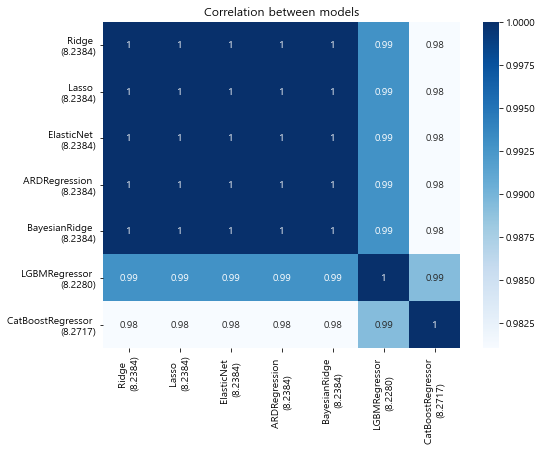

In [85]:
pred_results = []
for name, stk, stk_score in stks_trained:
    pred = list(stk.predict(S_dev))
    name = f'{name} \n({stk_score:.4f})'
    pred_results.append(pd.Series(pred, name=name))
ensemble_results = pd.concat(pred_results, axis=1)
ensemble_results = ensemble_results.applymap(lambda x: float(x))

# 모형의 예측값 간의 상관관계를 보기 위해 hitmap을 도식한다.
plt.figure(figsize = (8,6))
g = sns.heatmap(ensemble_results.corr(), annot=True, cmap='Blues')
g.set_title("Correlation between models")
plt.show()

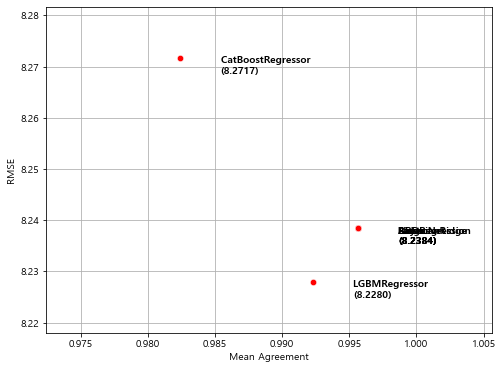

In [86]:
corr = (ensemble_results.corr().sum()-1)/(ensemble_results.corr().shape[0]-1)
names = corr.index
rmse = np.array(corr.index.str[-7:-1]).astype(float)
df = pd.DataFrame({'model': names, 'rmse': rmse, 'cor': corr})        

plt.figure(figsize=(8,6))
g = sns.scatterplot(x="cor", y="rmse", data=df, s=40, color='red')
for line in range(0, df.shape[0]):
     g.text(df.cor[line]+0.003, df.rmse[line]-0.003, 
            df.model[line], horizontalalignment='left', 
            size='medium', color='black', weight='semibold')
        
plt.xlim((df.cor.min()-0.01,df.cor.max()+0.01))
plt.ylim((df.rmse.min()-0.01,df.rmse.max()+0.01))
plt.xlabel('Mean Agreement')
plt.ylabel('RMSE')
plt.grid()
plt.show()

In [114]:
selected = [#'LinearRegression',
            'Ridge',
            #'Lasso',
            #'ElasticNet',
            #'ARDRegression',
            #'BayesianRidge',
            #'RandomForestRegressor',
            #'XGBRegressor',
            'LGBMRegressor',
            'CatBoostRegressor',
            #'DeepNeuralNetwork'
            ]
models_for_ensemble = [(name,reg) for name,reg,score in stks_trained if name in selected]
results_for_ensemble = []
weights_stk = []
rmse_best = 1000
for i in tqdm(range(1, 90, 1)):
    for j in range(1, 90, 1):
        for k in range(1, 90, 1):
            if (i+j+k) != 90:
                continue
            pred = (models_for_ensemble[0][1].predict(S_dev).flatten() * i + models_for_ensemble[1][1].predict(S_dev) * j
                    + models_for_ensemble[2][1].predict(S_dev) * k)/90
            rmse = np.sqrt(mean_squared_error(y_dev, pred))
            if rmse < rmse_best:
                weights_stk = [i,j,k]
                rmse_best = rmse 
                print(rmse, i,j,k)            

print(rmse_best, weights_stk)

  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

8.269152005266324 1 1 88
8.268044306746798 1 2 87
8.26695113563096 1 3 86
8.265872497682603 1 4 85
8.26480839859189 1 5 84
8.263758843975193 1 6 83
8.262723839374955 1 7 82
8.261703390259537 1 8 81
8.260697502023085 1 9 80
8.259706179985384 1 10 79
8.258729429391716 1 11 78
8.25776725541273 1 12 77
8.256819663144299 1 13 76
8.255886657607391 1 14 75
8.254968243747939 1 15 74
8.254064426436706 1 16 73
8.25317521046916 1 17 72
8.252300600565347 1 18 71
8.251440601369769 1 19 70
8.25059521745126 1 20 69
8.249764453302861 1 21 68
8.248948313341714 1 22 67
8.24814680190893 1 23 66
8.24735992326949 1 24 65
8.246587681612116 1 25 64
8.245830081049176 1 26 63
8.245087125616564 1 27 62
8.244358819273597 1 28 61
8.243645165902912 1 29 60
8.242946169310358 1 30 59
8.242261833224905 1 31 58
8.24159216129853 1 32 57
8.24093715710614 1 33 56
8.240296824145451 1 34 55
8.23967116583692 1 35 54
8.239060185523645 1 36 53
8.238463886471267 1 37 52
8.237882271867896 1 38 51
8.237315344824019 1 39 50
8.236

  1%|▉                                                                                  | 1/89 [00:03<04:41,  3.20s/it]

8.226668915235988 2 70 18
8.226588128159806 2 71 17
8.226522088240172 2 72 16
8.226470795832242 2 73 15
8.226434251211876 2 74 14
8.226412454575614 2 75 13
8.226405406040689 2 76 12


  2%|█▊                                                                                 | 2/89 [00:06<04:29,  3.09s/it]

8.22640345273025 3 69 18
8.226322883411466 3 70 17
8.226257061728615 3 71 16
8.226205988035703 3 72 15
8.226169662607427 3 73 14
8.226148085639164 3 74 13
8.226141257246972 3 75 12


  3%|██▊                                                                                | 3/89 [00:09<04:18,  3.00s/it]

8.226066494395196 4 69 17
8.226000891033822 4 70 16
8.225950036124763 4 71 15
8.225913929941555 4 72 14
8.225892572678411 4 73 13
8.225885964450208 4 74 12


  4%|███▋                                                                               | 4/89 [00:12<04:14,  2.99s/it]

8.225818961939064 5 68 17
8.22575357698317 5 69 16
8.225702940926105 5 70 15
8.225667054040244 5 71 14
8.225645916518632 5 72 13
8.22563952847497 5 73 12


  6%|████▋                                                                              | 5/89 [00:15<04:11,  3.00s/it]

8.225580286842629 6 67 17
8.225515120375528 6 68 16
8.225464703237902 6 69 15
8.225429035700968 6 70 14
8.225408117956595 6 71 13
8.225401950117316 6 72 12


  7%|█████▌                                                                             | 6/89 [00:17<04:04,  2.94s/it]

8.225350469876934 7 66 17
8.225285521981245 7 67 16
8.225235323829807 7 68 15
8.225199875692674 7 69 14
8.225179177760548 7 70 13
8.225173230144785 7 71 12


  8%|██████▌                                                                            | 7/89 [00:20<04:01,  2.94s/it]

8.225129511784491 8 65 17
8.22506478254214 8 66 16
8.225014803442942 8 67 15
8.224979574755785 8 68 14
8.224959096670206 8 69 13
8.224953369296381 8 70 12


  9%|███████▍                                                                           | 8/89 [00:23<03:58,  2.94s/it]

8.224917413279266 9 64 17
8.224852902771483 9 65 16
8.224803142789877 9 66 15
8.224768133602174 9 67 14
8.224747875396735 9 68 13
8.224742368282561 9 69 12


 10%|████████▍                                                                          | 9/89 [00:26<03:54,  2.93s/it]

8.224714175046671 10 63 17
8.224649883353992 10 64 16
8.224600342554634 10 65 15
8.224565552915154 10 66 14
8.224545514622744 10 67 13
8.224540227785221 10 68 12


 11%|█████████▏                                                                        | 10/89 [00:29<03:44,  2.84s/it]

8.224519797743552 11 62 17
8.224455724945816 11 63 16
8.22440640339266 11 64 15
8.22437183334947 11 65 14
8.22435201500227 11 66 13
8.224346948457693 11 67 12


 12%|██████████▏                                                                       | 11/89 [00:31<03:34,  2.76s/it]

8.224334281998177 12 61 17
8.22427042817453 12 62 16
8.224221325930827 12 63 15
8.224186975531294 12 64 14
8.224167377160773 12 65 13
8.224162530924728 12 66 12


 13%|███████████                                                                       | 12/89 [00:34<03:27,  2.69s/it]

8.224157628410225 13 60 17
8.224093993639112 13 61 16
8.224045110767419 13 62 15
8.2240109800582 13 63 14
8.223991601695127 13 64 13
8.223986975782482 13 65 12


 15%|███████████▉                                                                      | 13/89 [00:36<03:20,  2.64s/it]

8.223926421909951 14 60 16
8.223877758472117 14 61 15
8.22384384749917 14 62 14
8.223824689173602 14 63 13
8.223820283598517 14 64 12


 16%|████████████▉                                                                     | 14/89 [00:39<03:14,  2.59s/it]

8.223767713528828 15 59 16
8.223719269586002 15 60 15
8.223685578394573 15 61 14
8.22366664013586 15 62 13
8.223662454911786 15 63 12


 17%|█████████████▊                                                                    | 15/89 [00:41<03:09,  2.56s/it]

8.223617869008903 16 58 16
8.22356964462153 16 59 15
8.223536173256166 16 60 14
8.223517455092948 16 61 13
8.223513490232623 16 62 12


 18%|██████████████▋                                                                   | 16/89 [00:44<03:05,  2.55s/it]

8.223476888834718 17 57 16
8.223428884062542 17 58 15
8.223395632567078 17 59 14
8.223377134527286 17 60 13
8.223373390042735 17 61 12


 19%|███████████████▋                                                                  | 17/89 [00:46<03:03,  2.54s/it]

8.22334477346218 18 56 16
8.223296988364238 18 57 15
8.223263956781803 18 58 14
8.223245678892663 18 59 13
8.223242154795198 18 60 12


 20%|████████████████▌                                                                 | 18/89 [00:49<02:57,  2.50s/it]

8.223221523318562 19 55 16
8.223173957953183 19 56 15
8.223141146326201 19 57 14
8.223123088614225 19 58 13
8.22311978491445 19 59 12


 21%|█████████████████▌                                                                | 19/89 [00:51<02:53,  2.48s/it]

8.223107138802483 20 54 16
8.223059793227296 20 55 15
8.223027201597482 20 56 14
8.22300936408847 20 57 13
8.223006280796277 20 58 12


 22%|██████████████████▍                                                               | 20/89 [00:54<02:47,  2.42s/it]

8.223001620283915 21 53 16
8.222954494555841 21 54 15
8.2229221229642 21 55 14
8.222904505683246 21 56 13
8.222901642807809 21 57 12


 24%|███████████████████▎                                                              | 21/89 [00:56<02:41,  2.37s/it]

8.222858062279421 22 53 15
8.222825910766254 22 54 14
8.222808513737737 22 55 13
8.222805871287523 22 56 12


 25%|████████████████████▎                                                             | 22/89 [00:58<02:35,  2.32s/it]

8.22277049670998 23 52 15
8.222738565314874 23 53 14
8.222721388562466 23 54 13
8.222718966545226 23 55 12


 26%|█████████████████████▏                                                            | 23/89 [01:00<02:31,  2.29s/it]

8.222691798130791 24 51 15
8.22266008689262 24 52 14
8.222643130439282 24 53 13
8.222640928862056 24 54 12


 27%|██████████████████████                                                            | 24/89 [01:03<02:28,  2.29s/it]

8.222621966796446 25 50 15
8.222590475753384 25 51 14
8.22257373962136 25 52 13
8.222571758490476 25 53 12


 28%|███████████████████████                                                           | 25/89 [01:05<02:27,  2.30s/it]

8.222561002932869 26 49 15
8.222529732122371 26 50 14
8.222513216333201 26 51 13
8.222511455654269 26 52 12


 29%|███████████████████████▉                                                          | 26/89 [01:07<02:28,  2.36s/it]

8.222508906737296 27 48 15
8.22247785619611 27 49 14
8.222461560770613 27 50 13
8.222460020548539 27 51 12


 30%|████████████████████████▉                                                         | 27/89 [01:10<02:24,  2.32s/it]

8.222434848142438 28 48 14
8.222418773100731 28 49 13
8.222417453339698 28 50 12


 31%|█████████████████████████▊                                                        | 28/89 [01:12<02:18,  2.27s/it]

8.222400708100512 29 47 14
8.222384853461993 29 48 13
8.222383754165476 29 49 12


 33%|██████████████████████████▋                                                       | 29/89 [01:14<02:14,  2.24s/it]

8.222375436180792 30 46 14
8.222359801964146 30 47 13
8.222358923134905 30 48 12


 34%|███████████████████████████▋                                                      | 30/89 [01:16<02:08,  2.18s/it]

8.22234361868825 31 46 13
8.222342960328335 31 47 12


 35%|████████████████████████████▌                                                     | 31/89 [01:18<02:04,  2.14s/it]

8.222336303686667 32 45 13
8.222335865797412 32 46 12


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [02:19<00:00,  1.56s/it]

8.222335865797412 [32, 46, 12]


3-layered

In [96]:
selected = [#'LinearRegression',
            'Ridge',
            #'Lasso',
            #'ElasticNet',
            #'ARDRegression',
            #'BayesianRidge',
            #'RandomForestRegressor',
            #'XGBRegressor',
            'LGBMRegressor',
            'CatBoostRegressor'
            ]
tri_stack_estimators = [reg for name,reg,score in stks_trained if name in selected]

In [97]:
S3_train, S3_test = stacking(tri_stack_estimators,
                           x_train, y_train, x_test,
                           regression=True, n_folds=5, stratified=True, shuffle=True,
                           random_state=0, verbose=0)

Learning rate set to 0.064809
0:	learn: 10.2686787	total: 45.9ms	remaining: 45.8s
1:	learn: 10.1258506	total: 91.2ms	remaining: 45.5s
2:	learn: 9.9894234	total: 146ms	remaining: 48.6s
3:	learn: 9.8760133	total: 191ms	remaining: 47.5s
4:	learn: 9.7568511	total: 260ms	remaining: 51.7s
5:	learn: 9.6536846	total: 317ms	remaining: 52.6s
6:	learn: 9.5705909	total: 363ms	remaining: 51.5s
7:	learn: 9.4913745	total: 416ms	remaining: 51.5s
8:	learn: 9.4108023	total: 464ms	remaining: 51s
9:	learn: 9.3420142	total: 517ms	remaining: 51.2s
10:	learn: 9.2761454	total: 569ms	remaining: 51.1s
11:	learn: 9.2131643	total: 621ms	remaining: 51.1s
12:	learn: 9.1582612	total: 671ms	remaining: 51s
13:	learn: 9.1030783	total: 736ms	remaining: 51.8s
14:	learn: 9.0559814	total: 789ms	remaining: 51.8s
15:	learn: 9.0163014	total: 837ms	remaining: 51.5s
16:	learn: 8.9711958	total: 884ms	remaining: 51.1s
17:	learn: 8.9360133	total: 927ms	remaining: 50.6s
18:	learn: 8.9017185	total: 978ms	remaining: 50.5s
19:	learn: 

162:	learn: 7.8515193	total: 8.25s	remaining: 42.4s
163:	learn: 7.8471874	total: 8.3s	remaining: 42.3s
164:	learn: 7.8437746	total: 8.34s	remaining: 42.2s
165:	learn: 7.8395267	total: 8.39s	remaining: 42.2s
166:	learn: 7.8359496	total: 8.44s	remaining: 42.1s
167:	learn: 7.8315702	total: 8.49s	remaining: 42s
168:	learn: 7.8277816	total: 8.55s	remaining: 42s
169:	learn: 7.8243666	total: 8.6s	remaining: 42s
170:	learn: 7.8199107	total: 8.65s	remaining: 41.9s
171:	learn: 7.8151027	total: 8.7s	remaining: 41.9s
172:	learn: 7.8116097	total: 8.75s	remaining: 41.8s
173:	learn: 7.8067795	total: 8.82s	remaining: 41.9s
174:	learn: 7.8025661	total: 8.9s	remaining: 42s
175:	learn: 7.7977170	total: 8.97s	remaining: 42s
176:	learn: 7.7926898	total: 9.03s	remaining: 42s
177:	learn: 7.7893370	total: 9.1s	remaining: 42s
178:	learn: 7.7845326	total: 9.15s	remaining: 42s
179:	learn: 7.7808473	total: 9.19s	remaining: 41.9s
180:	learn: 7.7780986	total: 9.24s	remaining: 41.8s
181:	learn: 7.7737628	total: 9.29

323:	learn: 7.2254108	total: 16.5s	remaining: 34.4s
324:	learn: 7.2217808	total: 16.6s	remaining: 34.4s
325:	learn: 7.2195026	total: 16.6s	remaining: 34.3s
326:	learn: 7.2163138	total: 16.6s	remaining: 34.2s
327:	learn: 7.2130132	total: 16.7s	remaining: 34.2s
328:	learn: 7.2095344	total: 16.7s	remaining: 34.1s
329:	learn: 7.2061884	total: 16.8s	remaining: 34.1s
330:	learn: 7.2017176	total: 16.8s	remaining: 34s
331:	learn: 7.1988572	total: 16.9s	remaining: 34s
332:	learn: 7.1952803	total: 16.9s	remaining: 33.9s
333:	learn: 7.1916629	total: 17s	remaining: 33.8s
334:	learn: 7.1889112	total: 17s	remaining: 33.8s
335:	learn: 7.1856572	total: 17.1s	remaining: 33.7s
336:	learn: 7.1806501	total: 17.1s	remaining: 33.6s
337:	learn: 7.1766154	total: 17.1s	remaining: 33.6s
338:	learn: 7.1742345	total: 17.2s	remaining: 33.5s
339:	learn: 7.1710478	total: 17.2s	remaining: 33.4s
340:	learn: 7.1677693	total: 17.3s	remaining: 33.4s
341:	learn: 7.1644086	total: 17.3s	remaining: 33.3s
342:	learn: 7.160703

485:	learn: 6.7142937	total: 24.1s	remaining: 25.5s
486:	learn: 6.7103384	total: 24.1s	remaining: 25.4s
487:	learn: 6.7075160	total: 24.2s	remaining: 25.4s
488:	learn: 6.7043439	total: 24.2s	remaining: 25.3s
489:	learn: 6.7024232	total: 24.3s	remaining: 25.3s
490:	learn: 6.6998191	total: 24.3s	remaining: 25.2s
491:	learn: 6.6972749	total: 24.4s	remaining: 25.1s
492:	learn: 6.6936846	total: 24.4s	remaining: 25.1s
493:	learn: 6.6904782	total: 24.4s	remaining: 25s
494:	learn: 6.6869956	total: 24.5s	remaining: 25s
495:	learn: 6.6832003	total: 24.5s	remaining: 24.9s
496:	learn: 6.6804692	total: 24.6s	remaining: 24.9s
497:	learn: 6.6785881	total: 24.6s	remaining: 24.8s
498:	learn: 6.6755506	total: 24.7s	remaining: 24.8s
499:	learn: 6.6722472	total: 24.7s	remaining: 24.7s
500:	learn: 6.6687369	total: 24.8s	remaining: 24.7s
501:	learn: 6.6661056	total: 24.9s	remaining: 24.7s
502:	learn: 6.6635607	total: 24.9s	remaining: 24.6s
503:	learn: 6.6607861	total: 24.9s	remaining: 24.5s
504:	learn: 6.65

647:	learn: 6.2638379	total: 31.5s	remaining: 17.1s
648:	learn: 6.2611331	total: 31.5s	remaining: 17.1s
649:	learn: 6.2592681	total: 31.6s	remaining: 17s
650:	learn: 6.2558973	total: 31.6s	remaining: 16.9s
651:	learn: 6.2536014	total: 31.7s	remaining: 16.9s
652:	learn: 6.2509722	total: 31.7s	remaining: 16.8s
653:	learn: 6.2485425	total: 31.7s	remaining: 16.8s
654:	learn: 6.2474305	total: 31.8s	remaining: 16.7s
655:	learn: 6.2453253	total: 31.8s	remaining: 16.7s
656:	learn: 6.2429032	total: 31.9s	remaining: 16.6s
657:	learn: 6.2406120	total: 31.9s	remaining: 16.6s
658:	learn: 6.2383490	total: 32s	remaining: 16.6s
659:	learn: 6.2358098	total: 32s	remaining: 16.5s
660:	learn: 6.2333247	total: 32.1s	remaining: 16.5s
661:	learn: 6.2314207	total: 32.1s	remaining: 16.4s
662:	learn: 6.2286663	total: 32.2s	remaining: 16.4s
663:	learn: 6.2267499	total: 32.2s	remaining: 16.3s
664:	learn: 6.2234607	total: 32.3s	remaining: 16.3s
665:	learn: 6.2215148	total: 32.3s	remaining: 16.2s
666:	learn: 6.2204

808:	learn: 5.8725182	total: 38.9s	remaining: 9.18s
809:	learn: 5.8702005	total: 38.9s	remaining: 9.13s
810:	learn: 5.8677019	total: 39s	remaining: 9.08s
811:	learn: 5.8647017	total: 39s	remaining: 9.03s
812:	learn: 5.8623872	total: 39.1s	remaining: 8.98s
813:	learn: 5.8597280	total: 39.1s	remaining: 8.94s
814:	learn: 5.8572329	total: 39.2s	remaining: 8.89s
815:	learn: 5.8550142	total: 39.2s	remaining: 8.84s
816:	learn: 5.8533265	total: 39.2s	remaining: 8.79s
817:	learn: 5.8510702	total: 39.3s	remaining: 8.74s
818:	learn: 5.8492591	total: 39.3s	remaining: 8.69s
819:	learn: 5.8463935	total: 39.4s	remaining: 8.64s
820:	learn: 5.8441418	total: 39.4s	remaining: 8.59s
821:	learn: 5.8423284	total: 39.5s	remaining: 8.54s
822:	learn: 5.8394656	total: 39.5s	remaining: 8.49s
823:	learn: 5.8368134	total: 39.6s	remaining: 8.45s
824:	learn: 5.8341317	total: 39.6s	remaining: 8.4s
825:	learn: 5.8321551	total: 39.6s	remaining: 8.35s
826:	learn: 5.8300592	total: 39.7s	remaining: 8.3s
827:	learn: 5.8275

968:	learn: 5.5011881	total: 46.2s	remaining: 1.48s
969:	learn: 5.4996050	total: 46.3s	remaining: 1.43s
970:	learn: 5.4979655	total: 46.3s	remaining: 1.38s
971:	learn: 5.4960596	total: 46.3s	remaining: 1.33s
972:	learn: 5.4942448	total: 46.4s	remaining: 1.29s
973:	learn: 5.4915377	total: 46.4s	remaining: 1.24s
974:	learn: 5.4890098	total: 46.5s	remaining: 1.19s
975:	learn: 5.4877212	total: 46.5s	remaining: 1.14s
976:	learn: 5.4855492	total: 46.6s	remaining: 1.09s
977:	learn: 5.4827782	total: 46.6s	remaining: 1.05s
978:	learn: 5.4809271	total: 46.6s	remaining: 1s
979:	learn: 5.4787888	total: 46.7s	remaining: 953ms
980:	learn: 5.4761889	total: 46.8s	remaining: 905ms
981:	learn: 5.4740855	total: 46.8s	remaining: 858ms
982:	learn: 5.4726401	total: 46.8s	remaining: 810ms
983:	learn: 5.4705760	total: 46.9s	remaining: 762ms
984:	learn: 5.4688579	total: 46.9s	remaining: 715ms
985:	learn: 5.4666194	total: 47s	remaining: 667ms
986:	learn: 5.4655063	total: 47s	remaining: 619ms
987:	learn: 5.46328

131:	learn: 8.0083475	total: 6.27s	remaining: 41.2s
132:	learn: 8.0041971	total: 6.31s	remaining: 41.1s
133:	learn: 8.0006755	total: 6.35s	remaining: 41.1s
134:	learn: 7.9964458	total: 6.4s	remaining: 41s
135:	learn: 7.9933366	total: 6.44s	remaining: 40.9s
136:	learn: 7.9909236	total: 6.49s	remaining: 40.9s
137:	learn: 7.9860526	total: 6.54s	remaining: 40.9s
138:	learn: 7.9816311	total: 6.59s	remaining: 40.8s
139:	learn: 7.9778464	total: 6.64s	remaining: 40.8s
140:	learn: 7.9747250	total: 6.69s	remaining: 40.7s
141:	learn: 7.9714558	total: 6.73s	remaining: 40.7s
142:	learn: 7.9689684	total: 6.77s	remaining: 40.6s
143:	learn: 7.9652827	total: 6.81s	remaining: 40.5s
144:	learn: 7.9614719	total: 6.86s	remaining: 40.5s
145:	learn: 7.9580548	total: 6.9s	remaining: 40.4s
146:	learn: 7.9544166	total: 6.95s	remaining: 40.3s
147:	learn: 7.9508076	total: 6.99s	remaining: 40.3s
148:	learn: 7.9463702	total: 7.03s	remaining: 40.2s
149:	learn: 7.9429143	total: 7.08s	remaining: 40.1s
150:	learn: 7.93

293:	learn: 7.3704069	total: 14.3s	remaining: 34.3s
294:	learn: 7.3663347	total: 14.3s	remaining: 34.3s
295:	learn: 7.3617469	total: 14.4s	remaining: 34.2s
296:	learn: 7.3581363	total: 14.4s	remaining: 34.2s
297:	learn: 7.3536105	total: 14.5s	remaining: 34.1s
298:	learn: 7.3497203	total: 14.5s	remaining: 34.1s
299:	learn: 7.3464282	total: 14.6s	remaining: 34s
300:	learn: 7.3424021	total: 14.6s	remaining: 34s
301:	learn: 7.3392849	total: 14.7s	remaining: 34s
302:	learn: 7.3352782	total: 14.8s	remaining: 33.9s
303:	learn: 7.3310448	total: 14.8s	remaining: 33.9s
304:	learn: 7.3276231	total: 14.9s	remaining: 33.9s
305:	learn: 7.3236038	total: 14.9s	remaining: 33.9s
306:	learn: 7.3201901	total: 15s	remaining: 33.8s
307:	learn: 7.3169492	total: 15s	remaining: 33.7s
308:	learn: 7.3141656	total: 15.1s	remaining: 33.7s
309:	learn: 7.3103558	total: 15.1s	remaining: 33.6s
310:	learn: 7.3076125	total: 15.2s	remaining: 33.6s
311:	learn: 7.3049437	total: 15.2s	remaining: 33.6s
312:	learn: 7.3013302	

454:	learn: 6.8347863	total: 22.4s	remaining: 26.8s
455:	learn: 6.8322177	total: 22.4s	remaining: 26.8s
456:	learn: 6.8297558	total: 22.5s	remaining: 26.7s
457:	learn: 6.8263929	total: 22.5s	remaining: 26.6s
458:	learn: 6.8238313	total: 22.6s	remaining: 26.6s
459:	learn: 6.8215101	total: 22.6s	remaining: 26.5s
460:	learn: 6.8189239	total: 22.6s	remaining: 26.5s
461:	learn: 6.8160009	total: 22.7s	remaining: 26.4s
462:	learn: 6.8119839	total: 22.7s	remaining: 26.4s
463:	learn: 6.8091115	total: 22.8s	remaining: 26.3s
464:	learn: 6.8068234	total: 22.8s	remaining: 26.3s
465:	learn: 6.8042772	total: 22.9s	remaining: 26.2s
466:	learn: 6.8009947	total: 22.9s	remaining: 26.2s
467:	learn: 6.7982756	total: 23s	remaining: 26.1s
468:	learn: 6.7949995	total: 23.1s	remaining: 26.1s
469:	learn: 6.7915112	total: 23.1s	remaining: 26.1s
470:	learn: 6.7879230	total: 23.2s	remaining: 26s
471:	learn: 6.7854966	total: 23.2s	remaining: 26s
472:	learn: 6.7824261	total: 23.3s	remaining: 25.9s
473:	learn: 6.7787

617:	learn: 6.3789294	total: 30.9s	remaining: 19.1s
618:	learn: 6.3758945	total: 31s	remaining: 19.1s
619:	learn: 6.3718137	total: 31.1s	remaining: 19s
620:	learn: 6.3692917	total: 31.1s	remaining: 19s
621:	learn: 6.3667437	total: 31.2s	remaining: 18.9s
622:	learn: 6.3637674	total: 31.2s	remaining: 18.9s
623:	learn: 6.3608553	total: 31.3s	remaining: 18.8s
624:	learn: 6.3579357	total: 31.3s	remaining: 18.8s
625:	learn: 6.3552755	total: 31.4s	remaining: 18.7s
626:	learn: 6.3528858	total: 31.4s	remaining: 18.7s
627:	learn: 6.3503649	total: 31.4s	remaining: 18.6s
628:	learn: 6.3474483	total: 31.5s	remaining: 18.6s
629:	learn: 6.3439212	total: 31.5s	remaining: 18.5s
630:	learn: 6.3409011	total: 31.6s	remaining: 18.5s
631:	learn: 6.3383706	total: 31.6s	remaining: 18.4s
632:	learn: 6.3348133	total: 31.7s	remaining: 18.4s
633:	learn: 6.3323721	total: 31.8s	remaining: 18.3s
634:	learn: 6.3302134	total: 31.8s	remaining: 18.3s
635:	learn: 6.3281119	total: 31.9s	remaining: 18.2s
636:	learn: 6.3257

777:	learn: 5.9665217	total: 39.3s	remaining: 11.2s
778:	learn: 5.9643214	total: 39.3s	remaining: 11.2s
779:	learn: 5.9627790	total: 39.4s	remaining: 11.1s
780:	learn: 5.9601533	total: 39.4s	remaining: 11.1s
781:	learn: 5.9575128	total: 39.5s	remaining: 11s
782:	learn: 5.9552714	total: 39.5s	remaining: 11s
783:	learn: 5.9530553	total: 39.6s	remaining: 10.9s
784:	learn: 5.9508281	total: 39.6s	remaining: 10.9s
785:	learn: 5.9487316	total: 39.7s	remaining: 10.8s
786:	learn: 5.9461197	total: 39.7s	remaining: 10.8s
787:	learn: 5.9431059	total: 39.8s	remaining: 10.7s
788:	learn: 5.9402280	total: 39.8s	remaining: 10.7s
789:	learn: 5.9381108	total: 39.9s	remaining: 10.6s
790:	learn: 5.9350634	total: 40s	remaining: 10.6s
791:	learn: 5.9330629	total: 40s	remaining: 10.5s
792:	learn: 5.9311738	total: 40.1s	remaining: 10.5s
793:	learn: 5.9295114	total: 40.1s	remaining: 10.4s
794:	learn: 5.9270865	total: 40.2s	remaining: 10.4s
795:	learn: 5.9249892	total: 40.3s	remaining: 10.3s
796:	learn: 5.922069

939:	learn: 5.5971530	total: 47.9s	remaining: 3.06s
940:	learn: 5.5955279	total: 47.9s	remaining: 3s
941:	learn: 5.5937606	total: 48s	remaining: 2.95s
942:	learn: 5.5910880	total: 48s	remaining: 2.9s
943:	learn: 5.5896948	total: 48.1s	remaining: 2.85s
944:	learn: 5.5871756	total: 48.2s	remaining: 2.8s
945:	learn: 5.5845005	total: 48.2s	remaining: 2.75s
946:	learn: 5.5817436	total: 48.3s	remaining: 2.7s
947:	learn: 5.5794615	total: 48.3s	remaining: 2.65s
948:	learn: 5.5769856	total: 48.4s	remaining: 2.6s
949:	learn: 5.5741269	total: 48.4s	remaining: 2.55s
950:	learn: 5.5716576	total: 48.5s	remaining: 2.5s
951:	learn: 5.5696433	total: 48.5s	remaining: 2.44s
952:	learn: 5.5667903	total: 48.5s	remaining: 2.39s
953:	learn: 5.5647926	total: 48.6s	remaining: 2.34s
954:	learn: 5.5627867	total: 48.7s	remaining: 2.29s
955:	learn: 5.5611064	total: 48.7s	remaining: 2.24s
956:	learn: 5.5585557	total: 48.8s	remaining: 2.19s
957:	learn: 5.5567315	total: 48.9s	remaining: 2.14s
958:	learn: 5.5537245	to

100:	learn: 8.1261972	total: 5.37s	remaining: 47.8s
101:	learn: 8.1224980	total: 5.42s	remaining: 47.7s
102:	learn: 8.1183363	total: 5.47s	remaining: 47.6s
103:	learn: 8.1145292	total: 5.53s	remaining: 47.6s
104:	learn: 8.1107955	total: 5.58s	remaining: 47.6s
105:	learn: 8.1059565	total: 5.64s	remaining: 47.6s
106:	learn: 8.1014906	total: 5.7s	remaining: 47.6s
107:	learn: 8.0976873	total: 5.76s	remaining: 47.6s
108:	learn: 8.0927551	total: 5.81s	remaining: 47.5s
109:	learn: 8.0895967	total: 5.86s	remaining: 47.4s
110:	learn: 8.0844438	total: 5.94s	remaining: 47.5s
111:	learn: 8.0805215	total: 5.99s	remaining: 47.5s
112:	learn: 8.0766559	total: 6.05s	remaining: 47.5s
113:	learn: 8.0733897	total: 6.1s	remaining: 47.4s
114:	learn: 8.0706470	total: 6.15s	remaining: 47.3s
115:	learn: 8.0657464	total: 6.2s	remaining: 47.2s
116:	learn: 8.0630961	total: 6.26s	remaining: 47.2s
117:	learn: 8.0595581	total: 6.32s	remaining: 47.2s
118:	learn: 8.0565287	total: 6.37s	remaining: 47.1s
119:	learn: 8.0

262:	learn: 7.4857702	total: 14.1s	remaining: 39.6s
263:	learn: 7.4815353	total: 14.2s	remaining: 39.5s
264:	learn: 7.4783176	total: 14.2s	remaining: 39.5s
265:	learn: 7.4742555	total: 14.3s	remaining: 39.4s
266:	learn: 7.4700098	total: 14.3s	remaining: 39.3s
267:	learn: 7.4674791	total: 14.4s	remaining: 39.3s
268:	learn: 7.4646193	total: 14.4s	remaining: 39.2s
269:	learn: 7.4601344	total: 14.5s	remaining: 39.1s
270:	learn: 7.4560952	total: 14.5s	remaining: 39.1s
271:	learn: 7.4538456	total: 14.6s	remaining: 39s
272:	learn: 7.4491712	total: 14.6s	remaining: 39s
273:	learn: 7.4466499	total: 14.7s	remaining: 38.9s
274:	learn: 7.4416662	total: 14.7s	remaining: 38.8s
275:	learn: 7.4383265	total: 14.8s	remaining: 38.8s
276:	learn: 7.4341288	total: 14.8s	remaining: 38.7s
277:	learn: 7.4313664	total: 14.9s	remaining: 38.7s
278:	learn: 7.4283117	total: 14.9s	remaining: 38.6s
279:	learn: 7.4240204	total: 15s	remaining: 38.6s
280:	learn: 7.4195318	total: 15.1s	remaining: 38.5s
281:	learn: 7.4152

421:	learn: 6.9362778	total: 22.4s	remaining: 30.6s
422:	learn: 6.9328139	total: 22.4s	remaining: 30.6s
423:	learn: 6.9292542	total: 22.5s	remaining: 30.5s
424:	learn: 6.9260807	total: 22.5s	remaining: 30.5s
425:	learn: 6.9228944	total: 22.6s	remaining: 30.4s
426:	learn: 6.9204687	total: 22.6s	remaining: 30.3s
427:	learn: 6.9170933	total: 22.7s	remaining: 30.3s
428:	learn: 6.9135288	total: 22.7s	remaining: 30.2s
429:	learn: 6.9098816	total: 22.8s	remaining: 30.2s
430:	learn: 6.9070969	total: 22.8s	remaining: 30.1s
431:	learn: 6.9027881	total: 22.9s	remaining: 30.1s
432:	learn: 6.8990439	total: 22.9s	remaining: 30s
433:	learn: 6.8959663	total: 23s	remaining: 30s
434:	learn: 6.8924384	total: 23.1s	remaining: 30s
435:	learn: 6.8898769	total: 23.1s	remaining: 29.9s
436:	learn: 6.8873505	total: 23.2s	remaining: 29.9s
437:	learn: 6.8841809	total: 23.2s	remaining: 29.8s
438:	learn: 6.8816289	total: 23.3s	remaining: 29.7s
439:	learn: 6.8783839	total: 23.3s	remaining: 29.7s
440:	learn: 6.875541

583:	learn: 6.4577768	total: 31.6s	remaining: 22.5s
584:	learn: 6.4550781	total: 31.6s	remaining: 22.4s
585:	learn: 6.4530966	total: 31.7s	remaining: 22.4s
586:	learn: 6.4504085	total: 31.7s	remaining: 22.3s
587:	learn: 6.4487234	total: 31.8s	remaining: 22.3s
588:	learn: 6.4460031	total: 31.8s	remaining: 22.2s
589:	learn: 6.4429991	total: 31.9s	remaining: 22.2s
590:	learn: 6.4400619	total: 31.9s	remaining: 22.1s
591:	learn: 6.4382120	total: 32s	remaining: 22s
592:	learn: 6.4361252	total: 32s	remaining: 22s
593:	learn: 6.4338612	total: 32.1s	remaining: 21.9s
594:	learn: 6.4308375	total: 32.1s	remaining: 21.9s
595:	learn: 6.4273579	total: 32.2s	remaining: 21.8s
596:	learn: 6.4248397	total: 32.2s	remaining: 21.8s
597:	learn: 6.4217725	total: 32.3s	remaining: 21.7s
598:	learn: 6.4178876	total: 32.3s	remaining: 21.7s
599:	learn: 6.4144118	total: 32.4s	remaining: 21.6s
600:	learn: 6.4109726	total: 32.5s	remaining: 21.5s
601:	learn: 6.4090779	total: 32.5s	remaining: 21.5s
602:	learn: 6.406674

746:	learn: 6.0485159	total: 40.3s	remaining: 13.7s
747:	learn: 6.0458829	total: 40.4s	remaining: 13.6s
748:	learn: 6.0440621	total: 40.4s	remaining: 13.6s
749:	learn: 6.0417347	total: 40.5s	remaining: 13.5s
750:	learn: 6.0394451	total: 40.5s	remaining: 13.4s
751:	learn: 6.0371701	total: 40.6s	remaining: 13.4s
752:	learn: 6.0342998	total: 40.6s	remaining: 13.3s
753:	learn: 6.0323763	total: 40.7s	remaining: 13.3s
754:	learn: 6.0291911	total: 40.7s	remaining: 13.2s
755:	learn: 6.0269631	total: 40.8s	remaining: 13.2s
756:	learn: 6.0242735	total: 40.8s	remaining: 13.1s
757:	learn: 6.0216977	total: 40.9s	remaining: 13s
758:	learn: 6.0189355	total: 40.9s	remaining: 13s
759:	learn: 6.0167128	total: 41s	remaining: 12.9s
760:	learn: 6.0138337	total: 41s	remaining: 12.9s
761:	learn: 6.0114854	total: 41.1s	remaining: 12.8s
762:	learn: 6.0092277	total: 41.1s	remaining: 12.8s
763:	learn: 6.0056879	total: 41.2s	remaining: 12.7s
764:	learn: 6.0030035	total: 41.2s	remaining: 12.7s
765:	learn: 6.000700

906:	learn: 5.6748295	total: 48.1s	remaining: 4.93s
907:	learn: 5.6729706	total: 48.2s	remaining: 4.88s
908:	learn: 5.6701710	total: 48.2s	remaining: 4.83s
909:	learn: 5.6678709	total: 48.3s	remaining: 4.77s
910:	learn: 5.6655419	total: 48.3s	remaining: 4.72s
911:	learn: 5.6630994	total: 48.4s	remaining: 4.67s
912:	learn: 5.6610499	total: 48.4s	remaining: 4.61s
913:	learn: 5.6583192	total: 48.5s	remaining: 4.56s
914:	learn: 5.6567981	total: 48.5s	remaining: 4.51s
915:	learn: 5.6547288	total: 48.6s	remaining: 4.45s
916:	learn: 5.6527112	total: 48.6s	remaining: 4.4s
917:	learn: 5.6496125	total: 48.7s	remaining: 4.35s
918:	learn: 5.6479132	total: 48.7s	remaining: 4.29s
919:	learn: 5.6448182	total: 48.8s	remaining: 4.24s
920:	learn: 5.6428660	total: 48.8s	remaining: 4.19s
921:	learn: 5.6401905	total: 48.9s	remaining: 4.13s
922:	learn: 5.6379520	total: 48.9s	remaining: 4.08s
923:	learn: 5.6357492	total: 49s	remaining: 4.03s
924:	learn: 5.6331371	total: 49s	remaining: 3.97s
925:	learn: 5.630

69:	learn: 8.2284442	total: 4.26s	remaining: 56.6s
70:	learn: 8.2223825	total: 4.32s	remaining: 56.5s
71:	learn: 8.2169943	total: 4.38s	remaining: 56.4s
72:	learn: 8.2109519	total: 4.43s	remaining: 56.3s
73:	learn: 8.2046984	total: 4.5s	remaining: 56.3s
74:	learn: 8.2000707	total: 4.56s	remaining: 56.3s
75:	learn: 8.1943903	total: 4.62s	remaining: 56.2s
76:	learn: 8.1888580	total: 4.68s	remaining: 56.1s
77:	learn: 8.1842573	total: 4.74s	remaining: 56s
78:	learn: 8.1787000	total: 4.79s	remaining: 55.9s
79:	learn: 8.1733693	total: 4.85s	remaining: 55.8s
80:	learn: 8.1684905	total: 4.9s	remaining: 55.6s
81:	learn: 8.1646784	total: 4.96s	remaining: 55.5s
82:	learn: 8.1606068	total: 5.02s	remaining: 55.4s
83:	learn: 8.1556071	total: 5.08s	remaining: 55.4s
84:	learn: 8.1517503	total: 5.13s	remaining: 55.3s
85:	learn: 8.1461695	total: 5.19s	remaining: 55.2s
86:	learn: 8.1420340	total: 5.24s	remaining: 55s
87:	learn: 8.1380388	total: 5.3s	remaining: 54.9s
88:	learn: 8.1327117	total: 5.36s	rema

229:	learn: 7.5566374	total: 14.5s	remaining: 48.4s
230:	learn: 7.5529621	total: 14.5s	remaining: 48.3s
231:	learn: 7.5476736	total: 14.6s	remaining: 48.3s
232:	learn: 7.5449232	total: 14.6s	remaining: 48.2s
233:	learn: 7.5408998	total: 14.7s	remaining: 48.1s
234:	learn: 7.5384003	total: 14.8s	remaining: 48s
235:	learn: 7.5358192	total: 14.8s	remaining: 47.9s
236:	learn: 7.5329512	total: 14.9s	remaining: 47.8s
237:	learn: 7.5282404	total: 14.9s	remaining: 47.8s
238:	learn: 7.5252093	total: 15s	remaining: 47.7s
239:	learn: 7.5208237	total: 15s	remaining: 47.7s
240:	learn: 7.5174506	total: 15.1s	remaining: 47.6s
241:	learn: 7.5134786	total: 15.2s	remaining: 47.5s
242:	learn: 7.5099889	total: 15.2s	remaining: 47.5s
243:	learn: 7.5057373	total: 15.3s	remaining: 47.4s
244:	learn: 7.5021983	total: 15.4s	remaining: 47.3s
245:	learn: 7.4970965	total: 15.4s	remaining: 47.3s
246:	learn: 7.4926119	total: 15.5s	remaining: 47.2s
247:	learn: 7.4884997	total: 15.5s	remaining: 47.1s
248:	learn: 7.4837

389:	learn: 6.9920449	total: 23.1s	remaining: 36.2s
390:	learn: 6.9892353	total: 23.2s	remaining: 36.1s
391:	learn: 6.9850133	total: 23.2s	remaining: 36s
392:	learn: 6.9821951	total: 23.3s	remaining: 35.9s
393:	learn: 6.9798874	total: 23.3s	remaining: 35.9s
394:	learn: 6.9770533	total: 23.4s	remaining: 35.8s
395:	learn: 6.9738036	total: 23.4s	remaining: 35.8s
396:	learn: 6.9703581	total: 23.5s	remaining: 35.7s
397:	learn: 6.9668451	total: 23.6s	remaining: 35.6s
398:	learn: 6.9626982	total: 23.6s	remaining: 35.6s
399:	learn: 6.9604234	total: 23.7s	remaining: 35.5s
400:	learn: 6.9568254	total: 23.7s	remaining: 35.4s
401:	learn: 6.9529987	total: 23.8s	remaining: 35.4s
402:	learn: 6.9502467	total: 23.8s	remaining: 35.3s
403:	learn: 6.9473987	total: 23.9s	remaining: 35.2s
404:	learn: 6.9430175	total: 23.9s	remaining: 35.2s
405:	learn: 6.9406241	total: 24s	remaining: 35.1s
406:	learn: 6.9386177	total: 24.1s	remaining: 35s
407:	learn: 6.9364006	total: 24.1s	remaining: 35s
408:	learn: 6.933533

550:	learn: 6.5053859	total: 31.6s	remaining: 25.8s
551:	learn: 6.5016789	total: 31.7s	remaining: 25.7s
552:	learn: 6.5002272	total: 31.7s	remaining: 25.6s
553:	learn: 6.4973176	total: 31.8s	remaining: 25.6s
554:	learn: 6.4943892	total: 31.8s	remaining: 25.5s
555:	learn: 6.4911157	total: 31.9s	remaining: 25.4s
556:	learn: 6.4871426	total: 31.9s	remaining: 25.4s
557:	learn: 6.4840059	total: 32s	remaining: 25.3s
558:	learn: 6.4808975	total: 32s	remaining: 25.3s
559:	learn: 6.4783179	total: 32.1s	remaining: 25.2s
560:	learn: 6.4757790	total: 32.1s	remaining: 25.2s
561:	learn: 6.4739700	total: 32.2s	remaining: 25.1s
562:	learn: 6.4712449	total: 32.3s	remaining: 25s
563:	learn: 6.4680837	total: 32.3s	remaining: 25s
564:	learn: 6.4651173	total: 32.4s	remaining: 24.9s
565:	learn: 6.4623714	total: 32.4s	remaining: 24.8s
566:	learn: 6.4589609	total: 32.5s	remaining: 24.8s
567:	learn: 6.4555793	total: 32.5s	remaining: 24.7s
568:	learn: 6.4527465	total: 32.5s	remaining: 24.7s
569:	learn: 6.450024

711:	learn: 6.0727327	total: 40.5s	remaining: 16.4s
712:	learn: 6.0696975	total: 40.6s	remaining: 16.3s
713:	learn: 6.0667660	total: 40.6s	remaining: 16.3s
714:	learn: 6.0642695	total: 40.7s	remaining: 16.2s
715:	learn: 6.0618359	total: 40.7s	remaining: 16.2s
716:	learn: 6.0584980	total: 40.8s	remaining: 16.1s
717:	learn: 6.0560364	total: 40.8s	remaining: 16s
718:	learn: 6.0535369	total: 40.9s	remaining: 16s
719:	learn: 6.0510213	total: 41s	remaining: 15.9s
720:	learn: 6.0481141	total: 41s	remaining: 15.9s
721:	learn: 6.0445579	total: 41.1s	remaining: 15.8s
722:	learn: 6.0420771	total: 41.2s	remaining: 15.8s
723:	learn: 6.0403115	total: 41.2s	remaining: 15.7s
724:	learn: 6.0371954	total: 41.3s	remaining: 15.7s
725:	learn: 6.0348148	total: 41.3s	remaining: 15.6s
726:	learn: 6.0322260	total: 41.4s	remaining: 15.5s
727:	learn: 6.0296391	total: 41.5s	remaining: 15.5s
728:	learn: 6.0263646	total: 41.5s	remaining: 15.4s
729:	learn: 6.0238938	total: 41.6s	remaining: 15.4s
730:	learn: 6.021544

871:	learn: 5.6780712	total: 49.4s	remaining: 7.24s
872:	learn: 5.6752952	total: 49.4s	remaining: 7.19s
873:	learn: 5.6722458	total: 49.5s	remaining: 7.13s
874:	learn: 5.6696259	total: 49.5s	remaining: 7.07s
875:	learn: 5.6672744	total: 49.6s	remaining: 7.02s
876:	learn: 5.6654469	total: 49.6s	remaining: 6.96s
877:	learn: 5.6630457	total: 49.7s	remaining: 6.9s
878:	learn: 5.6600754	total: 49.8s	remaining: 6.85s
879:	learn: 5.6582238	total: 49.8s	remaining: 6.79s
880:	learn: 5.6555828	total: 49.9s	remaining: 6.74s
881:	learn: 5.6527489	total: 49.9s	remaining: 6.68s
882:	learn: 5.6500636	total: 50s	remaining: 6.63s
883:	learn: 5.6471360	total: 50.1s	remaining: 6.57s
884:	learn: 5.6439978	total: 50.1s	remaining: 6.51s
885:	learn: 5.6419363	total: 50.2s	remaining: 6.46s
886:	learn: 5.6394008	total: 50.3s	remaining: 6.4s
887:	learn: 5.6377361	total: 50.3s	remaining: 6.34s
888:	learn: 5.6355097	total: 50.4s	remaining: 6.29s
889:	learn: 5.6329025	total: 50.4s	remaining: 6.23s
890:	learn: 5.63

30:	learn: 8.6306510	total: 1.37s	remaining: 42.8s
31:	learn: 8.6147321	total: 1.41s	remaining: 42.7s
32:	learn: 8.5997430	total: 1.45s	remaining: 42.6s
33:	learn: 8.5846137	total: 1.49s	remaining: 42.5s
34:	learn: 8.5713344	total: 1.54s	remaining: 42.6s
35:	learn: 8.5583652	total: 1.59s	remaining: 42.7s
36:	learn: 8.5451834	total: 1.64s	remaining: 42.6s
37:	learn: 8.5333386	total: 1.68s	remaining: 42.5s
38:	learn: 8.5190736	total: 1.72s	remaining: 42.4s
39:	learn: 8.5061047	total: 1.76s	remaining: 42.4s
40:	learn: 8.4946610	total: 1.81s	remaining: 42.3s
41:	learn: 8.4855495	total: 1.85s	remaining: 42.2s
42:	learn: 8.4727232	total: 1.89s	remaining: 42.1s
43:	learn: 8.4617162	total: 1.94s	remaining: 42.1s
44:	learn: 8.4508781	total: 1.98s	remaining: 42.1s
45:	learn: 8.4402639	total: 2.02s	remaining: 42s
46:	learn: 8.4308610	total: 2.08s	remaining: 42.1s
47:	learn: 8.4205525	total: 2.12s	remaining: 42s
48:	learn: 8.4116349	total: 2.17s	remaining: 42.1s
49:	learn: 8.4035919	total: 2.21s	r

191:	learn: 7.7595995	total: 8.76s	remaining: 36.9s
192:	learn: 7.7569843	total: 8.81s	remaining: 36.8s
193:	learn: 7.7524545	total: 8.85s	remaining: 36.8s
194:	learn: 7.7485657	total: 8.89s	remaining: 36.7s
195:	learn: 7.7434117	total: 8.94s	remaining: 36.7s
196:	learn: 7.7390066	total: 8.98s	remaining: 36.6s
197:	learn: 7.7349494	total: 9.03s	remaining: 36.6s
198:	learn: 7.7309518	total: 9.07s	remaining: 36.5s
199:	learn: 7.7264417	total: 9.12s	remaining: 36.5s
200:	learn: 7.7222122	total: 9.17s	remaining: 36.5s
201:	learn: 7.7168400	total: 9.21s	remaining: 36.4s
202:	learn: 7.7124272	total: 9.26s	remaining: 36.4s
203:	learn: 7.7098602	total: 9.31s	remaining: 36.3s
204:	learn: 7.7061434	total: 9.36s	remaining: 36.3s
205:	learn: 7.7011447	total: 9.41s	remaining: 36.3s
206:	learn: 7.6966645	total: 9.45s	remaining: 36.2s
207:	learn: 7.6948877	total: 9.49s	remaining: 36.1s
208:	learn: 7.6903448	total: 9.54s	remaining: 36.1s
209:	learn: 7.6860854	total: 9.58s	remaining: 36s
210:	learn: 7.

350:	learn: 7.1605423	total: 16s	remaining: 29.6s
351:	learn: 7.1567855	total: 16.1s	remaining: 29.6s
352:	learn: 7.1543612	total: 16.1s	remaining: 29.5s
353:	learn: 7.1518246	total: 16.2s	remaining: 29.5s
354:	learn: 7.1486156	total: 16.2s	remaining: 29.4s
355:	learn: 7.1456174	total: 16.3s	remaining: 29.4s
356:	learn: 7.1414770	total: 16.3s	remaining: 29.4s
357:	learn: 7.1397332	total: 16.3s	remaining: 29.3s
358:	learn: 7.1363759	total: 16.4s	remaining: 29.3s
359:	learn: 7.1328712	total: 16.4s	remaining: 29.2s
360:	learn: 7.1279108	total: 16.5s	remaining: 29.2s
361:	learn: 7.1249490	total: 16.5s	remaining: 29.1s
362:	learn: 7.1210099	total: 16.6s	remaining: 29.1s
363:	learn: 7.1181690	total: 16.6s	remaining: 29s
364:	learn: 7.1149902	total: 16.7s	remaining: 29s
365:	learn: 7.1116889	total: 16.7s	remaining: 29s
366:	learn: 7.1079023	total: 16.8s	remaining: 28.9s
367:	learn: 7.1049761	total: 16.8s	remaining: 28.9s
368:	learn: 7.1011555	total: 16.9s	remaining: 28.8s
369:	learn: 7.097526

512:	learn: 6.6558346	total: 23.6s	remaining: 22.4s
513:	learn: 6.6534746	total: 23.7s	remaining: 22.4s
514:	learn: 6.6502000	total: 23.7s	remaining: 22.3s
515:	learn: 6.6476524	total: 23.8s	remaining: 22.3s
516:	learn: 6.6449035	total: 23.8s	remaining: 22.3s
517:	learn: 6.6429454	total: 23.9s	remaining: 22.2s
518:	learn: 6.6403499	total: 23.9s	remaining: 22.2s
519:	learn: 6.6373476	total: 24s	remaining: 22.1s
520:	learn: 6.6343932	total: 24s	remaining: 22.1s
521:	learn: 6.6325021	total: 24.1s	remaining: 22s
522:	learn: 6.6301768	total: 24.1s	remaining: 22s
523:	learn: 6.6271792	total: 24.2s	remaining: 22s
524:	learn: 6.6250308	total: 24.3s	remaining: 22s
525:	learn: 6.6218134	total: 24.3s	remaining: 21.9s
526:	learn: 6.6182486	total: 24.4s	remaining: 21.9s
527:	learn: 6.6149178	total: 24.4s	remaining: 21.8s
528:	learn: 6.6115319	total: 24.5s	remaining: 21.8s
529:	learn: 6.6090931	total: 24.5s	remaining: 21.7s
530:	learn: 6.6065199	total: 24.6s	remaining: 21.7s
531:	learn: 6.6038290	to

675:	learn: 6.2240588	total: 31.4s	remaining: 15.1s
676:	learn: 6.2215150	total: 31.5s	remaining: 15s
677:	learn: 6.2194624	total: 31.5s	remaining: 15s
678:	learn: 6.2163571	total: 31.6s	remaining: 14.9s
679:	learn: 6.2136215	total: 31.7s	remaining: 14.9s
680:	learn: 6.2102048	total: 31.7s	remaining: 14.9s
681:	learn: 6.2077178	total: 31.8s	remaining: 14.8s
682:	learn: 6.2044856	total: 31.8s	remaining: 14.8s
683:	learn: 6.2020780	total: 31.9s	remaining: 14.7s
684:	learn: 6.1990567	total: 32s	remaining: 14.7s
685:	learn: 6.1967004	total: 32s	remaining: 14.7s
686:	learn: 6.1939632	total: 32.1s	remaining: 14.6s
687:	learn: 6.1925101	total: 32.1s	remaining: 14.6s
688:	learn: 6.1897578	total: 32.2s	remaining: 14.5s
689:	learn: 6.1871503	total: 32.2s	remaining: 14.5s
690:	learn: 6.1839694	total: 32.3s	remaining: 14.4s
691:	learn: 6.1811236	total: 32.3s	remaining: 14.4s
692:	learn: 6.1788432	total: 32.4s	remaining: 14.3s
693:	learn: 6.1765869	total: 32.4s	remaining: 14.3s
694:	learn: 6.174088

838:	learn: 5.8344822	total: 39.7s	remaining: 7.61s
839:	learn: 5.8316154	total: 39.7s	remaining: 7.56s
840:	learn: 5.8292572	total: 39.8s	remaining: 7.51s
841:	learn: 5.8269985	total: 39.8s	remaining: 7.47s
842:	learn: 5.8246170	total: 39.8s	remaining: 7.42s
843:	learn: 5.8231168	total: 39.9s	remaining: 7.37s
844:	learn: 5.8211979	total: 39.9s	remaining: 7.32s
845:	learn: 5.8186744	total: 40s	remaining: 7.28s
846:	learn: 5.8158055	total: 40s	remaining: 7.23s
847:	learn: 5.8140366	total: 40.1s	remaining: 7.18s
848:	learn: 5.8116591	total: 40.1s	remaining: 7.13s
849:	learn: 5.8094048	total: 40.2s	remaining: 7.09s
850:	learn: 5.8074057	total: 40.2s	remaining: 7.04s
851:	learn: 5.8054036	total: 40.3s	remaining: 6.99s
852:	learn: 5.8032466	total: 40.3s	remaining: 6.94s
853:	learn: 5.8011134	total: 40.3s	remaining: 6.9s
854:	learn: 5.7993604	total: 40.4s	remaining: 6.85s
855:	learn: 5.7962156	total: 40.4s	remaining: 6.8s
856:	learn: 5.7936027	total: 40.5s	remaining: 6.76s
857:	learn: 5.7912

999:	learn: 5.4805686	total: 47.6s	remaining: 0us


In [98]:
S3_train2, S3_dev = stacking(tri_stack_estimators,
                           x_train2, y_train2, x_dev,
                           regression=True, n_folds=5, stratified=True, shuffle=True,
                           random_state=0, verbose=0)

Learning rate set to 0.060822
0:	learn: 10.2623997	total: 46.7ms	remaining: 46.7s
1:	learn: 10.1227179	total: 92.2ms	remaining: 46s
2:	learn: 9.9857997	total: 136ms	remaining: 45.1s
3:	learn: 9.8700991	total: 187ms	remaining: 46.5s
4:	learn: 9.7545619	total: 235ms	remaining: 46.8s
5:	learn: 9.6521176	total: 281ms	remaining: 46.5s
6:	learn: 9.5662304	total: 329ms	remaining: 46.7s
7:	learn: 9.4891068	total: 372ms	remaining: 46.1s
8:	learn: 9.4065622	total: 413ms	remaining: 45.4s
9:	learn: 9.3303467	total: 454ms	remaining: 44.9s
10:	learn: 9.2621800	total: 516ms	remaining: 46.4s
11:	learn: 9.2010083	total: 562ms	remaining: 46.2s
12:	learn: 9.1412714	total: 624ms	remaining: 47.4s
13:	learn: 9.0845022	total: 673ms	remaining: 47.4s
14:	learn: 9.0313997	total: 716ms	remaining: 47s
15:	learn: 8.9893427	total: 756ms	remaining: 46.5s
16:	learn: 8.9443423	total: 798ms	remaining: 46.1s
17:	learn: 8.9088696	total: 837ms	remaining: 45.7s
18:	learn: 8.8679994	total: 879ms	remaining: 45.4s
19:	learn: 

161:	learn: 7.6900750	total: 8.15s	remaining: 42.2s
162:	learn: 7.6853262	total: 8.21s	remaining: 42.2s
163:	learn: 7.6794218	total: 8.26s	remaining: 42.1s
164:	learn: 7.6733114	total: 8.31s	remaining: 42s
165:	learn: 7.6679927	total: 8.35s	remaining: 42s
166:	learn: 7.6623023	total: 8.41s	remaining: 41.9s
167:	learn: 7.6578879	total: 8.48s	remaining: 42s
168:	learn: 7.6526113	total: 8.54s	remaining: 42s
169:	learn: 7.6475730	total: 8.6s	remaining: 42s
170:	learn: 7.6432082	total: 8.68s	remaining: 42.1s
171:	learn: 7.6374533	total: 8.74s	remaining: 42.1s
172:	learn: 7.6321973	total: 8.79s	remaining: 42s
173:	learn: 7.6268625	total: 8.84s	remaining: 42s
174:	learn: 7.6209017	total: 8.9s	remaining: 42s
175:	learn: 7.6155941	total: 8.95s	remaining: 41.9s
176:	learn: 7.6093171	total: 9s	remaining: 41.8s
177:	learn: 7.6034279	total: 9.06s	remaining: 41.8s
178:	learn: 7.5981312	total: 9.11s	remaining: 41.8s
179:	learn: 7.5933156	total: 9.16s	remaining: 41.7s
180:	learn: 7.5885786	total: 9.22

321:	learn: 6.9360942	total: 16.1s	remaining: 33.8s
322:	learn: 6.9334118	total: 16.1s	remaining: 33.8s
323:	learn: 6.9304749	total: 16.2s	remaining: 33.7s
324:	learn: 6.9268777	total: 16.2s	remaining: 33.7s
325:	learn: 6.9231683	total: 16.3s	remaining: 33.6s
326:	learn: 6.9202549	total: 16.3s	remaining: 33.6s
327:	learn: 6.9155986	total: 16.3s	remaining: 33.5s
328:	learn: 6.9112707	total: 16.4s	remaining: 33.5s
329:	learn: 6.9083754	total: 16.5s	remaining: 33.5s
330:	learn: 6.9048262	total: 16.5s	remaining: 33.4s
331:	learn: 6.9000392	total: 16.6s	remaining: 33.4s
332:	learn: 6.8956061	total: 16.6s	remaining: 33.3s
333:	learn: 6.8934257	total: 16.7s	remaining: 33.3s
334:	learn: 6.8879335	total: 16.7s	remaining: 33.2s
335:	learn: 6.8825371	total: 16.8s	remaining: 33.2s
336:	learn: 6.8782618	total: 16.8s	remaining: 33.1s
337:	learn: 6.8730351	total: 16.9s	remaining: 33.1s
338:	learn: 6.8686308	total: 16.9s	remaining: 33s
339:	learn: 6.8658783	total: 17s	remaining: 32.9s
340:	learn: 6.86

480:	learn: 6.3378434	total: 24s	remaining: 25.8s
481:	learn: 6.3344808	total: 24s	remaining: 25.8s
482:	learn: 6.3296515	total: 24.1s	remaining: 25.7s
483:	learn: 6.3258290	total: 24.1s	remaining: 25.7s
484:	learn: 6.3216331	total: 24.2s	remaining: 25.7s
485:	learn: 6.3190697	total: 24.2s	remaining: 25.6s
486:	learn: 6.3151586	total: 24.3s	remaining: 25.6s
487:	learn: 6.3107720	total: 24.3s	remaining: 25.5s
488:	learn: 6.3088690	total: 24.4s	remaining: 25.5s
489:	learn: 6.3042400	total: 24.4s	remaining: 25.4s
490:	learn: 6.3016529	total: 24.5s	remaining: 25.4s
491:	learn: 6.2982413	total: 24.5s	remaining: 25.3s
492:	learn: 6.2949085	total: 24.6s	remaining: 25.3s
493:	learn: 6.2925984	total: 24.6s	remaining: 25.2s
494:	learn: 6.2879391	total: 24.7s	remaining: 25.2s
495:	learn: 6.2835986	total: 24.7s	remaining: 25.1s
496:	learn: 6.2808215	total: 24.8s	remaining: 25.1s
497:	learn: 6.2783975	total: 24.8s	remaining: 25s
498:	learn: 6.2759257	total: 24.9s	remaining: 25s
499:	learn: 6.272705

641:	learn: 5.8077095	total: 31.8s	remaining: 17.8s
642:	learn: 5.8051483	total: 31.9s	remaining: 17.7s
643:	learn: 5.8008624	total: 31.9s	remaining: 17.7s
644:	learn: 5.7981992	total: 32s	remaining: 17.6s
645:	learn: 5.7945142	total: 32s	remaining: 17.6s
646:	learn: 5.7900583	total: 32.1s	remaining: 17.5s
647:	learn: 5.7869754	total: 32.1s	remaining: 17.5s
648:	learn: 5.7836466	total: 32.2s	remaining: 17.4s
649:	learn: 5.7809781	total: 32.2s	remaining: 17.4s
650:	learn: 5.7776049	total: 32.3s	remaining: 17.3s
651:	learn: 5.7750938	total: 32.3s	remaining: 17.3s
652:	learn: 5.7722257	total: 32.4s	remaining: 17.2s
653:	learn: 5.7683686	total: 32.5s	remaining: 17.2s
654:	learn: 5.7643324	total: 32.5s	remaining: 17.1s
655:	learn: 5.7626518	total: 32.6s	remaining: 17.1s
656:	learn: 5.7603433	total: 32.6s	remaining: 17s
657:	learn: 5.7576812	total: 32.7s	remaining: 17s
658:	learn: 5.7553761	total: 32.7s	remaining: 16.9s
659:	learn: 5.7534347	total: 32.8s	remaining: 16.9s
660:	learn: 5.750217

801:	learn: 5.3499725	total: 39.6s	remaining: 9.77s
802:	learn: 5.3477873	total: 39.6s	remaining: 9.72s
803:	learn: 5.3445994	total: 39.7s	remaining: 9.68s
804:	learn: 5.3406766	total: 39.7s	remaining: 9.63s
805:	learn: 5.3381546	total: 39.8s	remaining: 9.58s
806:	learn: 5.3358866	total: 39.8s	remaining: 9.53s
807:	learn: 5.3320982	total: 39.9s	remaining: 9.48s
808:	learn: 5.3287851	total: 39.9s	remaining: 9.43s
809:	learn: 5.3256657	total: 40s	remaining: 9.38s
810:	learn: 5.3231463	total: 40s	remaining: 9.33s
811:	learn: 5.3201763	total: 40.1s	remaining: 9.28s
812:	learn: 5.3173922	total: 40.1s	remaining: 9.23s
813:	learn: 5.3137429	total: 40.2s	remaining: 9.18s
814:	learn: 5.3108504	total: 40.2s	remaining: 9.13s
815:	learn: 5.3079794	total: 40.3s	remaining: 9.08s
816:	learn: 5.3059412	total: 40.3s	remaining: 9.03s
817:	learn: 5.3028838	total: 40.4s	remaining: 8.98s
818:	learn: 5.3004361	total: 40.4s	remaining: 8.93s
819:	learn: 5.2972927	total: 40.4s	remaining: 8.88s
820:	learn: 5.29

962:	learn: 4.9297764	total: 47.6s	remaining: 1.83s
963:	learn: 4.9274230	total: 47.6s	remaining: 1.78s
964:	learn: 4.9247562	total: 47.7s	remaining: 1.73s
965:	learn: 4.9229837	total: 47.7s	remaining: 1.68s
966:	learn: 4.9194783	total: 47.8s	remaining: 1.63s
967:	learn: 4.9169875	total: 47.8s	remaining: 1.58s
968:	learn: 4.9150164	total: 47.9s	remaining: 1.53s
969:	learn: 4.9118386	total: 47.9s	remaining: 1.48s
970:	learn: 4.9088045	total: 47.9s	remaining: 1.43s
971:	learn: 4.9065264	total: 48s	remaining: 1.38s
972:	learn: 4.9042650	total: 48s	remaining: 1.33s
973:	learn: 4.9014918	total: 48.1s	remaining: 1.28s
974:	learn: 4.8979706	total: 48.1s	remaining: 1.23s
975:	learn: 4.8953121	total: 48.2s	remaining: 1.19s
976:	learn: 4.8929573	total: 48.3s	remaining: 1.14s
977:	learn: 4.8906197	total: 48.3s	remaining: 1.09s
978:	learn: 4.8876152	total: 48.4s	remaining: 1.04s
979:	learn: 4.8853122	total: 48.4s	remaining: 988ms
980:	learn: 4.8823889	total: 48.5s	remaining: 938ms
981:	learn: 4.88

123:	learn: 7.9540049	total: 5.89s	remaining: 41.6s
124:	learn: 7.9495094	total: 5.94s	remaining: 41.6s
125:	learn: 7.9458116	total: 5.99s	remaining: 41.5s
126:	learn: 7.9409417	total: 6.03s	remaining: 41.5s
127:	learn: 7.9373618	total: 6.08s	remaining: 41.4s
128:	learn: 7.9337564	total: 6.13s	remaining: 41.4s
129:	learn: 7.9275802	total: 6.18s	remaining: 41.4s
130:	learn: 7.9239328	total: 6.24s	remaining: 41.4s
131:	learn: 7.9196028	total: 6.28s	remaining: 41.3s
132:	learn: 7.9140785	total: 6.33s	remaining: 41.3s
133:	learn: 7.9108124	total: 6.38s	remaining: 41.2s
134:	learn: 7.9057922	total: 6.42s	remaining: 41.2s
135:	learn: 7.9017369	total: 6.47s	remaining: 41.1s
136:	learn: 7.8966325	total: 6.52s	remaining: 41.1s
137:	learn: 7.8916416	total: 6.57s	remaining: 41s
138:	learn: 7.8865214	total: 6.61s	remaining: 41s
139:	learn: 7.8816852	total: 6.66s	remaining: 40.9s
140:	learn: 7.8773643	total: 6.71s	remaining: 40.9s
141:	learn: 7.8739510	total: 6.75s	remaining: 40.8s
142:	learn: 7.86

285:	learn: 7.1996945	total: 13.9s	remaining: 34.7s
286:	learn: 7.1956097	total: 13.9s	remaining: 34.6s
287:	learn: 7.1919665	total: 14s	remaining: 34.6s
288:	learn: 7.1874569	total: 14s	remaining: 34.6s
289:	learn: 7.1823584	total: 14.1s	remaining: 34.5s
290:	learn: 7.1776759	total: 14.2s	remaining: 34.5s
291:	learn: 7.1726379	total: 14.2s	remaining: 34.4s
292:	learn: 7.1666440	total: 14.3s	remaining: 34.4s
293:	learn: 7.1614903	total: 14.3s	remaining: 34.3s
294:	learn: 7.1576116	total: 14.4s	remaining: 34.3s
295:	learn: 7.1524103	total: 14.4s	remaining: 34.3s
296:	learn: 7.1477187	total: 14.5s	remaining: 34.2s
297:	learn: 7.1432290	total: 14.5s	remaining: 34.2s
298:	learn: 7.1388021	total: 14.5s	remaining: 34.1s
299:	learn: 7.1332138	total: 14.6s	remaining: 34.1s
300:	learn: 7.1288046	total: 14.6s	remaining: 34s
301:	learn: 7.1250402	total: 14.7s	remaining: 34s
302:	learn: 7.1214713	total: 14.7s	remaining: 33.9s
303:	learn: 7.1175945	total: 14.8s	remaining: 33.9s
304:	learn: 7.113466

444:	learn: 6.5659255	total: 21.8s	remaining: 27.2s
445:	learn: 6.5626738	total: 21.9s	remaining: 27.2s
446:	learn: 6.5583303	total: 21.9s	remaining: 27.1s
447:	learn: 6.5541528	total: 22s	remaining: 27.1s
448:	learn: 6.5502415	total: 22s	remaining: 27s
449:	learn: 6.5462215	total: 22.1s	remaining: 27s
450:	learn: 6.5431678	total: 22.1s	remaining: 26.9s
451:	learn: 6.5411573	total: 22.2s	remaining: 26.9s
452:	learn: 6.5384376	total: 22.2s	remaining: 26.8s
453:	learn: 6.5350554	total: 22.3s	remaining: 26.8s
454:	learn: 6.5320538	total: 22.3s	remaining: 26.7s
455:	learn: 6.5277391	total: 22.4s	remaining: 26.7s
456:	learn: 6.5230571	total: 22.4s	remaining: 26.6s
457:	learn: 6.5201815	total: 22.5s	remaining: 26.6s
458:	learn: 6.5165402	total: 22.5s	remaining: 26.5s
459:	learn: 6.5138661	total: 22.6s	remaining: 26.5s
460:	learn: 6.5096280	total: 22.6s	remaining: 26.4s
461:	learn: 6.5067112	total: 22.7s	remaining: 26.4s
462:	learn: 6.5045171	total: 22.7s	remaining: 26.3s
463:	learn: 6.500894

606:	learn: 6.0301688	total: 30s	remaining: 19.4s
607:	learn: 6.0268196	total: 30s	remaining: 19.4s
608:	learn: 6.0233364	total: 30.1s	remaining: 19.3s
609:	learn: 6.0195892	total: 30.1s	remaining: 19.3s
610:	learn: 6.0165042	total: 30.2s	remaining: 19.2s
611:	learn: 6.0135372	total: 30.2s	remaining: 19.2s
612:	learn: 6.0094150	total: 30.3s	remaining: 19.1s
613:	learn: 6.0065982	total: 30.3s	remaining: 19.1s
614:	learn: 6.0028632	total: 30.4s	remaining: 19s
615:	learn: 6.0003840	total: 30.4s	remaining: 19s
616:	learn: 5.9970255	total: 30.5s	remaining: 18.9s
617:	learn: 5.9945944	total: 30.5s	remaining: 18.9s
618:	learn: 5.9919956	total: 30.6s	remaining: 18.8s
619:	learn: 5.9873527	total: 30.7s	remaining: 18.8s
620:	learn: 5.9839807	total: 30.7s	remaining: 18.8s
621:	learn: 5.9812500	total: 30.8s	remaining: 18.7s
622:	learn: 5.9780908	total: 30.8s	remaining: 18.7s
623:	learn: 5.9742313	total: 30.9s	remaining: 18.6s
624:	learn: 5.9721026	total: 30.9s	remaining: 18.6s
625:	learn: 5.969313

765:	learn: 5.5640910	total: 38s	remaining: 11.6s
766:	learn: 5.5616827	total: 38s	remaining: 11.6s
767:	learn: 5.5585126	total: 38.1s	remaining: 11.5s
768:	learn: 5.5553915	total: 38.1s	remaining: 11.5s
769:	learn: 5.5527111	total: 38.2s	remaining: 11.4s
770:	learn: 5.5503157	total: 38.2s	remaining: 11.4s
771:	learn: 5.5471648	total: 38.3s	remaining: 11.3s
772:	learn: 5.5444696	total: 38.3s	remaining: 11.3s
773:	learn: 5.5413999	total: 38.4s	remaining: 11.2s
774:	learn: 5.5387909	total: 38.4s	remaining: 11.1s
775:	learn: 5.5365608	total: 38.4s	remaining: 11.1s
776:	learn: 5.5344309	total: 38.5s	remaining: 11s
777:	learn: 5.5312104	total: 38.5s	remaining: 11s
778:	learn: 5.5271437	total: 38.6s	remaining: 10.9s
779:	learn: 5.5243056	total: 38.6s	remaining: 10.9s
780:	learn: 5.5212981	total: 38.7s	remaining: 10.8s
781:	learn: 5.5187687	total: 38.7s	remaining: 10.8s
782:	learn: 5.5154110	total: 38.8s	remaining: 10.7s
783:	learn: 5.5128021	total: 38.8s	remaining: 10.7s
784:	learn: 5.509681

925:	learn: 5.1440036	total: 46.3s	remaining: 3.7s
926:	learn: 5.1412300	total: 46.3s	remaining: 3.65s
927:	learn: 5.1382014	total: 46.4s	remaining: 3.6s
928:	learn: 5.1355311	total: 46.5s	remaining: 3.55s
929:	learn: 5.1333623	total: 46.5s	remaining: 3.5s
930:	learn: 5.1309139	total: 46.6s	remaining: 3.45s
931:	learn: 5.1274630	total: 46.6s	remaining: 3.4s
932:	learn: 5.1260325	total: 46.7s	remaining: 3.35s
933:	learn: 5.1235102	total: 46.8s	remaining: 3.3s
934:	learn: 5.1220150	total: 46.8s	remaining: 3.25s
935:	learn: 5.1189222	total: 46.9s	remaining: 3.2s
936:	learn: 5.1157740	total: 46.9s	remaining: 3.15s
937:	learn: 5.1124865	total: 47s	remaining: 3.1s
938:	learn: 5.1107593	total: 47s	remaining: 3.06s
939:	learn: 5.1085356	total: 47.1s	remaining: 3s
940:	learn: 5.1048307	total: 47.2s	remaining: 2.96s
941:	learn: 5.1024520	total: 47.2s	remaining: 2.91s
942:	learn: 5.0991941	total: 47.3s	remaining: 2.86s
943:	learn: 5.0961608	total: 47.3s	remaining: 2.81s
944:	learn: 5.0935171	tota

85:	learn: 8.1177636	total: 4.28s	remaining: 45.5s
86:	learn: 8.1119459	total: 4.33s	remaining: 45.4s
87:	learn: 8.1065327	total: 4.38s	remaining: 45.4s
88:	learn: 8.1008795	total: 4.42s	remaining: 45.3s
89:	learn: 8.0958500	total: 4.47s	remaining: 45.2s
90:	learn: 8.0886984	total: 4.52s	remaining: 45.1s
91:	learn: 8.0845928	total: 4.57s	remaining: 45.1s
92:	learn: 8.0795754	total: 4.61s	remaining: 45s
93:	learn: 8.0746873	total: 4.65s	remaining: 44.8s
94:	learn: 8.0706684	total: 4.7s	remaining: 44.7s
95:	learn: 8.0649297	total: 4.74s	remaining: 44.7s
96:	learn: 8.0592839	total: 4.79s	remaining: 44.6s
97:	learn: 8.0520957	total: 4.83s	remaining: 44.5s
98:	learn: 8.0470880	total: 4.88s	remaining: 44.4s
99:	learn: 8.0413762	total: 4.92s	remaining: 44.3s
100:	learn: 8.0361472	total: 4.97s	remaining: 44.2s
101:	learn: 8.0319061	total: 5.01s	remaining: 44.1s
102:	learn: 8.0283771	total: 5.07s	remaining: 44.1s
103:	learn: 8.0236953	total: 5.11s	remaining: 44s
104:	learn: 8.0193041	total: 5.1

245:	learn: 7.3342639	total: 11.7s	remaining: 35.8s
246:	learn: 7.3289776	total: 11.7s	remaining: 35.7s
247:	learn: 7.3241114	total: 11.8s	remaining: 35.7s
248:	learn: 7.3207538	total: 11.8s	remaining: 35.6s
249:	learn: 7.3159751	total: 11.9s	remaining: 35.6s
250:	learn: 7.3114090	total: 11.9s	remaining: 35.5s
251:	learn: 7.3068938	total: 12s	remaining: 35.5s
252:	learn: 7.3020601	total: 12s	remaining: 35.4s
253:	learn: 7.2972584	total: 12s	remaining: 35.4s
254:	learn: 7.2919670	total: 12.1s	remaining: 35.3s
255:	learn: 7.2872305	total: 12.1s	remaining: 35.3s
256:	learn: 7.2820264	total: 12.2s	remaining: 35.2s
257:	learn: 7.2763332	total: 12.3s	remaining: 35.2s
258:	learn: 7.2710731	total: 12.3s	remaining: 35.2s
259:	learn: 7.2664291	total: 12.3s	remaining: 35.1s
260:	learn: 7.2614600	total: 12.4s	remaining: 35.1s
261:	learn: 7.2557223	total: 12.4s	remaining: 35s
262:	learn: 7.2509910	total: 12.5s	remaining: 35s
263:	learn: 7.2465077	total: 12.5s	remaining: 34.9s
264:	learn: 7.2428128	

407:	learn: 6.6316695	total: 21.9s	remaining: 31.7s
408:	learn: 6.6277040	total: 21.9s	remaining: 31.7s
409:	learn: 6.6242480	total: 22s	remaining: 31.7s
410:	learn: 6.6204141	total: 22.1s	remaining: 31.6s
411:	learn: 6.6168676	total: 22.1s	remaining: 31.6s
412:	learn: 6.6122964	total: 22.2s	remaining: 31.5s
413:	learn: 6.6085644	total: 22.2s	remaining: 31.5s
414:	learn: 6.6050399	total: 22.3s	remaining: 31.4s
415:	learn: 6.6014301	total: 22.4s	remaining: 31.4s
416:	learn: 6.5971139	total: 22.4s	remaining: 31.3s
417:	learn: 6.5932812	total: 22.5s	remaining: 31.3s
418:	learn: 6.5893740	total: 22.5s	remaining: 31.3s
419:	learn: 6.5856766	total: 22.6s	remaining: 31.2s
420:	learn: 6.5822038	total: 22.7s	remaining: 31.2s
421:	learn: 6.5778593	total: 22.8s	remaining: 31.2s
422:	learn: 6.5740814	total: 22.8s	remaining: 31.1s
423:	learn: 6.5696829	total: 22.9s	remaining: 31.1s
424:	learn: 6.5657431	total: 23s	remaining: 31.1s
425:	learn: 6.5622414	total: 23.1s	remaining: 31.1s
426:	learn: 6.55

566:	learn: 6.0631014	total: 31.4s	remaining: 23.9s
567:	learn: 6.0604472	total: 31.4s	remaining: 23.9s
568:	learn: 6.0578967	total: 31.5s	remaining: 23.8s
569:	learn: 6.0541202	total: 31.5s	remaining: 23.8s
570:	learn: 6.0512414	total: 31.6s	remaining: 23.7s
571:	learn: 6.0471621	total: 31.6s	remaining: 23.7s
572:	learn: 6.0441580	total: 31.7s	remaining: 23.6s
573:	learn: 6.0414888	total: 31.7s	remaining: 23.5s
574:	learn: 6.0371931	total: 31.8s	remaining: 23.5s
575:	learn: 6.0349229	total: 31.8s	remaining: 23.4s
576:	learn: 6.0325612	total: 31.9s	remaining: 23.4s
577:	learn: 6.0304033	total: 31.9s	remaining: 23.3s
578:	learn: 6.0267384	total: 32s	remaining: 23.3s
579:	learn: 6.0249702	total: 32s	remaining: 23.2s
580:	learn: 6.0214946	total: 32.1s	remaining: 23.1s
581:	learn: 6.0186634	total: 32.1s	remaining: 23.1s
582:	learn: 6.0143528	total: 32.2s	remaining: 23s
583:	learn: 6.0109863	total: 32.2s	remaining: 23s
584:	learn: 6.0075241	total: 32.3s	remaining: 22.9s
585:	learn: 6.003436

726:	learn: 5.5796059	total: 40s	remaining: 15s
727:	learn: 5.5767760	total: 40s	remaining: 15s
728:	learn: 5.5740574	total: 40.1s	remaining: 14.9s
729:	learn: 5.5724283	total: 40.1s	remaining: 14.8s
730:	learn: 5.5702521	total: 40.2s	remaining: 14.8s
731:	learn: 5.5681934	total: 40.2s	remaining: 14.7s
732:	learn: 5.5654982	total: 40.3s	remaining: 14.7s
733:	learn: 5.5629375	total: 40.3s	remaining: 14.6s
734:	learn: 5.5606344	total: 40.4s	remaining: 14.6s
735:	learn: 5.5570343	total: 40.4s	remaining: 14.5s
736:	learn: 5.5546586	total: 40.5s	remaining: 14.4s
737:	learn: 5.5510796	total: 40.5s	remaining: 14.4s
738:	learn: 5.5483947	total: 40.6s	remaining: 14.3s
739:	learn: 5.5458823	total: 40.7s	remaining: 14.3s
740:	learn: 5.5417776	total: 40.7s	remaining: 14.2s
741:	learn: 5.5397792	total: 40.8s	remaining: 14.2s
742:	learn: 5.5367973	total: 40.8s	remaining: 14.1s
743:	learn: 5.5334620	total: 40.9s	remaining: 14.1s
744:	learn: 5.5296872	total: 40.9s	remaining: 14s
745:	learn: 5.5264617	

888:	learn: 5.1357234	total: 48.5s	remaining: 6.06s
889:	learn: 5.1320275	total: 48.6s	remaining: 6s
890:	learn: 5.1299802	total: 48.6s	remaining: 5.95s
891:	learn: 5.1264612	total: 48.7s	remaining: 5.89s
892:	learn: 5.1243642	total: 48.7s	remaining: 5.84s
893:	learn: 5.1225349	total: 48.8s	remaining: 5.78s
894:	learn: 5.1198019	total: 48.8s	remaining: 5.73s
895:	learn: 5.1163239	total: 48.9s	remaining: 5.67s
896:	learn: 5.1129824	total: 48.9s	remaining: 5.62s
897:	learn: 5.1106310	total: 49s	remaining: 5.56s
898:	learn: 5.1082879	total: 49s	remaining: 5.5s
899:	learn: 5.1054806	total: 49.1s	remaining: 5.45s
900:	learn: 5.1029277	total: 49.1s	remaining: 5.39s
901:	learn: 5.1003163	total: 49.2s	remaining: 5.34s
902:	learn: 5.0983276	total: 49.2s	remaining: 5.29s
903:	learn: 5.0953371	total: 49.3s	remaining: 5.23s
904:	learn: 5.0927583	total: 49.3s	remaining: 5.17s
905:	learn: 5.0901065	total: 49.4s	remaining: 5.12s
906:	learn: 5.0878695	total: 49.4s	remaining: 5.07s
907:	learn: 5.085069

49:	learn: 8.3850315	total: 3.02s	remaining: 57.4s
50:	learn: 8.3728731	total: 3.08s	remaining: 57.4s
51:	learn: 8.3647411	total: 3.13s	remaining: 57.1s
52:	learn: 8.3552493	total: 3.18s	remaining: 56.9s
53:	learn: 8.3490089	total: 3.24s	remaining: 56.7s
54:	learn: 8.3412446	total: 3.29s	remaining: 56.6s
55:	learn: 8.3322997	total: 3.35s	remaining: 56.4s
56:	learn: 8.3217628	total: 3.4s	remaining: 56.3s
57:	learn: 8.3147990	total: 3.46s	remaining: 56.2s
58:	learn: 8.3069665	total: 3.52s	remaining: 56.1s
59:	learn: 8.2978827	total: 3.57s	remaining: 55.9s
60:	learn: 8.2898193	total: 3.62s	remaining: 55.7s
61:	learn: 8.2802073	total: 3.68s	remaining: 55.6s
62:	learn: 8.2739320	total: 3.74s	remaining: 55.6s
63:	learn: 8.2654693	total: 3.79s	remaining: 55.5s
64:	learn: 8.2564790	total: 3.84s	remaining: 55.3s
65:	learn: 8.2492967	total: 3.9s	remaining: 55.2s
66:	learn: 8.2422547	total: 3.96s	remaining: 55.1s
67:	learn: 8.2347869	total: 4.02s	remaining: 55s
68:	learn: 8.2279769	total: 4.08s	r

212:	learn: 7.5081763	total: 12s	remaining: 44.4s
213:	learn: 7.5038627	total: 12.1s	remaining: 44.4s
214:	learn: 7.4979388	total: 12.1s	remaining: 44.3s
215:	learn: 7.4918780	total: 12.2s	remaining: 44.2s
216:	learn: 7.4882613	total: 12.3s	remaining: 44.3s
217:	learn: 7.4828292	total: 12.3s	remaining: 44.2s
218:	learn: 7.4772709	total: 12.4s	remaining: 44.1s
219:	learn: 7.4720058	total: 12.4s	remaining: 44s
220:	learn: 7.4653213	total: 12.5s	remaining: 43.9s
221:	learn: 7.4617398	total: 12.5s	remaining: 43.9s
222:	learn: 7.4568542	total: 12.6s	remaining: 43.8s
223:	learn: 7.4539452	total: 12.6s	remaining: 43.8s
224:	learn: 7.4491892	total: 12.7s	remaining: 43.7s
225:	learn: 7.4431820	total: 12.7s	remaining: 43.6s
226:	learn: 7.4382144	total: 12.8s	remaining: 43.5s
227:	learn: 7.4338781	total: 12.8s	remaining: 43.5s
228:	learn: 7.4294237	total: 12.9s	remaining: 43.4s
229:	learn: 7.4245329	total: 12.9s	remaining: 43.3s
230:	learn: 7.4210286	total: 13s	remaining: 43.2s
231:	learn: 7.4155

371:	learn: 6.8220495	total: 20.6s	remaining: 34.9s
372:	learn: 6.8182900	total: 20.7s	remaining: 34.8s
373:	learn: 6.8147638	total: 20.7s	remaining: 34.7s
374:	learn: 6.8099388	total: 20.8s	remaining: 34.6s
375:	learn: 6.8056148	total: 20.8s	remaining: 34.6s
376:	learn: 6.8012323	total: 20.9s	remaining: 34.5s
377:	learn: 6.7957927	total: 20.9s	remaining: 34.5s
378:	learn: 6.7910986	total: 21s	remaining: 34.4s
379:	learn: 6.7877833	total: 21.1s	remaining: 34.4s
380:	learn: 6.7831670	total: 21.1s	remaining: 34.3s
381:	learn: 6.7789885	total: 21.2s	remaining: 34.3s
382:	learn: 6.7743283	total: 21.2s	remaining: 34.2s
383:	learn: 6.7713068	total: 21.3s	remaining: 34.2s
384:	learn: 6.7682213	total: 21.4s	remaining: 34.1s
385:	learn: 6.7637762	total: 21.4s	remaining: 34.1s
386:	learn: 6.7607552	total: 21.5s	remaining: 34s
387:	learn: 6.7558935	total: 21.5s	remaining: 34s
388:	learn: 6.7511193	total: 21.6s	remaining: 33.9s
389:	learn: 6.7468832	total: 21.7s	remaining: 33.9s
390:	learn: 6.7422

531:	learn: 6.2430351	total: 29.5s	remaining: 25.9s
532:	learn: 6.2398577	total: 29.5s	remaining: 25.9s
533:	learn: 6.2374190	total: 29.6s	remaining: 25.8s
534:	learn: 6.2355910	total: 29.6s	remaining: 25.8s
535:	learn: 6.2323884	total: 29.7s	remaining: 25.7s
536:	learn: 6.2294256	total: 29.7s	remaining: 25.6s
537:	learn: 6.2257146	total: 29.8s	remaining: 25.6s
538:	learn: 6.2220173	total: 29.9s	remaining: 25.6s
539:	learn: 6.2191488	total: 29.9s	remaining: 25.5s
540:	learn: 6.2144114	total: 30s	remaining: 25.4s
541:	learn: 6.2117517	total: 30s	remaining: 25.4s
542:	learn: 6.2080773	total: 30.1s	remaining: 25.3s
543:	learn: 6.2056084	total: 30.2s	remaining: 25.3s
544:	learn: 6.2025114	total: 30.2s	remaining: 25.2s
545:	learn: 6.2000613	total: 30.3s	remaining: 25.2s
546:	learn: 6.1957984	total: 30.3s	remaining: 25.1s
547:	learn: 6.1928355	total: 30.3s	remaining: 25s
548:	learn: 6.1895529	total: 30.4s	remaining: 25s
549:	learn: 6.1864428	total: 30.5s	remaining: 24.9s
550:	learn: 6.182934

691:	learn: 5.7308524	total: 37.6s	remaining: 16.7s
692:	learn: 5.7271446	total: 37.6s	remaining: 16.7s
693:	learn: 5.7250685	total: 37.7s	remaining: 16.6s
694:	learn: 5.7225552	total: 37.7s	remaining: 16.6s
695:	learn: 5.7194848	total: 37.8s	remaining: 16.5s
696:	learn: 5.7170427	total: 37.8s	remaining: 16.4s
697:	learn: 5.7136655	total: 37.9s	remaining: 16.4s
698:	learn: 5.7102991	total: 37.9s	remaining: 16.3s
699:	learn: 5.7083758	total: 38s	remaining: 16.3s
700:	learn: 5.7057695	total: 38s	remaining: 16.2s
701:	learn: 5.7023787	total: 38.1s	remaining: 16.2s
702:	learn: 5.6982949	total: 38.1s	remaining: 16.1s
703:	learn: 5.6965072	total: 38.2s	remaining: 16s
704:	learn: 5.6939352	total: 38.2s	remaining: 16s
705:	learn: 5.6896617	total: 38.3s	remaining: 15.9s
706:	learn: 5.6865388	total: 38.3s	remaining: 15.9s
707:	learn: 5.6837706	total: 38.4s	remaining: 15.8s
708:	learn: 5.6798878	total: 38.4s	remaining: 15.8s
709:	learn: 5.6759395	total: 38.5s	remaining: 15.7s
710:	learn: 5.673268

853:	learn: 5.2898433	total: 45.5s	remaining: 7.79s
854:	learn: 5.2875064	total: 45.6s	remaining: 7.73s
855:	learn: 5.2849332	total: 45.6s	remaining: 7.68s
856:	learn: 5.2824010	total: 45.7s	remaining: 7.62s
857:	learn: 5.2785542	total: 45.7s	remaining: 7.57s
858:	learn: 5.2760672	total: 45.8s	remaining: 7.52s
859:	learn: 5.2744862	total: 45.8s	remaining: 7.46s
860:	learn: 5.2724633	total: 45.9s	remaining: 7.41s
861:	learn: 5.2699197	total: 45.9s	remaining: 7.35s
862:	learn: 5.2664805	total: 46s	remaining: 7.3s
863:	learn: 5.2637685	total: 46s	remaining: 7.25s
864:	learn: 5.2600095	total: 46.1s	remaining: 7.2s
865:	learn: 5.2579227	total: 46.2s	remaining: 7.14s
866:	learn: 5.2566706	total: 46.2s	remaining: 7.09s
867:	learn: 5.2540810	total: 46.3s	remaining: 7.03s
868:	learn: 5.2521471	total: 46.3s	remaining: 6.98s
869:	learn: 5.2498808	total: 46.4s	remaining: 6.93s
870:	learn: 5.2468704	total: 46.4s	remaining: 6.87s
871:	learn: 5.2454723	total: 46.5s	remaining: 6.82s
872:	learn: 5.2435

15:	learn: 9.0810771	total: 700ms	remaining: 43.1s
16:	learn: 9.0372856	total: 753ms	remaining: 43.5s
17:	learn: 8.9974372	total: 794ms	remaining: 43.3s
18:	learn: 8.9611833	total: 836ms	remaining: 43.1s
19:	learn: 8.9232861	total: 877ms	remaining: 43s
20:	learn: 8.8977083	total: 919ms	remaining: 42.8s
21:	learn: 8.8650984	total: 966ms	remaining: 43s
22:	learn: 8.8342573	total: 1.02s	remaining: 43.2s
23:	learn: 8.8051123	total: 1.06s	remaining: 43.3s
24:	learn: 8.7796340	total: 1.1s	remaining: 43.1s
25:	learn: 8.7506219	total: 1.15s	remaining: 43.2s
26:	learn: 8.7293239	total: 1.2s	remaining: 43.1s
27:	learn: 8.7053884	total: 1.24s	remaining: 43s
28:	learn: 8.6824037	total: 1.28s	remaining: 43s
29:	learn: 8.6631593	total: 1.33s	remaining: 43.1s
30:	learn: 8.6454018	total: 1.38s	remaining: 43.2s
31:	learn: 8.6240209	total: 1.43s	remaining: 43.1s
32:	learn: 8.6066462	total: 1.48s	remaining: 43.2s
33:	learn: 8.5895944	total: 1.52s	remaining: 43.2s
34:	learn: 8.5703951	total: 1.57s	remaini

176:	learn: 7.7135158	total: 8.54s	remaining: 39.7s
177:	learn: 7.7082592	total: 8.6s	remaining: 39.7s
178:	learn: 7.7025876	total: 8.65s	remaining: 39.7s
179:	learn: 7.6973932	total: 8.7s	remaining: 39.6s
180:	learn: 7.6921434	total: 8.75s	remaining: 39.6s
181:	learn: 7.6888394	total: 8.79s	remaining: 39.5s
182:	learn: 7.6824133	total: 8.84s	remaining: 39.5s
183:	learn: 7.6769789	total: 8.89s	remaining: 39.4s
184:	learn: 7.6711597	total: 8.94s	remaining: 39.4s
185:	learn: 7.6647414	total: 8.99s	remaining: 39.3s
186:	learn: 7.6592910	total: 9.03s	remaining: 39.3s
187:	learn: 7.6532765	total: 9.08s	remaining: 39.2s
188:	learn: 7.6470410	total: 9.13s	remaining: 39.2s
189:	learn: 7.6428571	total: 9.17s	remaining: 39.1s
190:	learn: 7.6391163	total: 9.22s	remaining: 39s
191:	learn: 7.6352970	total: 9.28s	remaining: 39.1s
192:	learn: 7.6295502	total: 9.33s	remaining: 39s
193:	learn: 7.6241010	total: 9.38s	remaining: 39s
194:	learn: 7.6178120	total: 9.43s	remaining: 38.9s
195:	learn: 7.610983

336:	learn: 6.9797846	total: 16.4s	remaining: 32.2s
337:	learn: 6.9768448	total: 16.4s	remaining: 32.2s
338:	learn: 6.9733937	total: 16.5s	remaining: 32.1s
339:	learn: 6.9681204	total: 16.5s	remaining: 32.1s
340:	learn: 6.9642266	total: 16.6s	remaining: 32s
341:	learn: 6.9593943	total: 16.6s	remaining: 32s
342:	learn: 6.9547687	total: 16.7s	remaining: 31.9s
343:	learn: 6.9499136	total: 16.7s	remaining: 31.9s
344:	learn: 6.9454899	total: 16.8s	remaining: 31.8s
345:	learn: 6.9429127	total: 16.8s	remaining: 31.8s
346:	learn: 6.9383428	total: 16.9s	remaining: 31.7s
347:	learn: 6.9335198	total: 16.9s	remaining: 31.7s
348:	learn: 6.9279602	total: 17s	remaining: 31.6s
349:	learn: 6.9242654	total: 17s	remaining: 31.6s
350:	learn: 6.9185074	total: 17.1s	remaining: 31.6s
351:	learn: 6.9155616	total: 17.1s	remaining: 31.5s
352:	learn: 6.9126050	total: 17.2s	remaining: 31.5s
353:	learn: 6.9073989	total: 17.2s	remaining: 31.4s
354:	learn: 6.9042539	total: 17.3s	remaining: 31.3s
355:	learn: 6.901214

498:	learn: 6.3798406	total: 24.3s	remaining: 24.4s
499:	learn: 6.3764731	total: 24.4s	remaining: 24.4s
500:	learn: 6.3742268	total: 24.4s	remaining: 24.3s
501:	learn: 6.3701844	total: 24.5s	remaining: 24.3s
502:	learn: 6.3672429	total: 24.5s	remaining: 24.2s
503:	learn: 6.3647329	total: 24.6s	remaining: 24.2s
504:	learn: 6.3613622	total: 24.6s	remaining: 24.1s
505:	learn: 6.3572594	total: 24.7s	remaining: 24.1s
506:	learn: 6.3552820	total: 24.7s	remaining: 24s
507:	learn: 6.3508362	total: 24.8s	remaining: 24s
508:	learn: 6.3468923	total: 24.8s	remaining: 23.9s
509:	learn: 6.3424226	total: 24.9s	remaining: 23.9s
510:	learn: 6.3382013	total: 24.9s	remaining: 23.8s
511:	learn: 6.3356019	total: 25s	remaining: 23.8s
512:	learn: 6.3323275	total: 25s	remaining: 23.8s
513:	learn: 6.3285782	total: 25.1s	remaining: 23.7s
514:	learn: 6.3255645	total: 25.1s	remaining: 23.6s
515:	learn: 6.3219512	total: 25.2s	remaining: 23.6s
516:	learn: 6.3194177	total: 25.2s	remaining: 23.5s
517:	learn: 6.316415

661:	learn: 5.8484394	total: 32.4s	remaining: 16.6s
662:	learn: 5.8455687	total: 32.5s	remaining: 16.5s
663:	learn: 5.8421817	total: 32.5s	remaining: 16.5s
664:	learn: 5.8398212	total: 32.6s	remaining: 16.4s
665:	learn: 5.8365492	total: 32.6s	remaining: 16.4s
666:	learn: 5.8333702	total: 32.7s	remaining: 16.3s
667:	learn: 5.8294935	total: 32.7s	remaining: 16.3s
668:	learn: 5.8268535	total: 32.8s	remaining: 16.2s
669:	learn: 5.8231139	total: 32.8s	remaining: 16.2s
670:	learn: 5.8200345	total: 32.9s	remaining: 16.1s
671:	learn: 5.8159069	total: 32.9s	remaining: 16.1s
672:	learn: 5.8135162	total: 33s	remaining: 16s
673:	learn: 5.8106502	total: 33s	remaining: 16s
674:	learn: 5.8073511	total: 33.1s	remaining: 15.9s
675:	learn: 5.8039245	total: 33.1s	remaining: 15.9s
676:	learn: 5.8014517	total: 33.2s	remaining: 15.8s
677:	learn: 5.7977278	total: 33.2s	remaining: 15.8s
678:	learn: 5.7953463	total: 33.3s	remaining: 15.7s
679:	learn: 5.7921686	total: 33.3s	remaining: 15.7s
680:	learn: 5.790020

821:	learn: 5.3752587	total: 40.6s	remaining: 8.78s
822:	learn: 5.3716771	total: 40.6s	remaining: 8.73s
823:	learn: 5.3695075	total: 40.7s	remaining: 8.68s
824:	learn: 5.3669833	total: 40.7s	remaining: 8.63s
825:	learn: 5.3634264	total: 40.8s	remaining: 8.59s
826:	learn: 5.3611705	total: 40.8s	remaining: 8.54s
827:	learn: 5.3588122	total: 40.9s	remaining: 8.49s
828:	learn: 5.3549712	total: 40.9s	remaining: 8.44s
829:	learn: 5.3515425	total: 41s	remaining: 8.39s
830:	learn: 5.3488057	total: 41s	remaining: 8.35s
831:	learn: 5.3455759	total: 41.1s	remaining: 8.3s
832:	learn: 5.3434858	total: 41.1s	remaining: 8.25s
833:	learn: 5.3416574	total: 41.2s	remaining: 8.2s
834:	learn: 5.3395283	total: 41.3s	remaining: 8.15s
835:	learn: 5.3364268	total: 41.3s	remaining: 8.11s
836:	learn: 5.3341056	total: 41.4s	remaining: 8.06s
837:	learn: 5.3311374	total: 41.4s	remaining: 8.01s
838:	learn: 5.3282917	total: 41.5s	remaining: 7.96s
839:	learn: 5.3259749	total: 41.6s	remaining: 7.91s
840:	learn: 5.3243

982:	learn: 4.9635013	total: 49.1s	remaining: 849ms
983:	learn: 4.9608726	total: 49.1s	remaining: 799ms
984:	learn: 4.9584637	total: 49.2s	remaining: 749ms
985:	learn: 4.9559946	total: 49.2s	remaining: 699ms
986:	learn: 4.9527735	total: 49.3s	remaining: 649ms
987:	learn: 4.9512867	total: 49.3s	remaining: 599ms
988:	learn: 4.9488952	total: 49.4s	remaining: 550ms
989:	learn: 4.9460158	total: 49.5s	remaining: 500ms
990:	learn: 4.9437686	total: 49.5s	remaining: 450ms
991:	learn: 4.9414050	total: 49.6s	remaining: 400ms
992:	learn: 4.9399569	total: 49.6s	remaining: 350ms
993:	learn: 4.9370209	total: 49.7s	remaining: 300ms
994:	learn: 4.9340889	total: 49.7s	remaining: 250ms
995:	learn: 4.9319846	total: 49.8s	remaining: 200ms
996:	learn: 4.9288982	total: 49.8s	remaining: 150ms
997:	learn: 4.9253573	total: 49.9s	remaining: 100ms
998:	learn: 4.9237230	total: 50s	remaining: 50ms
999:	learn: 4.9216633	total: 50s	remaining: 0us


In [99]:
pbounds = {
    'alpha':(0,150)
}
def rid_tri_stk_opt(alpha):
    params = {
        'alpha':alpha
    }
    rid = Ridge(random_state=0, **params)
    skf = StratifiedKFold(n_splits=5 , shuffle=True, random_state=1)
    score = cross_val_score(rid, S3_train2, y_train2, scoring='neg_mean_squared_error', cv=skf, n_jobs=-1)
    return -np.sqrt(-np.mean(score))
BO_stk_rid = BayesianOptimization(rid_tri_stk_opt, pbounds, random_state=0)
BO_stk_rid.maximize(init_points=50, n_iter=50) # init_points: exploration, n_iter: iteration

|   iter    |  target   |   alpha   |
-------------------------------------
|  1        | -8.291    |  82.32    |
|  2        | -8.291    |  107.3    |
|  3        | -8.291    |  90.41    |
|  4        | -8.291    |  81.73    |
|  5        | -8.291    |  63.55    |
|  6        | -8.291    |  96.88    |
|  7        | -8.291    |  65.64    |
|  8        | -8.291    |  133.8    |
|  9        | -8.291    |  144.5    |
|  10       | -8.291    |  57.52    |
|  11       | -8.291    |  118.8    |
|  12       | -8.291    |  79.33    |
|  13       | -8.291    |  85.21    |
|  14       | -8.291    |  138.8    |
|  15       | -8.291    |  10.66    |
|  16       | -8.291    |  13.07    |
|  17       | -8.291    |  3.033    |
|  18       | -8.291    |  124.9    |
|  19       | -8.291    |  116.7    |
|  20       | -8.291    |  130.5    |
|  21       | -8.291    |  146.8    |
|  22       | -8.291    |  119.9    |
|  23       | -8.291    |  69.22    |
|  24       | -8.291    |  117.1    |
|  25       

In [100]:
pbounds = {
    'alpha':(0,50)
}
def las_tri_stk_opt(alpha):
    params = {
        'alpha':alpha
    }
    las = Lasso(random_state=0, **params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    score = cross_val_score(las,S3_train2, y_train2, scoring='neg_mean_squared_error', cv=skf, n_jobs=-1)
    return -np.sqrt(-np.mean(score))
BO_stk_las = BayesianOptimization(las_tri_stk_opt, pbounds, random_state=0)
BO_stk_las.maximize(init_points=50, n_iter=50) # init_points: exploration, n_iter: iteration

|   iter    |  target   |   alpha   |
-------------------------------------
|  1        | -9.33     |  27.44    |
|  2        | -9.965    |  35.76    |
|  3        | -9.522    |  30.14    |
|  4        | -9.317    |  27.24    |
|  5        | -8.942    |  21.18    |
|  6        | -9.686    |  32.29    |
|  7        | -8.981    |  21.88    |
|  8        | -10.44    |  44.59    |
|  9        | -10.44    |  48.18    |
|  10       | -8.836    |  19.17    |
|  11       | -10.3     |  39.59    |
|  12       | -9.263    |  26.44    |
|  13       | -9.397    |  28.4     |
|  14       | -10.44    |  46.28    |
|  15       | -8.32     |  3.552    |
|  16       | -8.33     |  4.356    |
|  17       | -8.294    |  1.011    |
|  18       | -10.44    |  41.63    |
|  19       | -10.24    |  38.91    |
|  20       | -10.44    |  43.5     |
|  21       | -10.44    |  48.93    |
|  22       | -10.33    |  39.96    |
|  23       | -9.051    |  23.07    |
|  24       | -10.25    |  39.03    |
|  25       

In [101]:
pbounds = {
    'alpha':(0,50)
}
def ela_tri_stk_opt(alpha):
    params = {
        'alpha':alpha
    }
    ela = ElasticNet(random_state=0, **params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    score = cross_val_score(ela, S3_train2, y_train2, scoring='neg_mean_squared_error', cv=skf, n_jobs=-1)
    return -np.sqrt(-np.mean(score))
BO_stk_ela = BayesianOptimization(ela_tri_stk_opt, pbounds, random_state=0)
BO_stk_ela.maximize(init_points=50, n_iter=50) # init_points: exploration, n_iter: iteration

|   iter    |  target   |   alpha   |
-------------------------------------
|  1        | -8.762    |  27.44    |
|  2        | -9.025    |  35.76    |
|  3        | -8.844    |  30.14    |
|  4        | -8.757    |  27.24    |
|  5        | -8.591    |  21.18    |
|  6        | -8.912    |  32.29    |
|  7        | -8.609    |  21.88    |
|  8        | -9.331    |  44.59    |
|  9        | -9.452    |  48.18    |
|  10       | -8.542    |  19.17    |
|  11       | -9.156    |  39.59    |
|  12       | -8.733    |  26.44    |
|  13       | -8.791    |  28.4     |
|  14       | -9.388    |  46.28    |
|  15       | -8.301    |  3.552    |
|  16       | -8.306    |  4.356    |
|  17       | -8.292    |  1.011    |
|  18       | -9.227    |  41.63    |
|  19       | -9.132    |  38.91    |
|  20       | -9.294    |  43.5     |
|  21       | -9.478    |  48.93    |
|  22       | -9.169    |  39.96    |
|  23       | -8.64     |  23.07    |
|  24       | -9.136    |  39.03    |
|  25       

In [102]:
pbounds = {
    'n_iter':(100,1000),
    'alpha_1':(0,50),
    'alpha_2':(0,50),
    'lambda_1':(0,10),
    'lambda_2':(0,10)
}
def ard_tri_stk_opt(n_iter,alpha_1,alpha_2,lambda_1,lambda_2):
    params = {
        'n_iter':int(round(n_iter)),
        'alpha_1':alpha_1,
        'alpha_2':alpha_2,
        'lambda_1':lambda_1,
        'lambda_2':lambda_2
    }
    ard = ARDRegression(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    score = cross_val_score(ard, S3_train2, y_train2, scoring='neg_mean_squared_error', cv=skf, n_jobs=-1)
    return -np.sqrt(-np.mean(score))
BO_stk_ard = BayesianOptimization(ard_tri_stk_opt, pbounds, random_state=0)
BO_stk_ard.maximize(init_points=50, n_iter=50) # init_points: exploration, n_iter: iteration

|   iter    |  target   |  alpha_1  |  alpha_2  | lambda_1  | lambda_2  |  n_iter   |
-------------------------------------------------------------------------------------
|  1        | -8.291    |  27.44    |  35.76    |  6.028    |  5.449    |  481.3    |
|  2        | -8.291    |  32.29    |  21.88    |  8.918    |  9.637    |  445.1    |
|  3        | -8.291    |  39.59    |  26.44    |  5.68     |  9.256    |  163.9    |
|  4        | -8.291    |  4.356    |  1.011    |  8.326    |  7.782    |  883.0    |
|  5        | -8.291    |  48.93    |  39.96    |  4.615    |  7.805    |  206.4    |
|  6        | -8.291    |  32.0     |  7.168    |  9.447    |  5.218    |  473.2    |
|  7        | -8.291    |  13.23    |  38.71    |  4.562    |  5.684    |  116.9    |
|  8        | -8.291    |  30.88    |  30.6     |  6.169    |  9.437    |  713.6    |
|  9        | -8.291    |  17.98    |  21.85    |  6.976    |  0.6023   |  700.1    |
|  10       | -8.291    |  33.53    |  10.52    |  1.2

|  59       | -8.291    |  14.59    |  10.67    |  4.26     |  1.084    |  285.8    |
|  60       | -8.291    |  14.63    |  12.44    |  4.98     |  1.253    |  286.8    |
|  61       | -8.291    |  11.39    |  10.82    |  7.056    |  0.7653   |  284.6    |
|  62       | -8.291    |  17.91    |  20.78    |  6.804    |  1.996    |  699.1    |
|  63       | -8.291    |  11.94    |  10.18    |  0.8703   |  0.8418   |  286.1    |
|  64       | -8.291    |  19.84    |  20.06    |  5.629    |  4.68     |  700.5    |
|  65       | -8.291    |  11.73    |  6.149    |  4.135    |  1.412    |  289.6    |
|  66       | -8.291    |  15.79    |  10.69    |  7.804    |  1.3      |  287.0    |
|  67       | -8.291    |  16.93    |  11.2     |  4.433    |  3.007    |  291.1    |
|  68       | -8.291    |  20.41    |  24.49    |  2.1      |  0.409    |  701.7    |
|  69       | -8.291    |  8.444    |  10.78    |  3.47     |  3.086    |  287.5    |
|  70       | -8.291    |  21.86    |  19.94    |  5.9

In [103]:
pbounds = {
    'n_iter':(100,1000),
    'alpha_1':(0,50),
    'alpha_2':(0,50),
    'lambda_1':(0,10),
    'lambda_2':(0,10)
}
def bay_tri_stk_opt(n_iter,alpha_1,alpha_2,lambda_1,lambda_2):
    params = {
        'n_iter':int(round(n_iter)),
        'alpha_1':alpha_1,
        'alpha_2':alpha_2,
        'lambda_1':lambda_1,
        'lambda_2':lambda_2
    }
    bay = BayesianRidge(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    score = cross_val_score(bay,S3_train2, y_train2, scoring='neg_mean_squared_error', cv=skf, n_jobs=-1)
    return -np.sqrt(-np.mean(score))
BO_stk_bay = BayesianOptimization(bay_tri_stk_opt, pbounds, random_state=0)
BO_stk_bay.maximize(init_points=50, n_iter=50)

|   iter    |  target   |  alpha_1  |  alpha_2  | lambda_1  | lambda_2  |  n_iter   |
-------------------------------------------------------------------------------------
|  1        | -8.291    |  27.44    |  35.76    |  6.028    |  5.449    |  481.3    |
|  2        | -8.291    |  32.29    |  21.88    |  8.918    |  9.637    |  445.1    |
|  3        | -8.291    |  39.59    |  26.44    |  5.68     |  9.256    |  163.9    |
|  4        | -8.291    |  4.356    |  1.011    |  8.326    |  7.782    |  883.0    |
|  5        | -8.291    |  48.93    |  39.96    |  4.615    |  7.805    |  206.4    |
|  6        | -8.291    |  32.0     |  7.168    |  9.447    |  5.218    |  473.2    |
|  7        | -8.291    |  13.23    |  38.71    |  4.562    |  5.684    |  116.9    |
|  8        | -8.291    |  30.88    |  30.6     |  6.169    |  9.437    |  713.6    |
|  9        | -8.291    |  17.98    |  21.85    |  6.976    |  0.6023   |  700.1    |
|  10       | -8.291    |  33.53    |  10.52    |  1.2

|  58       | -8.291    |  21.03    |  41.34    |  8.306    |  9.41     |  140.4    |
|  59       | -8.291    |  0.2782   |  35.8     |  4.753    |  5.738    |  667.4    |
|  60       | -8.291    |  30.3     |  45.02    |  1.963    |  5.088    |  918.7    |
|  61       | -8.291    |  20.4     |  31.17    |  7.575    |  3.315    |  931.2    |
|  62       | -8.291    |  7.032    |  28.94    |  8.008    |  6.72     |  222.4    |
|  63       | -8.291    |  27.01    |  43.11    |  3.217    |  5.391    |  411.2    |
|  64       | -8.291    |  4.524    |  30.16    |  7.295    |  9.514    |  716.1    |
|  65       | -8.291    |  25.44    |  21.41    |  9.303    |  3.379    |  287.7    |
|  66       | -8.291    |  15.79    |  10.69    |  7.804    |  1.3      |  287.0    |
|  67       | -8.291    |  16.94    |  19.79    |  9.41     |  1.472    |  699.2    |
|  68       | -8.291    |  9.538    |  12.56    |  5.356    |  2.84     |  289.7    |
|  69       | -8.291    |  16.95    |  11.5     |  4.3

In [104]:
pbounds = {
    'n_estimators':(100,1000),
    'learning_rate':(0.0000000000000000001,1),
    'max_depth':(2, 32),
    'num_leaves':(2, 64),
    'min_child_samples':(10, 200),
    'min_child_weight':(1, 50),
    'subsample':(0.5, 1),
    'colsample_bytree':(0.5, 1),
    'max_bin':(10, 500),
    'reg_lambda':(0.001, 10),
    'reg_alpha':(0.01, 50)
}
def lgbm_tri_stk_opt(n_estimators, learning_rate, max_depth, num_leaves, min_child_samples, min_child_weight,
             subsample, colsample_bytree, max_bin, reg_lambda, reg_alpha):
    params = {
        "n_estimators":int(round(n_estimators)), 
        "learning_rate":learning_rate,
        'max_depth':int(round(max_depth)),
        'num_leaves':int(round(num_leaves)),
        'min_child_samples': int(round(min_child_samples)),
        'min_child_weight': int(round(min_child_weight)),
        'subsample':max(min(subsample, 1), 0),
        'colsample_bytree':max(min(colsample_bytree, 1), 0),
        'reg_lambda': reg_lambda,
        'reg_alpha': reg_alpha
    }
    lgbm = LGBMRegressor(random_state=0, **params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    score = cross_val_score(lgbm, S3_train2, y_train2, scoring='neg_mean_squared_error', cv=skf, n_jobs=-1)
    return -np.sqrt(-np.mean(score))
BO_stk_lgbm = BayesianOptimization(lgbm_tri_stk_opt, pbounds, random_state=0)
BO_stk_lgbm.maximize(init_points=50, n_iter=50)

|   iter    |  target   | colsam... | learni... |  max_bin  | max_depth | min_ch... | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -8.703    |  0.7744   |  0.7152   |  305.4    |  18.35    |  90.49    |  32.65    |  493.8    |  57.29    |  48.18    |  3.835    |  0.8959   |
|  2        | -8.615    |  0.7644   |  0.568    |  463.5    |  4.131    |  26.55    |  1.991    |  849.4    |  50.25    |  43.5     |  9.786    |  0.8996   |
|  3        | -9.303    |  0.7307   |  0.7805   |  67.95    |  21.2     |  37.24    |  47.29    |  569.7    |  27.71    |  13.24    |  7.743    |  0.7281   |
|  4        | -8.444    |  0.7842   |  0.01879  |  312.6    |  20.36    |  127.2    |  47.24    |  713.6    |  24.29    |  21.86    |  6.977    |  0.5301   |
|  5        | -8.897    |  0.8334   |  0.6706   |  1

|  31       | -8.801    |  0.5906   |  0.7885   |  37.86    |  22.91    |  158.0    |  39.09    |  333.5    |  25.18    |  29.38    |  2.729    |  0.6854   |
|  32       | -8.659    |  0.5985   |  0.4599   |  31.86    |  25.99    |  24.62    |  26.42    |  376.1    |  37.81    |  47.97    |  6.456    |  0.5177   |
|  33       | -9.321    |  0.7152   |  0.51     |  272.7    |  22.44    |  62.74    |  7.314    |  453.4    |  61.3     |  9.365    |  9.04     |  0.7719   |
|  34       | -9.436    |  0.7285   |  0.882    |  234.7    |  23.73    |  85.81    |  45.3     |  721.0    |  45.38    |  16.39    |  7.568    |  0.818    |
|  35       | -8.582    |  0.62     |  0.1605   |  400.2    |  30.77    |  97.05    |  29.96    |  872.0    |  30.35    |  47.59    |  5.758    |  0.9104   |
|  36       | -8.959    |  0.9544   |  0.8155   |  88.11    |  20.87    |  85.7     |  4.073    |  481.6    |  18.04    |  42.45    |  0.334    |  0.9795   |
|  37       | -8.616    |  0.6777   |  0.3567   |  1

|  63       | -8.624    |  0.8672   |  0.4102   |  184.1    |  16.19    |  71.55    |  31.12    |  133.1    |  22.14    |  3.634    |  5.327    |  0.9669   |
|  64       | -8.722    |  0.5263   |  0.5921   |  173.9    |  25.18    |  52.6     |  11.69    |  132.0    |  28.11    |  20.83    |  9.741    |  0.6726   |
|  65       | -9.068    |  0.6962   |  0.5244   |  144.4    |  22.82    |  24.55    |  25.31    |  765.2    |  44.55    |  24.18    |  5.851    |  0.5296   |
|  66       | -8.417    |  0.8035   |  0.2129   |  177.0    |  17.24    |  40.27    |  36.61    |  153.8    |  5.445    |  8.454    |  9.276    |  0.6828   |
|  67       | -10.44    |  0.7197   |  1e-19    |  181.3    |  22.47    |  53.69    |  33.14    |  152.7    |  16.98    |  14.81    |  2.939    |  0.7217   |
|  68       | -8.529    |  0.6773   |  0.2712   |  38.97    |  10.57    |  131.4    |  7.819    |  288.2    |  13.94    |  29.63    |  9.091    |  0.5968   |
|  69       | -8.316    |  0.954    |  0.8302   |  3

|  95       | -8.563    |  0.5246   |  0.3033   |  171.6    |  19.77    |  31.64    |  27.56    |  160.8    |  12.54    |  1.327    |  7.608    |  0.9171   |
|  96       | -8.473    |  0.7486   |  0.348    |  36.29    |  3.335    |  134.1    |  16.79    |  292.7    |  6.86     |  12.99    |  5.042    |  0.8879   |
|  97       | -8.663    |  0.7086   |  0.5778   |  489.4    |  16.92    |  84.19    |  2.388    |  675.7    |  44.97    |  48.15    |  7.521    |  0.8431   |
|  98       | -8.708    |  0.6166   |  0.4523   |  24.02    |  5.59     |  93.81    |  8.643    |  325.7    |  27.52    |  18.51    |  0.3086   |  0.5183   |
|  99       | -8.477    |  0.8701   |  0.2676   |  18.86    |  22.6     |  142.6    |  26.78    |  293.7    |  15.33    |  41.6     |  0.615    |  0.5104   |
|  100      | -8.402    |  0.6223   |  0.02344  |  221.7    |  28.43    |  134.3    |  4.981    |  903.4    |  6.976    |  43.72    |  2.593    |  0.551    |


In [105]:
max_params_rid = BO_stk_rid.max['params']
max_params_las = BO_stk_las.max['params']
max_params_ela = BO_stk_ela.max['params']
max_params_ard = BO_stk_ard.max['params']
max_params_bay = BO_stk_bay.max['params']
max_params_lgbm = BO_stk_lgbm.max['params']

In [106]:
max_params_ard['n_iter'] = int(round(max_params_ard['n_iter']))

max_params_bay['n_iter'] = int(round(max_params_bay['n_iter']))

max_params_lgbm['num_leaves'] = int(round(max_params_lgbm['num_leaves']))
max_params_lgbm['n_estimators'] = int(round(max_params_lgbm['n_estimators']))
max_params_lgbm['max_depth'] = int(round(max_params_lgbm['max_depth']))
max_params_lgbm['min_child_samples'] = int(round(max_params_lgbm['min_child_samples']))
max_params_lgbm['min_child_weight'] = int(round(max_params_lgbm['min_child_weight']))
max_params_lgbm['max_bin'] = int(round(max_params_lgbm['max_bin']))
max_params_lgbm['subsample'] = max(min(max_params_lgbm['subsample'], 1), 0)
max_params_lgbm['colsample_bytree'] = max(min(max_params_lgbm['colsample_bytree'], 1), 0)

In [107]:
print(max_params_rid,'\n',max_params_las,'\n',max_params_ela,'\n',max_params_ard,'\n',max_params_bay,'\n',max_params_lgbm)

{'alpha': 149.99985180470847} 
 {'alpha': 0.0031926658750902615} 
 {'alpha': 0.03970234291063579} 
 {'alpha_1': 19.53941011953076, 'alpha_2': 21.301231801655284, 'lambda_1': 5.760051657807461, 'lambda_2': 0.16299277976881799, 'n_iter': 700} 
 {'alpha_1': 21.11305968167837, 'alpha_2': 21.470753616912997, 'lambda_1': 9.03470905341151, 'lambda_2': 0.34073806351688884, 'n_iter': 697} 
 {'colsample_bytree': 0.9309338180535904, 'learning_rate': 0.18710017989646044, 'max_bin': 20, 'max_depth': 3, 'min_child_samples': 135, 'min_child_weight': 14, 'n_estimators': 288, 'num_leaves': 3, 'reg_alpha': 36.29654340200385, 'reg_lambda': 0.8553806199906162, 'subsample': 0.5455819498584251}


In [108]:
tri_stks_tuned = [Ridge(random_state=0, **max_params_rid),Lasso(random_state=0, **max_params_las),ElasticNet(random_state=0, **max_params_ela),
             ARDRegression(**max_params_ard),BayesianRidge(**max_params_bay),LGBMRegressor(random_state=0,**max_params_lgbm),CatBoostRegressor(random_state=0)]
tri_stks_tuned = [(str(stk).split('(')[0], stk) for stk in tri_stks_tuned]
tri_stks_tuned[-1] = list(tri_stks_tuned[-1])
tri_stks_tuned[-1][0] = 'CatBoostRegressor'
tri_stks_tuned[-1] = tuple(tri_stks_tuned[-1])

tri_stks_trained = [(name, stk.fit(S3_train2, y_train2),mean_squared_error(stk.predict(S3_dev),y_dev,squared=False))
                    for name, stk in tqdm(tri_stks_tuned.copy())]

 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:00<00:00, 34.98it/s]

Learning rate set to 0.063286
0:	learn: 10.2122550	total: 4.4ms	remaining: 4.4s
1:	learn: 10.0084123	total: 8.93ms	remaining: 4.46s
2:	learn: 9.8277159	total: 13.6ms	remaining: 4.52s
3:	learn: 9.6608299	total: 18.1ms	remaining: 4.5s
4:	learn: 9.5152521	total: 22ms	remaining: 4.38s
5:	learn: 9.3820795	total: 25.8ms	remaining: 4.27s
6:	learn: 9.2623461	total: 29.5ms	remaining: 4.19s
7:	learn: 9.1543298	total: 33.3ms	remaining: 4.12s
8:	learn: 9.0596508	total: 36.9ms	remaining: 4.06s
9:	learn: 8.9743270	total: 40.6ms	remaining: 4.02s
10:	learn: 8.8952343	total: 44.3ms	remaining: 3.98s
11:	learn: 8.8282725	total: 48ms	remaining: 3.96s
12:	learn: 8.7659614	total: 51.8ms	remaining: 3.93s
13:	learn: 8.7119799	total: 55.6ms	remaining: 3.92s
14:	learn: 8.6638291	total: 59.4ms	remaining: 3.9s
15:	learn: 8.6198360	total: 63ms	remaining: 3.88s
16:	learn: 8.5806080	total: 66.6ms	remaining: 3.85s
17:	learn: 8.5452899	total: 70.2ms	remaining: 3.83s
18:	learn: 8.5149023	total: 73.9ms	remaining: 3.81s


178:	learn: 8.1610807	total: 695ms	remaining: 3.19s
179:	learn: 8.1598677	total: 700ms	remaining: 3.19s
180:	learn: 8.1584150	total: 704ms	remaining: 3.19s
181:	learn: 8.1579938	total: 708ms	remaining: 3.18s
182:	learn: 8.1575452	total: 713ms	remaining: 3.19s
183:	learn: 8.1562402	total: 718ms	remaining: 3.18s
184:	learn: 8.1557642	total: 722ms	remaining: 3.18s
185:	learn: 8.1550918	total: 726ms	remaining: 3.18s
186:	learn: 8.1540006	total: 730ms	remaining: 3.17s
187:	learn: 8.1527557	total: 734ms	remaining: 3.17s
188:	learn: 8.1522842	total: 738ms	remaining: 3.17s
189:	learn: 8.1518830	total: 742ms	remaining: 3.16s
190:	learn: 8.1508730	total: 746ms	remaining: 3.16s
191:	learn: 8.1505673	total: 751ms	remaining: 3.16s
192:	learn: 8.1498111	total: 755ms	remaining: 3.16s
193:	learn: 8.1489154	total: 759ms	remaining: 3.15s
194:	learn: 8.1482834	total: 763ms	remaining: 3.15s
195:	learn: 8.1467304	total: 766ms	remaining: 3.14s
196:	learn: 8.1456878	total: 770ms	remaining: 3.14s
197:	learn: 

355:	learn: 8.0221527	total: 1.39s	remaining: 2.52s
356:	learn: 8.0210588	total: 1.4s	remaining: 2.52s
357:	learn: 8.0202493	total: 1.4s	remaining: 2.51s
358:	learn: 8.0197199	total: 1.41s	remaining: 2.51s
359:	learn: 8.0189216	total: 1.41s	remaining: 2.5s
360:	learn: 8.0184245	total: 1.41s	remaining: 2.5s
361:	learn: 8.0176940	total: 1.42s	remaining: 2.5s
362:	learn: 8.0172811	total: 1.42s	remaining: 2.5s
363:	learn: 8.0170181	total: 1.43s	remaining: 2.49s
364:	learn: 8.0154900	total: 1.43s	remaining: 2.49s
365:	learn: 8.0142378	total: 1.43s	remaining: 2.48s
366:	learn: 8.0134787	total: 1.44s	remaining: 2.48s
367:	learn: 8.0124722	total: 1.44s	remaining: 2.48s
368:	learn: 8.0112430	total: 1.45s	remaining: 2.47s
369:	learn: 8.0107111	total: 1.45s	remaining: 2.47s
370:	learn: 8.0103757	total: 1.45s	remaining: 2.46s
371:	learn: 8.0094616	total: 1.46s	remaining: 2.46s
372:	learn: 8.0091846	total: 1.46s	remaining: 2.46s
373:	learn: 8.0081853	total: 1.47s	remaining: 2.45s
374:	learn: 8.0073

537:	learn: 7.8999226	total: 2.09s	remaining: 1.8s
538:	learn: 7.8992960	total: 2.1s	remaining: 1.79s
539:	learn: 7.8986703	total: 2.1s	remaining: 1.79s
540:	learn: 7.8983427	total: 2.1s	remaining: 1.78s
541:	learn: 7.8975792	total: 2.11s	remaining: 1.78s
542:	learn: 7.8971594	total: 2.11s	remaining: 1.78s
543:	learn: 7.8964689	total: 2.12s	remaining: 1.77s
544:	learn: 7.8961589	total: 2.12s	remaining: 1.77s
545:	learn: 7.8954296	total: 2.12s	remaining: 1.77s
546:	learn: 7.8950305	total: 2.13s	remaining: 1.76s
547:	learn: 7.8942046	total: 2.13s	remaining: 1.76s
548:	learn: 7.8932082	total: 2.14s	remaining: 1.75s
549:	learn: 7.8925378	total: 2.14s	remaining: 1.75s
550:	learn: 7.8920011	total: 2.14s	remaining: 1.75s
551:	learn: 7.8911294	total: 2.15s	remaining: 1.74s
552:	learn: 7.8902618	total: 2.15s	remaining: 1.74s
553:	learn: 7.8896773	total: 2.16s	remaining: 1.74s
554:	learn: 7.8890439	total: 2.16s	remaining: 1.73s
555:	learn: 7.8885085	total: 2.16s	remaining: 1.73s
556:	learn: 7.88

717:	learn: 7.7905656	total: 2.79s	remaining: 1.09s
718:	learn: 7.7901364	total: 2.79s	remaining: 1.09s
719:	learn: 7.7893453	total: 2.79s	remaining: 1.09s
720:	learn: 7.7886620	total: 2.8s	remaining: 1.08s
721:	learn: 7.7881613	total: 2.8s	remaining: 1.08s
722:	learn: 7.7875734	total: 2.81s	remaining: 1.07s
723:	learn: 7.7871012	total: 2.81s	remaining: 1.07s
724:	learn: 7.7866162	total: 2.81s	remaining: 1.07s
725:	learn: 7.7856745	total: 2.82s	remaining: 1.06s
726:	learn: 7.7848999	total: 2.82s	remaining: 1.06s
727:	learn: 7.7840345	total: 2.83s	remaining: 1.06s
728:	learn: 7.7834653	total: 2.83s	remaining: 1.05s
729:	learn: 7.7832222	total: 2.83s	remaining: 1.05s
730:	learn: 7.7824150	total: 2.84s	remaining: 1.04s
731:	learn: 7.7820301	total: 2.84s	remaining: 1.04s
732:	learn: 7.7813255	total: 2.85s	remaining: 1.04s
733:	learn: 7.7809838	total: 2.85s	remaining: 1.03s
734:	learn: 7.7806619	total: 2.85s	remaining: 1.03s
735:	learn: 7.7802096	total: 2.86s	remaining: 1.02s
736:	learn: 7.

900:	learn: 7.6931474	total: 3.49s	remaining: 383ms
901:	learn: 7.6921877	total: 3.49s	remaining: 379ms
902:	learn: 7.6918792	total: 3.5s	remaining: 376ms
903:	learn: 7.6911635	total: 3.5s	remaining: 372ms
904:	learn: 7.6907176	total: 3.5s	remaining: 368ms
905:	learn: 7.6904151	total: 3.51s	remaining: 364ms
906:	learn: 7.6895301	total: 3.51s	remaining: 360ms
907:	learn: 7.6893287	total: 3.52s	remaining: 356ms
908:	learn: 7.6883596	total: 3.52s	remaining: 352ms
909:	learn: 7.6882125	total: 3.52s	remaining: 349ms
910:	learn: 7.6880825	total: 3.53s	remaining: 345ms
911:	learn: 7.6873202	total: 3.53s	remaining: 341ms
912:	learn: 7.6869627	total: 3.54s	remaining: 337ms
913:	learn: 7.6866386	total: 3.54s	remaining: 333ms
914:	learn: 7.6862688	total: 3.54s	remaining: 329ms
915:	learn: 7.6852521	total: 3.55s	remaining: 325ms
916:	learn: 7.6843888	total: 3.55s	remaining: 322ms
917:	learn: 7.6841718	total: 3.56s	remaining: 318ms
918:	learn: 7.6840260	total: 3.56s	remaining: 314ms
919:	learn: 7.6

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.57it/s]

989:	learn: 7.6456283	total: 3.84s	remaining: 38.8ms
990:	learn: 7.6453322	total: 3.84s	remaining: 34.9ms
991:	learn: 7.6446279	total: 3.85s	remaining: 31ms
992:	learn: 7.6443402	total: 3.85s	remaining: 27.1ms
993:	learn: 7.6435204	total: 3.85s	remaining: 23.3ms
994:	learn: 7.6430760	total: 3.86s	remaining: 19.4ms
995:	learn: 7.6428559	total: 3.86s	remaining: 15.5ms
996:	learn: 7.6424152	total: 3.86s	remaining: 11.6ms
997:	learn: 7.6420046	total: 3.87s	remaining: 7.75ms
998:	learn: 7.6416241	total: 3.87s	remaining: 3.88ms
999:	learn: 7.6412839	total: 3.88s	remaining: 0us


In [109]:
tri_stks_tuned = [Ridge(random_state=0, **max_params_rid),Lasso(random_state=0, **max_params_las),ElasticNet(random_state=0, **max_params_ela),
             ARDRegression(**max_params_ard),BayesianRidge(**max_params_bay),LGBMRegressor(random_state=0,**max_params_lgbm),CatBoostRegressor(random_state=0)]
tri_stks_tuned = [(str(stk).split('(')[0], stk) for stk in tri_stks_tuned]
tri_stks_tuned[-1] = list(tri_stks_tuned[-1])
tri_stks_tuned[-1][0] = 'CatBoostRegressor'
tri_stks_tuned[-1] = tuple(tri_stks_tuned[-1])

tri_stks_trained_for_submissions = [(name, stk.fit(S3_train,y_train)) for name, stk in tqdm(tri_stks_tuned.copy())]

 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:00<00:00, 42.97it/s]

Learning rate set to 0.067435
0:	learn: 10.1908016	total: 12.8ms	remaining: 12.8s
1:	learn: 9.9714374	total: 17.6ms	remaining: 8.79s
2:	learn: 9.7768759	total: 22.4ms	remaining: 7.44s
3:	learn: 9.6007661	total: 27ms	remaining: 6.72s
4:	learn: 9.4452278	total: 31.5ms	remaining: 6.27s
5:	learn: 9.3058057	total: 36.1ms	remaining: 5.98s
6:	learn: 9.1835036	total: 40.7ms	remaining: 5.77s
7:	learn: 9.0730907	total: 45.3ms	remaining: 5.62s
8:	learn: 8.9742417	total: 50.1ms	remaining: 5.51s
9:	learn: 8.8884477	total: 54.9ms	remaining: 5.43s
10:	learn: 8.8107742	total: 59.7ms	remaining: 5.37s
11:	learn: 8.7446768	total: 64.8ms	remaining: 5.33s
12:	learn: 8.6837493	total: 69.7ms	remaining: 5.29s
13:	learn: 8.6310792	total: 74.4ms	remaining: 5.24s
14:	learn: 8.5866100	total: 79.2ms	remaining: 5.2s
15:	learn: 8.5444437	total: 84.1ms	remaining: 5.17s
16:	learn: 8.5058282	total: 89.1ms	remaining: 5.15s
17:	learn: 8.4728363	total: 93.7ms	remaining: 5.11s
18:	learn: 8.4446531	total: 98.4ms	remaining: 

191:	learn: 8.1437715	total: 875ms	remaining: 3.68s
192:	learn: 8.1431698	total: 880ms	remaining: 3.68s
193:	learn: 8.1427121	total: 885ms	remaining: 3.67s
194:	learn: 8.1420233	total: 890ms	remaining: 3.67s
195:	learn: 8.1414784	total: 894ms	remaining: 3.67s
196:	learn: 8.1408529	total: 899ms	remaining: 3.66s
197:	learn: 8.1404151	total: 903ms	remaining: 3.66s
198:	learn: 8.1390525	total: 908ms	remaining: 3.65s
199:	learn: 8.1381615	total: 912ms	remaining: 3.65s
200:	learn: 8.1373705	total: 917ms	remaining: 3.64s
201:	learn: 8.1365466	total: 922ms	remaining: 3.64s
202:	learn: 8.1357026	total: 926ms	remaining: 3.64s
203:	learn: 8.1344892	total: 931ms	remaining: 3.63s
204:	learn: 8.1337379	total: 936ms	remaining: 3.63s
205:	learn: 8.1326306	total: 940ms	remaining: 3.62s
206:	learn: 8.1320910	total: 945ms	remaining: 3.62s
207:	learn: 8.1310097	total: 949ms	remaining: 3.61s
208:	learn: 8.1306439	total: 954ms	remaining: 3.61s
209:	learn: 8.1299340	total: 958ms	remaining: 3.6s
210:	learn: 8

386:	learn: 8.0207927	total: 1.75s	remaining: 2.78s
387:	learn: 8.0202232	total: 1.76s	remaining: 2.77s
388:	learn: 8.0198946	total: 1.76s	remaining: 2.77s
389:	learn: 8.0189675	total: 1.77s	remaining: 2.76s
390:	learn: 8.0184668	total: 1.77s	remaining: 2.76s
391:	learn: 8.0175303	total: 1.77s	remaining: 2.75s
392:	learn: 8.0168274	total: 1.78s	remaining: 2.75s
393:	learn: 8.0163596	total: 1.78s	remaining: 2.74s
394:	learn: 8.0159892	total: 1.79s	remaining: 2.74s
395:	learn: 8.0155027	total: 1.79s	remaining: 2.74s
396:	learn: 8.0143112	total: 1.8s	remaining: 2.73s
397:	learn: 8.0135744	total: 1.8s	remaining: 2.73s
398:	learn: 8.0129627	total: 1.81s	remaining: 2.72s
399:	learn: 8.0122953	total: 1.81s	remaining: 2.72s
400:	learn: 8.0119485	total: 1.81s	remaining: 2.71s
401:	learn: 8.0111861	total: 1.82s	remaining: 2.71s
402:	learn: 8.0108120	total: 1.82s	remaining: 2.7s
403:	learn: 8.0103053	total: 1.83s	remaining: 2.7s
404:	learn: 8.0096537	total: 1.83s	remaining: 2.69s
405:	learn: 8.00

584:	learn: 7.9140220	total: 2.63s	remaining: 1.86s
585:	learn: 7.9135932	total: 2.63s	remaining: 1.86s
586:	learn: 7.9127211	total: 2.64s	remaining: 1.86s
587:	learn: 7.9119751	total: 2.64s	remaining: 1.85s
588:	learn: 7.9117190	total: 2.65s	remaining: 1.85s
589:	learn: 7.9109904	total: 2.65s	remaining: 1.84s
590:	learn: 7.9105000	total: 2.66s	remaining: 1.84s
591:	learn: 7.9094938	total: 2.66s	remaining: 1.83s
592:	learn: 7.9086483	total: 2.67s	remaining: 1.83s
593:	learn: 7.9083345	total: 2.67s	remaining: 1.82s
594:	learn: 7.9078407	total: 2.67s	remaining: 1.82s
595:	learn: 7.9071577	total: 2.68s	remaining: 1.82s
596:	learn: 7.9069005	total: 2.68s	remaining: 1.81s
597:	learn: 7.9063052	total: 2.69s	remaining: 1.81s
598:	learn: 7.9056873	total: 2.69s	remaining: 1.8s
599:	learn: 7.9047661	total: 2.7s	remaining: 1.8s
600:	learn: 7.9045064	total: 2.7s	remaining: 1.79s
601:	learn: 7.9041520	total: 2.71s	remaining: 1.79s
602:	learn: 7.9036087	total: 2.71s	remaining: 1.78s
603:	learn: 7.90

777:	learn: 7.8181924	total: 3.51s	remaining: 1s
778:	learn: 7.8176760	total: 3.52s	remaining: 997ms
779:	learn: 7.8169962	total: 3.52s	remaining: 993ms
780:	learn: 7.8165901	total: 3.52s	remaining: 988ms
781:	learn: 7.8159820	total: 3.53s	remaining: 984ms
782:	learn: 7.8156715	total: 3.53s	remaining: 979ms
783:	learn: 7.8153853	total: 3.54s	remaining: 975ms
784:	learn: 7.8146353	total: 3.54s	remaining: 970ms
785:	learn: 7.8141260	total: 3.55s	remaining: 966ms
786:	learn: 7.8133762	total: 3.55s	remaining: 961ms
787:	learn: 7.8130737	total: 3.56s	remaining: 957ms
788:	learn: 7.8124930	total: 3.56s	remaining: 952ms
789:	learn: 7.8119874	total: 3.56s	remaining: 947ms
790:	learn: 7.8116713	total: 3.57s	remaining: 943ms
791:	learn: 7.8110319	total: 3.57s	remaining: 938ms
792:	learn: 7.8107411	total: 3.58s	remaining: 934ms
793:	learn: 7.8103062	total: 3.58s	remaining: 929ms
794:	learn: 7.8099415	total: 3.59s	remaining: 925ms
795:	learn: 7.8095197	total: 3.59s	remaining: 920ms
796:	learn: 7.8

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.37it/s]

971:	learn: 7.7339050	total: 4.39s	remaining: 126ms
972:	learn: 7.7335278	total: 4.39s	remaining: 122ms
973:	learn: 7.7332787	total: 4.4s	remaining: 117ms
974:	learn: 7.7331011	total: 4.41s	remaining: 113ms
975:	learn: 7.7328099	total: 4.41s	remaining: 108ms
976:	learn: 7.7326293	total: 4.41s	remaining: 104ms
977:	learn: 7.7322188	total: 4.42s	remaining: 99.4ms
978:	learn: 7.7317436	total: 4.42s	remaining: 94.9ms
979:	learn: 7.7316119	total: 4.43s	remaining: 90.4ms
980:	learn: 7.7313275	total: 4.43s	remaining: 85.9ms
981:	learn: 7.7305900	total: 4.44s	remaining: 81.4ms
982:	learn: 7.7300321	total: 4.44s	remaining: 76.9ms
983:	learn: 7.7296792	total: 4.45s	remaining: 72.3ms
984:	learn: 7.7292688	total: 4.45s	remaining: 67.8ms
985:	learn: 7.7291846	total: 4.46s	remaining: 63.3ms
986:	learn: 7.7287131	total: 4.46s	remaining: 58.8ms
987:	learn: 7.7282502	total: 4.47s	remaining: 54.3ms
988:	learn: 7.7277935	total: 4.47s	remaining: 49.7ms
989:	learn: 7.7270670	total: 4.48s	remaining: 45.2ms


In [110]:
tri_stks_tuned = [Ridge(random_state=0, **max_params_rid),Lasso(random_state=0, **max_params_las),ElasticNet(random_state=0, **max_params_ela),
             ARDRegression(**max_params_ard),BayesianRidge(**max_params_bay),LGBMRegressor(random_state=0,**max_params_lgbm),CatBoostRegressor(random_state=0)]
tri_stks_tuned = [(str(stk).split('(')[0], stk) for stk in tri_stks_tuned]
tri_stks_tuned[-1] = list(tri_stks_tuned[-1])
tri_stks_tuned[-1][0] = 'CatBoostRegressor'
tri_stks_tuned[-1] = tuple(tri_stks_tuned[-1])

In [116]:
pred.shape

(6477, 6477)

In [122]:
selected = [#'LinearRegression',
            'Ridge',
            #'Lasso',
            #'ElasticNet',
            #'ARDRegression',
            #'BayesianRidge',
            #'RandomForestRegressor',
            #'XGBRegressor',
            'LGBMRegressor',
            'CatBoostRegressor',
            #'DeepNeuralNetwork'
            ]
models_for_ensemble = [(name,reg) for name,reg,score in stks_trained if name in selected]
w0,w1,w2 = weights_stk
stk_avg = (models_for_ensemble[0][1].predict(S_dev).flatten()*w0+models_for_ensemble[1][1].predict(S_dev)*w1
            + models_for_ensemble[2][1].predict(S_dev)*w2)/90
weights_ad = []
rmse_best = 1000
for i in tqdm(range(1, 100, 1)):
    for j in range(1, 100, 1):
        if (i+j) != 100:
            continue
        pred = (stk_avg*i + dnn.predict(x_dev).flatten()*j)/100
        rmse = np.sqrt(mean_squared_error(y_dev, pred))
        if rmse < rmse_best:
            weights_ad = [i,j]
            rmse_best = rmse 
            print(rmse, i,j)            

print(rmse_best, weights_ad)

  2%|█▋                                                                                 | 2/99 [00:00<00:19,  4.90it/s]

8.390740650325425 1 99
8.385911897017762 2 98


  3%|██▌                                                                                | 3/99 [00:00<00:18,  5.26it/s]

8.381144574836181 3 97
8.376438812925407 4 96


  5%|████▏                                                                              | 5/99 [00:00<00:17,  5.40it/s]

8.371794678849213 5 95


  7%|█████▊                                                                             | 7/99 [00:01<00:16,  5.55it/s]

8.36721233881942 6 94
8.362691835606073 7 93


  8%|██████▋                                                                            | 8/99 [00:01<00:16,  5.36it/s]

8.358233295776719 8 92


 10%|████████▎                                                                         | 10/99 [00:01<00:17,  5.15it/s]

8.353836760064926 9 91
8.349502426251444 10 90


 12%|█████████▉                                                                        | 12/99 [00:02<00:16,  5.29it/s]

8.34523033324255 11 89
8.341020601566601 12 88


 14%|███████████▌                                                                      | 14/99 [00:02<00:16,  5.30it/s]

8.336873270815282 13 87
8.332788493374816 14 86


 16%|█████████████▎                                                                    | 16/99 [00:03<00:20,  4.07it/s]

8.32876634576086 15 85
8.324806894927137 16 84


 18%|██████████████▉                                                                   | 18/99 [00:03<00:16,  4.77it/s]

8.320910261375445 17 83
8.31707652406274 18 82


 20%|████████████████▌                                                                 | 20/99 [00:04<00:15,  5.09it/s]

8.3133057619061 19 81
8.309598078289618 20 80


 22%|██████████████████▏                                                               | 22/99 [00:04<00:15,  5.04it/s]

8.305953546726128 21 79
8.302372226481326 22 78


 24%|███████████████████▉                                                              | 24/99 [00:04<00:14,  5.27it/s]

8.298854230895532 23 77
8.29539963935117 24 76


 26%|█████████████████████▌                                                            | 26/99 [00:05<00:13,  5.44it/s]

8.292008512942303 25 75
8.288680944414494 26 74


 28%|███████████████████████▏                                                          | 28/99 [00:05<00:12,  5.81it/s]

8.285417017320889 27 73
8.282216771807711 28 72


 30%|████████████████████████▊                                                         | 30/99 [00:05<00:12,  5.50it/s]

8.279080323396537 29 71
8.276007726038577 30 70


 32%|██████████████████████████▌                                                       | 32/99 [00:06<00:12,  5.46it/s]

8.272999049844353 31 69
8.270054358044916 32 68


 34%|████████████████████████████▏                                                     | 34/99 [00:06<00:12,  5.41it/s]

8.267173732252793 33 67
8.264357231407494 34 66


 36%|█████████████████████████████▊                                                    | 36/99 [00:06<00:11,  5.58it/s]

8.26160493551922 35 65
8.258916879704394 36 64


 38%|███████████████████████████████▍                                                  | 38/99 [00:07<00:11,  5.33it/s]

8.256293144408271 37 63
8.253733812005343 38 62


 40%|█████████████████████████████████▏                                                | 40/99 [00:07<00:10,  5.54it/s]

8.251238895558583 39 61
8.248808507134983 40 60


 42%|██████████████████████████████████▊                                               | 42/99 [00:08<00:10,  5.42it/s]

8.246442647304871 41 59
8.244141412136083 42 58


 44%|████████████████████████████████████▍                                             | 44/99 [00:08<00:09,  5.69it/s]

8.241904857581366 43 57
8.239733005226594 44 56


 46%|██████████████████████████████████████                                            | 46/99 [00:08<00:09,  5.64it/s]

8.237625918835178 45 55
8.235583678865922 46 54


 48%|███████████████████████████████████████▊                                          | 48/99 [00:09<00:09,  5.45it/s]

8.233606283581466 47 53
8.231693808311059 48 52


 51%|█████████████████████████████████████████▍                                        | 50/99 [00:09<00:08,  5.61it/s]

8.229846293399014 49 51
8.228063782313429 50 50


 53%|███████████████████████████████████████████                                       | 52/99 [00:09<00:08,  5.68it/s]

8.226346325180758 51 49
8.224693951015945 52 48


 55%|████████████████████████████████████████████▋                                     | 54/99 [00:10<00:07,  5.68it/s]

8.223106706160236 53 47
8.221584631126968 54 46


 57%|██████████████████████████████████████████████▍                                   | 56/99 [00:10<00:07,  5.45it/s]

8.220127736785074 55 45
8.218736100095944 56 44


 59%|████████████████████████████████████████████████                                  | 58/99 [00:10<00:07,  5.45it/s]

8.217409712443134 57 43
8.2161486293185 58 42


 61%|█████████████████████████████████████████████████▋                                | 60/99 [00:11<00:06,  5.68it/s]

8.214952881849019 59 41
8.21382249287856 60 40


 63%|███████████████████████████████████████████████████▎                              | 62/99 [00:11<00:06,  5.68it/s]

8.212757486991888 61 39
8.211757893612369 62 38


 65%|█████████████████████████████████████████████████████                             | 64/99 [00:11<00:06,  5.77it/s]

8.210823731037507 63 37
8.209955028134612 64 36


 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:12<00:05,  5.76it/s]

8.209151809544947 65 35


 68%|███████████████████████████████████████████████████████▍                          | 67/99 [00:12<00:06,  5.33it/s]

8.208414081434475 66 34
8.207741868229691 67 33


 70%|█████████████████████████████████████████████████████████▏                        | 69/99 [00:12<00:05,  5.66it/s]

8.207135187297942 68 32
8.206594054039444 69 31


 72%|██████████████████████████████████████████████████████████▊                       | 71/99 [00:13<00:05,  5.51it/s]

8.206118477793202 70 30
8.205708463438182 71 29


 74%|████████████████████████████████████████████████████████████▍                     | 73/99 [00:13<00:04,  5.76it/s]

8.205364040055846 72 28
8.205085203694672 73 27


 76%|██████████████████████████████████████████████████████████████                    | 75/99 [00:13<00:04,  5.69it/s]

8.204871953583156 74 26
8.204724305718662 75 25


 78%|███████████████████████████████████████████████████████████████▊                  | 77/99 [00:14<00:04,  5.42it/s]

8.204642265285868 76 24
8.20462583336379 77 23


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:18<00:00,  5.45it/s]

8.20462583336379 [77, 23]


### Deployment

In [125]:
w0,w1,w2 = weights_stk
stk_avg = (models_for_ensemble[0][1].predict(S_test).flatten()*w0+models_for_ensemble[1][1].predict(S_test)*w1
            + models_for_ensemble[2][1].predict(S_test)*w2)/90
w0,w1 = weights_ad
pred = (stk_avg*w0 + dnn.predict(x_test).flatten()*w1)/100
pd.DataFrame({'custid': test_id, 'age':pred}).to_csv('averagingstk77_ridlgbmcat_dnn23.csv', index=False)